In [1]:
import random
from math import sin, cos, pi, exp, e, sqrt
from operator import mul
from functools import reduce

from deap import base, creator, tools, algorithms, benchmarks 

from deap.tools.emo import assignCrowdingDist

import numpy as np
import autograd.numpy as anp
import pandas as pd

import pymop
from deap.benchmarks.tools import diversity, convergence, hypervolume

import csv
import time, array

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

from math import factorial

In [2]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [3]:
def measure_time(x):
    execution_time = time.time() - start_time 
    return execution_time

In [4]:
# def nsga_ii(toolbox, seed, stats=None, verbose=False):
#     pop = toolbox.population(n=toolbox.pop_size)
#     pop = toolbox.select(pop, len(pop))
#     random.seed(seed)
#     return algorithms.eaMuPlusLambda(pop, 
#                                      toolbox, 
#                                      mu=toolbox.pop_size, 
#                                      lambda_=toolbox.pop_size, 
#                                      cxpb=toolbox.cross_prob,
#                                      mutpb=toolbox.mut_prob,
#                                      ngen=toolbox.max_gen,
#                                      stats=stats, 
#                                      verbose=verbose)

In [4]:
def nsga_ii(toolbox, seed, stats=None, verbose=False):
    random.seed(seed)
    pop = toolbox.population(n=toolbox.pop_size)
    fitnesses = toolbox.map(toolbox.evaluate, pop)
    
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    pop = toolbox.select(pop, len(pop))
    
    for gen in range(1, NGEN):
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        for ind1, ind2 in zip(offspring[::2],offspring[1::2]):
            if random.random() <= toolbox.cross_prob:
                toolbox.map(ind1, ind2)
                
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            
            del ind1.fitness.values, ind2.fitness.values
        
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
               
        record = stats.compile(pop) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)
        
        pop = toolbox.select(pop+offspring,toolbox.pop_size)
    
    return pop, logbook

In [5]:
def nsga_iii(toolbox,seed,stats,logbook,NGEN,MU,CXPB,MUTPB,verbose=False):
    random.seed(seed)
    pop = toolbox.population(n=MU)
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
#   fitnesses = toolbox.map(toolbox.evaluate, pop)        
#     for ind, fit in zip(pop, fitnesses):
#         ind.fitness.values = fit
    
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    pop = toolbox.select(pop, len(pop))
    
    # Begin the generational process
    for gen in range(1, NGEN):
        offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        record = stats.compile(pop) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        
        if verbose:
            print(logbook.stream)
        
        # Select the next generation population
        pop = toolbox.select(pop + offspring, MU)
    
    return pop, logbook

In [6]:
def zdt1(individual):
    g = 1.0 + 9.0 * sum(individual[1:]) / (len(individual) - 1)
    f1 = individual[0]
    f2 = g * (1 - sqrt(f1 / g))
    return f1, f2

In [7]:
def zdt2(individual):
    g = 1.0 + 9.0 * sum(individual[1:]) / (len(individual) - 1)
    f1 = individual[0]
    f2 = g * (1 - (f1 / g)**2)
    return f1, f2

In [8]:
def zdt3(individual):
    g = 1.0 + 9.0 * sum(individual[1:]) / (len(individual) - 1)
    f1 = individual[0]
    f2 = g * (1 - sqrt(f1 / g) - f1 / g * sin(10 * pi * f1))
    return f1, f2

In [9]:
def zdt4(individual):
    g = 1 + 10 * (len(individual) - 1) + sum(xi**2 - 10 * cos(4 * pi * xi) for xi in individual[1:])
    f1 = individual[0]
    f2 = g * (1 - sqrt(f1 / g))
    return f1, f2

In [10]:
def zdt5(individual, m=11, n=5, normal=True):
    if len(individual) % 5 != 0 and len(x) < 35:
        raise ValueError("Bit vector's length must contain at least 35 digits.")

    x1 = individual[:30]
    xm = individual[30:]

    g = 0

    def vu(v):
        if v < 5:
            x = 2 + v
        elif v == 5:
            x = 1
        return x

    for i in range(m):
        x = sum(xm[(n * (i - 1)):(n * i)])
        v = vu(x)
        g += v

    f1 = 1 + sum(np.array(x1) == 1)
    f2 = g * (1 / f1)

    def normalize(x, x_min, x_max):
        denom = x_max - x_min
        denom += 1e-30
        N = (x - x_min) / denom
        return N

    if normal:
        f1 = normalize(f1, 1, 30)
        f2 = normalize(f2, (m - 1) * 1 / 30, (m - 1))

    return f1, f2

In [11]:
def zdt6(individual):
    g = 1 + 9 * (sum(individual[1:]) / (len(individual) - 1))**0.25
    f1 = 1 - exp(-4 * individual[0]) * sin(6 * pi * individual[0])**6
    f2 = g * (1 - (f1 / g)**2)
    return f1, f2

In [12]:
NOBJ = 2
BOUND_LOW, BOUND_UP = 0.0, 1.0
MU = 100
NGEN = 501
CXPB = 0.8
MUTPB = 0.2

P = 99
ref_points = tools.uniform_reference_points(NOBJ, P)

# seed = 1

## ZDT 1

In [16]:
NDIM = 3

In [25]:
for index in range(1, 11):  # Adjust the range as needed
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
    creator.create("Individual", list, fitness=creator.FitnessMin) 

    toolbox = base.Toolbox()
    toolbox.register("evaluate", zdt1)

    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    # Initialize statistics object
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"

    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_ii(toolbox=toolbox, seed=index, stats=stats, verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga2_zdt1_100_500_2_3-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga2_zdt1_100_500_2_3-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)

Iteration 1
gen	evals	Tiempo   
1  	     	0.0294702
2  	     	0.0634575
3  	     	0.0933375
4  	     	0.116316 
5  	     	0.138218 
6  	     	0.163151 
7  	     	0.206037 
8  	     	0.227025 
9  	     	0.248961 
10 	     	0.273117 
11 	     	0.298008 
12 	     	0.33431  
13 	     	0.36483  
14 	     	0.383739 
15 	     	0.408712 
16 	     	0.428658 
17 	     	0.449601 
18 	     	0.473537 
19 	     	0.493445 
20 	     	0.515388 
21 	     	0.542353 
22 	     	0.562263 
23 	     	0.5852   
24 	     	0.607142 
25 	     	0.625094 
26 	     	0.64903  
27 	     	0.671641 
28 	     	0.695577 
29 	     	0.718517 
30 	     	0.732478 
31 	     	0.751469 
32 	     	0.766573 
33 	     	0.783485 
34 	     	0.801512 
35 	     	0.823449 
36 	     	0.84931  
37 	     	0.874243 
38 	     	0.895227 
39 	     	0.922156 
40 	     	0.945132 
41 	     	0.983016 
42 	     	1.0221   
43 	     	1.06521  
44 	     	1.10012  
45 	     	1.146    
46 	     	1.18441  
47 	     	1.21134  
48 	     	1.23129  
49 	    

418	     	9.78951  
419	     	9.81643  
420	     	9.84735  
421	     	9.86829  
422	     	9.88931  
423	     	9.9142   
424	     	9.93914  
425	     	9.96307  
426	     	9.99042  
427	     	10.0163  
428	     	10.0432  
429	     	10.0651  
430	     	10.0959  
431	     	10.1169  
432	     	10.1418  
433	     	10.1657  
434	     	10.1833  
435	     	10.2042  
436	     	10.2232  
437	     	10.2631  
438	     	10.285   
439	     	10.3     
440	     	10.314   
441	     	10.3319  
442	     	10.3488  
443	     	10.3754  
444	     	10.3913  
445	     	10.4072  
446	     	10.4192  
447	     	10.4321  
448	     	10.4461  
449	     	10.4631  
450	     	10.4776  
451	     	10.4936  
452	     	10.5076  
453	     	10.5245  
454	     	10.5394  
455	     	10.5574  
456	     	10.575   
457	     	10.5899  
458	     	10.6069  
459	     	10.6308  
460	     	10.6487  
461	     	10.6627  
462	     	10.6827  
463	     	10.7056  
464	     	10.7265  
465	     	10.7485  
466	     	10.7714  
467	     	10.7874  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


9  	     	0.227983 
10 	     	0.244901 
11 	     	0.262853 
12 	     	0.289783 
13 	     	0.318106 
14 	     	0.34005  
15 	     	0.361064 
16 	     	0.378984 
17 	     	0.399928 
18 	     	0.416887 
19 	     	0.437826 
20 	     	0.455783 
21 	     	0.476782 
22 	     	0.504736 
23 	     	0.525677 
24 	     	0.555597 
25 	     	0.574592 
26 	     	0.596528 
27 	     	0.61249  
28 	     	0.62944  
29 	     	0.651385 
30 	     	0.684291 
31 	     	0.705256 
32 	     	0.720218 
33 	     	0.741161 
34 	     	0.765097 
35 	     	0.780055 
36 	     	0.79701  
37 	     	0.819949 
38 	     	0.844922 
39 	     	0.864829 
40 	     	0.883778 
41 	     	0.902768 
42 	     	0.922719 
43 	     	0.943351 
44 	     	0.963564 
45 	     	0.980519 
46 	     	1.00246  
47 	     	1.03259  
48 	     	1.06255  
49 	     	1.08246  
50 	     	1.10041  
51 	     	1.12036  
52 	     	1.1403   
53 	     	1.16624  
54 	     	1.19216  
55 	     	1.21218  
56 	     	1.23106  
57 	     	1.25101  
58 	     	1.26996  


423	     	9.48592  
424	     	9.5079   
425	     	9.52685  
426	     	9.55035  
427	     	9.56635  
428	     	9.58326  
429	     	9.60321  
430	     	9.62315  
431	     	9.6441   
432	     	9.66708  
433	     	9.68403  
434	     	9.69999  
435	     	9.72089  
436	     	9.74383  
437	     	9.76378  
438	     	9.78173  
439	     	9.79673  
440	     	9.81265  
441	     	9.8306   
442	     	9.84955  
443	     	9.87748  
444	     	9.89945  
445	     	9.91889  
446	     	9.93839  
447	     	9.95531  
448	     	9.97521  
449	     	10.0001  
450	     	10.0161  
451	     	10.037   
452	     	10.0655  
453	     	10.0869  
454	     	10.1049  
455	     	10.1218  
456	     	10.1418  
457	     	10.1617  
458	     	10.1792  
459	     	10.1982  
460	     	10.2111  
461	     	10.2251  
462	     	10.246   
463	     	10.266   
464	     	10.2969  
465	     	10.3318  
466	     	10.3685  
467	     	10.4109  
468	     	10.4468  
469	     	10.4711  
470	     	10.4861  
471	     	10.5156  
472	     	10.5416  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 3
gen	evals	Tiempo   
1  	     	0.0398948
2  	     	0.0857861
3  	     	0.142633 
4  	     	0.173715 
5  	     	0.196489 
6  	     	0.217435 
7  	     	0.239375 
8  	     	0.262353 
9  	     	0.28231  
10 	     	0.302257 
11 	     	0.319252 
12 	     	0.342152 
13 	     	0.362099 
14 	     	0.385071 
15 	     	0.409062 
16 	     	0.429916 
17 	     	0.451859 
18 	     	0.470808 
19 	     	0.491752 
20 	     	0.517682 
21 	     	0.551592 
22 	     	0.580514 
23 	     	0.600462 
24 	     	0.619409 
25 	     	0.637361 
26 	     	0.659303 
27 	     	0.683239 
28 	     	0.702227 
29 	     	0.71615  
30 	     	0.731109 
31 	     	0.747067 
32 	     	0.764021 
33 	     	0.783029 
34 	     	0.800981 
35 	     	0.82101  
36 	     	0.845862 
37 	     	0.868799 
38 	     	0.889785 
39 	     	0.911684 
40 	     	0.937617 
41 	     	0.963547 
42 	     	0.989515 
43 	     	1.01441  
44 	     	1.04533  
45 	     	1.08227  
46 	     	1.10122  
47 	     	1.12013  
48 	     	1.14506  
49 	    

420	     	9.74878  
421	     	9.76769  
422	     	9.78863  
423	     	9.80558  
424	     	9.83506  
425	     	9.85205  
426	     	9.86698  
427	     	9.88297  
428	     	9.89794  
429	     	9.91289  
430	     	9.92891  
431	     	9.94089  
432	     	9.95585  
433	     	9.96781  
434	     	9.98473  
435	     	10.0057  
436	     	10.0242  
437	     	10.0411  
438	     	10.063   
439	     	10.0949  
440	     	10.1159  
441	     	10.135   
442	     	10.149   
443	     	10.1629  
444	     	10.1759  
445	     	10.2008  
446	     	10.2227  
447	     	10.2447  
448	     	10.2667  
449	     	10.2826  
450	     	10.3036  
451	     	10.3414  
452	     	10.3813  
453	     	10.4033  
454	     	10.4233  
455	     	10.4432  
456	     	10.4632  
457	     	10.4821  
458	     	10.507   
459	     	10.5287  
460	     	10.5536  
461	     	10.5755  
462	     	10.5915  
463	     	10.6054  
464	     	10.6214  
465	     	10.6364  
466	     	10.6514  
467	     	10.6703  
468	     	10.6883  
469	     	10.7092  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


10 	     	0.226657 
11 	     	0.245608 
12 	     	0.268512 
13 	     	0.289453 
14 	     	0.311432 
15 	     	0.334463 
16 	     	0.35341  
17 	     	0.378344 
18 	     	0.395299 
19 	     	0.412253 
20 	     	0.429264 
21 	     	0.444224 
22 	     	0.461178 
23 	     	0.480164 
24 	     	0.501112 
25 	     	0.526557 
26 	     	0.545508 
27 	     	0.571439 
28 	     	0.612331 
29 	     	0.632912 
30 	     	0.656808 
31 	     	0.676753 
32 	     	0.699731 
33 	     	0.720681 
34 	     	0.746212 
35 	     	0.764164 
36 	     	0.786105 
37 	     	0.805093 
38 	     	0.830539 
39 	     	0.855474 
40 	     	0.887514 
41 	     	0.913317 
42 	     	0.933824 
43 	     	0.95776  
44 	     	0.984689 
45 	     	1.0176   
46 	     	1.04804  
47 	     	1.09092  
48 	     	1.12284  
49 	     	1.16081  
50 	     	1.19273  
51 	     	1.23018  
52 	     	1.26309  
53 	     	1.297    
54 	     	1.32393  
55 	     	1.34886  
56 	     	1.37184  
57 	     	1.39873  
58 	     	1.42067  
59 	     	1.44079  


422	     	9.32966  
423	     	9.37338  
424	     	9.41128  
425	     	9.44823  
426	     	9.47772  
427	     	9.50162  
428	     	9.52456  
429	     	9.54351  
430	     	9.5595   
431	     	9.57605  
432	     	9.59494  
433	     	9.62187  
434	     	9.66287  
435	     	9.70104  
436	     	9.72996  
437	     	9.74991  
438	     	9.76587  
439	     	9.77851  
440	     	9.7972   
441	     	9.82465  
442	     	9.8449   
443	     	9.85887  
444	     	9.87382  
445	     	9.89178  
446	     	9.91069  
447	     	9.93761  
448	     	9.95862  
449	     	9.9813   
450	     	10.0011  
451	     	10.0267  
452	     	10.056   
453	     	10.074   
454	     	10.1008  
455	     	10.1268  
456	     	10.1448  
457	     	10.1647  
458	     	10.1796  
459	     	10.1986  
460	     	10.2195  
461	     	10.2445  
462	     	10.2614  
463	     	10.2784  
464	     	10.2923  
465	     	10.3123  
466	     	10.3332  
467	     	10.3522  
468	     	10.3662  
469	     	10.3811  
470	     	10.3971  
471	     	10.4111  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


5  	     	0.206603 
6  	     	0.232533 
7  	     	0.251481 
8  	     	0.27043  
9  	     	0.287385 
10 	     	0.310323 
11 	     	0.341242 
12 	     	0.367172 
13 	     	0.38612  
14 	     	0.404074 
15 	     	0.424139 
16 	     	0.442114 
17 	     	0.46501  
18 	     	0.483    
19 	     	0.502908 
20 	     	0.519863 
21 	     	0.53582  
22 	     	0.552775 
23 	     	0.57077  
24 	     	0.591671 
25 	     	0.606632 
26 	     	0.627575 
27 	     	0.644529 
28 	     	0.661484 
29 	     	0.681534 
30 	     	0.712348 
31 	     	0.734732 
32 	     	0.753681 
33 	     	0.771633 
34 	     	0.793574 
35 	     	0.813521 
36 	     	0.833468 
37 	     	0.860396 
38 	     	0.880386 
39 	     	0.901329 
40 	     	0.925249 
41 	     	0.945232 
42 	     	0.970129 
43 	     	0.993067 
44 	     	1.02103  
45 	     	1.051    
46 	     	1.06994  
47 	     	1.10082  
48 	     	1.13586  
49 	     	1.15883  
50 	     	1.17479  
51 	     	1.19275  
52 	     	1.21964  
53 	     	1.24409  
54 	     	1.27701  


425	     	9.52956  
426	     	9.55848  
427	     	9.57603  
428	     	9.59198  
429	     	9.60495  
430	     	9.61894  
431	     	9.63187  
432	     	9.64484  
433	     	9.65681  
434	     	9.67675  
435	     	9.6977   
436	     	9.71465  
437	     	9.72862  
438	     	9.74362  
439	     	9.76053  
440	     	9.77349  
441	     	9.78746  
442	     	9.80441  
443	     	9.81742  
444	     	9.83932  
445	     	9.85428  
446	     	9.87027  
447	     	9.8832   
448	     	9.89916  
449	     	9.91113  
450	     	9.92609  
451	     	9.94005  
452	     	9.95301  
453	     	9.96797  
454	     	9.98153  
455	     	9.99549  
456	     	10.0095  
457	     	10.0244  
458	     	10.0434  
459	     	10.0713  
460	     	10.0976  
461	     	10.1156  
462	     	10.1295  
463	     	10.1435  
464	     	10.1644  
465	     	10.1863  
466	     	10.2073  
467	     	10.2252  
468	     	10.2442  
469	     	10.2631  
470	     	10.2816  
471	     	10.2996  
472	     	10.3205  
473	     	10.3355  
474	     	10.3475  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


5  	     	0.13311  
6  	     	0.195977 
7  	     	0.267125 
8  	     	0.298083 
9  	     	0.314996 
10 	     	0.334131 
11 	     	0.367043 
12 	     	0.38903  
13 	     	0.41388  
14 	     	0.450057 
15 	     	0.493176 
16 	     	0.518875 
17 	     	0.546797 
18 	     	0.572728 
19 	     	0.602647 
20 	     	0.632618 
21 	     	0.656554 
22 	     	0.678495 
23 	     	0.699439 
24 	     	0.720383 
25 	     	0.748924 
26 	     	0.772864 
27 	     	0.798754 
28 	     	0.826681 
29 	     	0.85     
30 	     	0.876928 
31 	     	0.907882 
32 	     	0.934772 
33 	     	0.956712 
34 	     	0.979651 
35 	     	0.999598 
36 	     	1.02653  
37 	     	1.06121  
38 	     	1.09814  
39 	     	1.13304  
40 	     	1.15894  
41 	     	1.18497  
42 	     	1.20581  
43 	     	1.22875  
44 	     	1.25213  
45 	     	1.27806  
46 	     	1.29906  
47 	     	1.32094  
48 	     	1.34203  
49 	     	1.36497  
50 	     	1.38795  
51 	     	1.41188  
52 	     	1.43507  
53 	     	1.45976  
54 	     	1.49974  


416	     	9.50115  
417	     	9.51806  
418	     	9.53701  
419	     	9.55301  
420	     	9.57192  
421	     	9.58788  
422	     	9.60587  
423	     	9.65071  
424	     	9.68976  
425	     	9.72064  
426	     	9.74461  
427	     	9.76551  
428	     	9.78357  
429	     	9.80849  
430	     	9.84336  
431	     	9.88628  
432	     	9.9222   
433	     	9.94808  
434	     	9.97205  
435	     	9.99794  
436	     	10.0189  
437	     	10.0399  
438	     	10.0608  
439	     	10.0889  
440	     	10.1209  
441	     	10.1479  
442	     	10.1688  
443	     	10.1887  
444	     	10.2077  
445	     	10.2276  
446	     	10.2515  
447	     	10.2725  
448	     	10.3024  
449	     	10.3283  
450	     	10.3443  
451	     	10.3583  
452	     	10.3782  
453	     	10.3971  
454	     	10.4241  
455	     	10.445   
456	     	10.4709  
457	     	10.4974  
458	     	10.5235  
459	     	10.5495  
460	     	10.5722  
461	     	10.6011  
462	     	10.6251  
463	     	10.653   
464	     	10.6781  
465	     	10.705   


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


5  	     	0.153793 
6  	     	0.174769 
7  	     	0.202657 
8  	     	0.224599 
9  	     	0.250712 
10 	     	0.276645 
11 	     	0.294596 
12 	     	0.317535 
13 	     	0.336482 
14 	     	0.352036 
15 	     	0.369989 
16 	     	0.384948 
17 	     	0.399909 
18 	     	0.415866 
19 	     	0.433818 
20 	     	0.45232  
21 	     	0.468277 
22 	     	0.485232 
23 	     	0.502187 
24 	     	0.519141 
25 	     	0.545073 
26 	     	0.562027 
27 	     	0.580976 
28 	     	0.602942 
29 	     	0.626853 
30 	     	0.646838 
31 	     	0.665749 
32 	     	0.682703 
33 	     	0.705643 
34 	     	0.736559 
35 	     	0.769474 
36 	     	0.795403 
37 	     	0.824326 
38 	     	0.85201  
39 	     	0.880931 
40 	     	0.900917 
41 	     	0.923854 
42 	     	0.948819 
43 	     	0.96874  
44 	     	0.98964  
45 	     	1.01458  
46 	     	1.04051  
47 	     	1.07684  
48 	     	1.10875  
49 	     	1.13871  
50 	     	1.1608   
51 	     	1.18455  
52 	     	1.20849  
53 	     	1.22744  
54 	     	1.25041  


420	     	9.14312  
421	     	9.15911  
422	     	9.18501  
423	     	9.20496  
424	     	9.22722  
425	     	9.24988  
426	     	9.27521  
427	     	9.30118  
428	     	9.31909  
429	     	9.33804  
430	     	9.35799  
431	     	9.38155  
432	     	9.40146  
433	     	9.41941  
434	     	9.44039  
435	     	9.4593   
436	     	9.48391  
437	     	9.50888  
438	     	9.5268   
439	     	9.54675  
440	     	9.5637   
441	     	9.58324  
442	     	9.60322  
443	     	9.62148  
444	     	9.63814  
445	     	9.65405  
446	     	9.67001  
447	     	9.684    
448	     	9.69896  
449	     	9.71691  
450	     	9.73287  
451	     	9.74583  
452	     	9.76582  
453	     	9.78373  
454	     	9.80372  
455	     	9.82363  
456	     	9.84261  
457	     	9.85658  
458	     	9.87995  
459	     	9.90102  
460	     	9.92183  
461	     	9.94378  
462	     	9.96672  
463	     	9.98374  
464	     	10.0036  
465	     	10.0206  
466	     	10.0416  
467	     	10.0615  
468	     	10.0852  
469	     	10.1083  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


2  	     	0.0621083
3  	     	0.0840492
4  	     	0.109982 
5  	     	0.133916 
6  	     	0.156893 
7  	     	0.18382  
8  	     	0.204726 
9  	     	0.228797 
10 	     	0.249702 
11 	     	0.269722 
12 	     	0.296576 
13 	     	0.323914 
14 	     	0.388565 
15 	     	0.432327 
16 	     	0.465237 
17 	     	0.485184 
18 	     	0.528509 
19 	     	0.565991 
20 	     	0.596906 
21 	     	0.617946 
22 	     	0.636898 
23 	     	0.656804 
24 	     	0.6738   
25 	     	0.697696 
26 	     	0.716216 
27 	     	0.73417  
28 	     	0.758446 
29 	     	0.782042 
30 	     	0.805021 
31 	     	0.82145  
32 	     	0.839402 
33 	     	0.8554   
34 	     	0.872385 
35 	     	0.890306 
36 	     	0.913312 
37 	     	0.932262 
38 	     	0.956264 
39 	     	0.978138 
40 	     	0.997129 
41 	     	1.01504  
42 	     	1.04795  
43 	     	1.08411  
44 	     	1.12301  
45 	     	1.14698  
46 	     	1.17088  
47 	     	1.19282  
48 	     	1.21277  
49 	     	1.23579  
50 	     	1.26268  
51 	     	1.28176  


417	     	9.39005  
418	     	9.40798  
419	     	9.42892  
420	     	9.4529   
421	     	9.47978  
422	     	9.49493  
423	     	9.5079   
424	     	9.52086  
425	     	9.53682  
426	     	9.54978  
427	     	9.56471  
428	     	9.58166  
429	     	9.59826  
430	     	9.61626  
431	     	9.63117  
432	     	9.65116  
433	     	9.67306  
434	     	9.69325  
435	     	9.71319  
436	     	9.72815  
437	     	9.74411  
438	     	9.76007  
439	     	9.77603  
440	     	9.79429  
441	     	9.81727  
442	     	9.83223  
443	     	9.84715  
444	     	9.8641   
445	     	9.88309  
446	     	9.90058  
447	     	9.91355  
448	     	9.93246  
449	     	9.95146  
450	     	9.9694   
451	     	9.98735  
452	     	10.0048  
453	     	10.024   
454	     	10.0377  
455	     	10.0517  
456	     	10.0696  
457	     	10.0875  
458	     	10.108   
459	     	10.1269  
460	     	10.1588  
461	     	10.1758  
462	     	10.1908  
463	     	10.2138  
464	     	10.2387  
465	     	10.2537  
466	     	10.2706  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 9
gen	evals	Tiempo   
1  	     	0.0140321
2  	     	0.0500751
3  	     	0.0738733
4  	     	0.091754 
5  	     	0.116688 
6  	     	0.143616 
7  	     	0.170584 
8  	     	0.197471 
9  	     	0.222448 
10 	     	0.23896  
11 	     	0.260926 
12 	     	0.278898 
13 	     	0.299757 
14 	     	0.322694 
15 	     	0.348626 
16 	     	0.370566 
17 	     	0.398528 
18 	     	0.418512 
19 	     	0.436445 
20 	     	0.460381 
21 	     	0.484315 
22 	     	0.501307 
23 	     	0.527201 
24 	     	0.558298 
25 	     	0.584157 
26 	     	0.607132 
27 	     	0.622055 
28 	     	0.640051 
29 	     	0.653015 
30 	     	0.670923 
31 	     	0.69087  
32 	     	0.717799 
33 	     	0.738928 
34 	     	0.762863 
35 	     	0.784804 
36 	     	0.815721 
37 	     	0.839951 
38 	     	0.866875 
39 	     	0.888818 
40 	     	0.914748 
41 	     	0.942675 
42 	     	0.97359  
43 	     	1.00152  
44 	     	1.03243  
45 	     	1.07288  
46 	     	1.11577  
47 	     	1.1445   
48 	     	1.16468  
49 	    

410	     	9.2652   
411	     	9.28115  
412	     	9.29811  
413	     	9.32211  
414	     	9.33803  
415	     	9.35296  
416	     	9.37095  
417	     	9.39684  
418	     	9.41579  
419	     	9.4333   
420	     	9.44527  
421	     	9.45923  
422	     	9.48217  
423	     	9.50115  
424	     	9.51711  
425	     	9.53113  
426	     	9.54709  
427	     	9.56804  
428	     	9.58794  
429	     	9.60689  
430	     	9.62484  
431	     	9.64235  
432	     	9.66433  
433	     	9.68012  
434	     	9.69207  
435	     	9.70796  
436	     	9.71997  
437	     	9.73353  
438	     	9.74749  
439	     	9.76045  
440	     	9.77442  
441	     	9.78838  
442	     	9.80135  
443	     	9.81531  
444	     	9.83721  
445	     	9.85246  
446	     	9.86717  
447	     	9.88114  
448	     	9.89506  
449	     	9.90802  
450	     	9.92806  
451	     	9.94496  
452	     	9.961    
453	     	9.97385  
454	     	9.99283  
455	     	10.0058  
456	     	10.0188  
457	     	10.0348  
458	     	10.0517  
459	     	10.0746  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


4  	     	0.0955145
5  	     	0.113582 
6  	     	0.139357 
7  	     	0.157307 
8  	     	0.176301 
9  	     	0.196246 
10 	     	0.213161 
11 	     	0.232145 
12 	     	0.2491   
13 	     	0.266058 
14 	     	0.288993 
15 	     	0.307947 
16 	     	0.325856 
17 	     	0.344844 
18 	     	0.364783 
19 	     	0.402292 
20 	     	0.426247 
21 	     	0.44715  
22 	     	0.471085 
23 	     	0.490076 
24 	     	0.507087 
25 	     	0.534053 
26 	     	0.554954 
27 	     	0.57191  
28 	     	0.594847 
29 	     	0.614937 
30 	     	0.633892 
31 	     	0.651838 
32 	     	0.671747 
33 	     	0.693688 
34 	     	0.717944 
35 	     	0.736949 
36 	     	0.75585  
37 	     	0.774802 
38 	     	0.793746 
39 	     	0.811755 
40 	     	0.832656 
41 	     	0.858588 
42 	     	0.884519 
43 	     	0.909518 
44 	     	0.929465 
45 	     	0.954435 
46 	     	0.995295 
47 	     	1.05267  
48 	     	1.09854  
49 	     	1.14691  
50 	     	1.1908   
51 	     	1.21174  
52 	     	1.23172  
53 	     	1.25168  


422	     	8.87142  
423	     	8.88542  
424	     	8.9153   
425	     	8.98088  
426	     	9.00923  
427	     	9.03516  
428	     	9.05423  
429	     	9.08244  
430	     	9.10448  
431	     	9.12542  
432	     	9.14142  
433	     	9.16432  
434	     	9.20624  
435	     	9.23912  
436	     	9.26106  
437	     	9.27402  
438	     	9.28898  
439	     	9.30733  
440	     	9.32433  
441	     	9.33925  
442	     	9.3562   
443	     	9.37615  
444	     	9.39314  
445	     	9.40616  
446	     	9.41808  
447	     	9.43499  
448	     	9.45593  
449	     	9.47787  
450	     	9.49388  
451	     	9.51896  
452	     	9.53695  
453	     	9.5549   
454	     	9.56986  
455	     	9.58578  
456	     	9.60573  
457	     	9.6258   
458	     	9.64562  
459	     	9.66845  
460	     	9.68755  
461	     	9.7045   
462	     	9.71947  
463	     	9.73443  
464	     	9.75138  
465	     	9.77428  
466	     	9.79721  
467	     	9.81816  
468	     	9.83814  
469	     	9.85606  
470	     	9.87501  
471	     	9.89495  


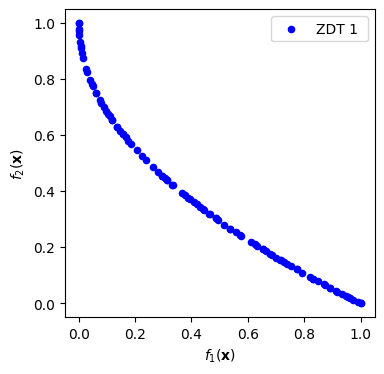

In [62]:
plot_colors = ('b','r', 'g', 'm', 'y', 'k', 'c')
fig, ax = plt.subplots(1, figsize=(4,4))

df.plot(ax=ax, kind='scatter', label='ZDT 1 ', 
        x=df.columns[0], y=df.columns[1], 
        color=plot_colors[i % len(plot_colors)])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

In [21]:
NDIM = 3

In [26]:
for index in range(1, 11):  # Adjust the range as needed    
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ)
    creator.create("Individual", list, fitness=creator.FitnessMin) 

    toolbox = base.Toolbox()

    toolbox.register("evaluate", zdt1)
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)

    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"

    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_iii(toolbox=toolbox,seed=index,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga3_zdt1_100_500_2_3-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga3_zdt1_100_500_2_3-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)

Iteration 1
gen	evals	Tiempo    
1  	     	0.00897717
2  	     	0.0179515 
3  	     	0.0239372 
4  	     	0.0299189 
5  	     	0.0339084 
6  	     	0.0388963 
7  	     	0.044879  
8  	     	0.0488682 
9  	     	0.0538549 
10 	     	0.0578842 
11 	     	0.0628726 
12 	     	0.0678833 
13 	     	0.0728748 
14 	     	0.0778284 
15 	     	0.083813  
16 	     	0.087765  
17 	     	0.0967445 
18 	     	0.103724  
19 	     	0.112699  
20 	     	0.121677  
21 	     	0.13065   
22 	     	0.139626  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


23 	     	0.148602  
24 	     	0.161567  
25 	     	0.171365  
26 	     	0.177525  
27 	     	0.189493  
28 	     	0.197474  
29 	     	0.208482  
30 	     	0.219413  
31 	     	0.231381  
32 	     	0.23777   
33 	     	0.244347  
34 	     	0.250329  
35 	     	0.257314  
36 	     	0.265291  
37 	     	0.2751    
38 	     	0.285759  
39 	     	0.294729  
40 	     	0.301711  
41 	     	0.309689  
42 	     	0.318666  
43 	     	0.325648  
44 	     	0.331667  
45 	     	0.336654  
46 	     	0.344597  
47 	     	0.354608  
48 	     	0.366537  
49 	     	0.377508  
50 	     	0.390472  
51 	     	0.402441  
52 	     	0.410424  
53 	     	0.423385  
54 	     	0.431365  
55 	     	0.443332  
56 	     	0.450313  
57 	     	0.460286  
58 	     	0.467266  
59 	     	0.476266  
60 	     	0.488212  
61 	     	0.500181  
62 	     	0.51047   
63 	     	0.517133  
64 	     	0.524114  
65 	     	0.529101  
66 	     	0.535086  
67 	     	0.541087  
68 	     	0.548052  
69 	     	0.553038  
70 	     	0.5

439	     	3.49019   
440	     	3.49717   
441	     	3.50815   
442	     	3.51513   
443	     	3.52111   
444	     	3.52809   
445	     	3.53707   
446	     	3.54508   
447	     	3.55107   
448	     	3.55705   
449	     	3.56499   
450	     	3.57297   
451	     	3.58095   
452	     	3.58993   
453	     	3.59691   
454	     	3.60289   
455	     	3.61187   
456	     	3.61785   
457	     	3.62593   
458	     	3.63181   
459	     	3.63757   
460	     	3.64677   
461	     	3.65437   
462	     	3.66077   
463	     	3.66875   
464	     	3.67374   
465	     	3.67972   
466	     	3.6867    
467	     	3.69269   
468	     	3.70063   
469	     	3.70961   
470	     	3.71862   
471	     	3.72556   
472	     	3.73254   
473	     	3.73953   
474	     	3.74551   
475	     	3.75349   
476	     	3.76845   
477	     	3.77643   
478	     	3.78341   
479	     	3.79039   
480	     	3.79737   
481	     	3.80918   
482	     	3.82078   
483	     	3.82629   
484	     	3.83826   
485	     	3.84524   
486	     	3.8

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


30 	     	0.182423  
31 	     	0.194389  
32 	     	0.202426  
33 	     	0.208391  
34 	     	0.213378  
35 	     	0.220359  
36 	     	0.229297  
37 	     	0.236326  
38 	     	0.244255  
39 	     	0.250277  
40 	     	0.256263  
41 	     	0.262209  
42 	     	0.270227  
43 	     	0.27521   
44 	     	0.281199  
45 	     	0.287179  
46 	     	0.292165  
47 	     	0.298149  
48 	     	0.304136  
49 	     	0.310121  
50 	     	0.3161    
51 	     	0.322084  
52 	     	0.327075  
53 	     	0.333058  
54 	     	0.339039  
55 	     	0.345062  
56 	     	0.351007  
57 	     	0.357952  
58 	     	0.370917  
59 	     	0.377935  
60 	     	0.383882  
61 	     	0.390863  
62 	     	0.398842  
63 	     	0.408816  
64 	     	0.415797  
65 	     	0.422779  
66 	     	0.430758  
67 	     	0.437739  
68 	     	0.444759  
69 	     	0.451702  
70 	     	0.459679  
71 	     	0.46666   
72 	     	0.473641  
73 	     	0.479625  
74 	     	0.485651  
75 	     	0.491632  
76 	     	0.496618  
77 	     	0.5

443	     	3.49681   
444	     	3.50528   
445	     	3.51181   
446	     	3.51876   
447	     	3.52574   
448	     	3.53277   
449	     	3.53874   
450	     	3.54476   
451	     	3.55176   
452	     	3.55869   
453	     	3.57162   
454	     	3.58462   
455	     	3.5926    
456	     	3.59759   
457	     	3.60553   
458	     	3.61251   
459	     	3.62049   
460	     	3.62647   
461	     	3.63345   
462	     	3.64043   
463	     	3.64741   
464	     	3.65439   
465	     	3.66138   
466	     	3.66839   
467	     	3.67537   
468	     	3.68236   
469	     	3.68834   
470	     	3.69486   
471	     	3.70433   
472	     	3.71324   
473	     	3.71922   
474	     	3.72524   
475	     	3.73192   
476	     	3.73821   
477	     	3.7432    
478	     	3.75313   
479	     	3.76015   
480	     	3.7651    
481	     	3.77212   
482	     	3.7771    
483	     	3.78309   
484	     	3.79103   
485	     	3.79701   
486	     	3.80998   
487	     	3.82396   
488	     	3.83281   
489	     	3.84477   
490	     	3.8

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


36 	     	0.19099   
37 	     	0.198813  
38 	     	0.205375  
39 	     	0.212391  
40 	     	0.220334  
41 	     	0.227315  
42 	     	0.233339  
43 	     	0.239319  
44 	     	0.245308  
45 	     	0.251287  
46 	     	0.258276  
47 	     	0.264216  
48 	     	0.270236  
49 	     	0.276225  
50 	     	0.282204  
51 	     	0.288189  
52 	     	0.293178  
53 	     	0.301684  
54 	     	0.307671  
55 	     	0.313895  
56 	     	0.318639  
57 	     	0.324628  
58 	     	0.330572  
59 	     	0.335595  
60 	     	0.34254   
61 	     	0.351516  
62 	     	0.360492  
63 	     	0.367621  
64 	     	0.374453  
65 	     	0.380563  
66 	     	0.38642   
67 	     	0.393404  
68 	     	0.399387  
69 	     	0.406367  
70 	     	0.416341  
71 	     	0.424356  
72 	     	0.430436  
73 	     	0.437321  
74 	     	0.444266  
75 	     	0.450291  
76 	     	0.456274  
77 	     	0.463257  
78 	     	0.470197  
79 	     	0.47618   
80 	     	0.484159  
81 	     	0.491141  
82 	     	0.498123  
83 	     	0.5

429	     	3.46244   
430	     	3.47401   
431	     	3.48195   
432	     	3.48997   
433	     	3.49595   
434	     	3.50293   
435	     	3.50892   
436	     	3.51604   
437	     	3.52398   
438	     	3.52996   
439	     	3.53797   
440	     	3.54396   
441	     	3.55146   
442	     	3.55693   
443	     	3.5649    
444	     	3.57185   
445	     	3.57784   
446	     	3.58539   
447	     	3.59084   
448	     	3.59778   
449	     	3.60476   
450	     	3.60975   
451	     	3.61673   
452	     	3.62371   
453	     	3.6307    
454	     	3.63768   
455	     	3.64469   
456	     	3.65067   
457	     	3.65666   
458	     	3.66361   
459	     	3.66963   
460	     	3.67757   
461	     	3.68555   
462	     	3.69153   
463	     	3.69752   
464	     	3.70549   
465	     	3.71746   
466	     	3.72362   
467	     	3.72943   
468	     	3.73641   
469	     	3.74339   
470	     	3.75037   
471	     	3.75636   
472	     	3.76134   
473	     	3.77052   
474	     	3.7773    
475	     	3.78428   
476	     	3.7

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 4
gen	evals	Tiempo    
1  	     	0.00958896
2  	     	0.016953  
3  	     	0.0269268 
4  	     	0.0374188 
5  	     	0.0434029 
6  	     	0.0513847 
7  	     	0.0597987 
8  	     	0.0663428 
9  	     	0.0743215 
10 	     	0.0842943 
11 	     	0.0912745 
12 	     	0.100252  
13 	     	0.113235  
14 	     	0.125186  
15 	     	0.131168  
16 	     	0.138557  
17 	     	0.143543  
18 	     	0.152519  
19 	     	0.160499  
20 	     	0.16748   
21 	     	0.172466  
22 	     	0.177452  
23 	     	0.182438  
24 	     	0.19341   
25 	     	0.201425  
26 	     	0.211363  
27 	     	0.224327  
28 	     	0.235706  
29 	     	0.244804  
30 	     	0.25665   
31 	     	0.269616  
32 	     	0.274761  
33 	     	0.282682  
34 	     	0.289562  
35 	     	0.294549  
36 	     	0.302526  
37 	     	0.309509  
38 	     	0.321477  
39 	     	0.326503  
40 	     	0.333552  
41 	     	0.340533  
42 	     	0.348511  
43 	     	0.357488  
44 	     	0.366531  
45 	     	0.375438  
46 	     	0.381422  
4

414	     	3.28972   
415	     	3.29585   
416	     	3.30764   
417	     	3.31362   
418	     	3.32463   
419	     	3.33062   
420	     	3.33881   
421	     	3.34573   
422	     	3.3547    
423	     	3.36069   
424	     	3.36671   
425	     	3.37269   
426	     	3.37869   
427	     	3.38562   
428	     	3.3916    
429	     	3.39659   
430	     	3.40257   
431	     	3.40856   
432	     	3.41454   
433	     	3.42053   
434	     	3.42851   
435	     	3.43549   
436	     	3.44261   
437	     	3.44906   
438	     	3.45707   
439	     	3.46206   
440	     	3.47004   
441	     	3.47702   
442	     	3.48297   
443	     	3.49294   
444	     	3.50291   
445	     	3.51193   
446	     	3.52086   
447	     	3.52788   
448	     	3.53586   
449	     	3.54085   
450	     	3.54842   
451	     	3.55455   
452	     	3.56135   
453	     	3.56836   
454	     	3.57435   
455	     	3.57934   
456	     	3.58831   
457	     	3.59529   
458	     	3.60224   
459	     	3.60922   
460	     	3.6162    
461	     	3.6

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 5
gen	evals	Tiempo    
1  	     	0.00897694
2  	     	0.0192339 
3  	     	0.026993  
4  	     	0.033144  
5  	     	0.0391946 
6  	     	0.0441172 
7  	     	0.048106  
8  	     	0.0540915 
9  	     	0.0591145 
10 	     	0.0641069 
11 	     	0.0691056 
12 	     	0.0760698 
13 	     	0.080091  
14 	     	0.0840747 
15 	     	0.0891469 
16 	     	0.0940213 
17 	     	0.0980124 
18 	     	0.102998  
19 	     	0.108981  
20 	     	0.112975  
21 	     	0.11799   
22 	     	0.122945  
23 	     	0.127963  
24 	     	0.131948  
25 	     	0.136971  
26 	     	0.141894  
27 	     	0.147883  
28 	     	0.151899  
29 	     	0.157814  
30 	     	0.163797  
31 	     	0.168914  
32 	     	0.175766  
33 	     	0.18295   
34 	     	0.187732  
35 	     	0.194714  
36 	     	0.200698  
37 	     	0.21175   
38 	     	0.216693  
39 	     	0.225631  
40 	     	0.234216  
41 	     	0.242142  
42 	     	0.250161  
43 	     	0.257104  
44 	     	0.264086  
45 	     	0.271066  
46 	     	0.278048  
4

415	     	3.07176   
416	     	3.08273   
417	     	3.08975   
418	     	3.09576   
419	     	3.10267   
420	     	3.10869   
421	     	3.11468   
422	     	3.12066   
423	     	3.12665   
424	     	3.13263   
425	     	3.13961   
426	     	3.14518   
427	     	3.15117   
428	     	3.15616   
429	     	3.16214   
430	     	3.16813   
431	     	3.17407   
432	     	3.18109   
433	     	3.18608   
434	     	3.19302   
435	     	3.19904   
436	     	3.20502   
437	     	3.21101   
438	     	3.21699   
439	     	3.22398   
440	     	3.22996   
441	     	3.23495   
442	     	3.24193   
443	     	3.24751   
444	     	3.25349   
445	     	3.25948   
446	     	3.26548   
447	     	3.27144   
448	     	3.27749   
449	     	3.28248   
450	     	3.29237   
451	     	3.30225   
452	     	3.30927   
453	     	3.31426   
454	     	3.3212    
455	     	3.32718   
456	     	3.33416   
457	     	3.34414   
458	     	3.35188   
459	     	3.3571    
460	     	3.36313   
461	     	3.3711    
462	     	3.3

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


19 	     	0.101729  
20 	     	0.10871   
21 	     	0.113695  
22 	     	0.120678  
23 	     	0.125663  
24 	     	0.13065   
25 	     	0.137633  
26 	     	0.143617  
27 	     	0.150599  
28 	     	0.159575  
29 	     	0.166555  
30 	     	0.173537  
31 	     	0.180517  
32 	     	0.187499  
33 	     	0.195479  
34 	     	0.205481  
35 	     	0.219415  
36 	     	0.230383  
37 	     	0.237364  
38 	     	0.244346  
39 	     	0.251327  
40 	     	0.256314  
41 	     	0.262298  
42 	     	0.269348  
43 	     	0.277259  
44 	     	0.28424   
45 	     	0.291222  
46 	     	0.298203  
47 	     	0.305184  
48 	     	0.315156  
49 	     	0.325169  
50 	     	0.330155  
51 	     	0.336142  
52 	     	0.343123  
53 	     	0.34811   
54 	     	0.354091  
55 	     	0.360074  
56 	     	0.367057  
57 	     	0.375578  
58 	     	0.384554  
59 	     	0.39353   
60 	     	0.399514  
61 	     	0.407494  
62 	     	0.413478  
63 	     	0.421457  
64 	     	0.428438  
65 	     	0.435419  
66 	     	0.4

425	     	2.97234   
426	     	2.98132   
427	     	2.9883    
428	     	2.99928   
429	     	3.00796   
430	     	3.01323   
431	     	3.02022   
432	     	3.02919   
433	     	3.03817   
434	     	3.04415   
435	     	3.05013   
436	     	3.05936   
437	     	3.0694    
438	     	3.0803    
439	     	3.08729   
440	     	3.09726   
441	     	3.10527   
442	     	3.11126   
443	     	3.1172    
444	     	3.12518   
445	     	3.13416   
446	     	3.14313   
447	     	3.15023   
448	     	3.1571    
449	     	3.16308   
450	     	3.17106   
451	     	3.17804   
452	     	3.18901   
453	     	3.19899   
454	     	3.20597   
455	     	3.21394   
456	     	3.22192   
457	     	3.22891   
458	     	3.23888   
459	     	3.24586   
460	     	3.25484   
461	     	3.26245   
462	     	3.26987   
463	     	3.27582   
464	     	3.2818    
465	     	3.28775   
466	     	3.29273   
467	     	3.29872   
468	     	3.30474   
469	     	3.31073   
470	     	3.31866   
471	     	3.32864   
472	     	3.3

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


14 	     	0.0708489 
15 	     	0.0798995 
16 	     	0.0838401 
17 	     	0.0888269 
18 	     	0.0957437 
19 	     	0.101728  
20 	     	0.107792  
21 	     	0.116727  
22 	     	0.125663  
23 	     	0.139626  
24 	     	0.145645  
25 	     	0.15163   
26 	     	0.155648  
27 	     	0.160634  
28 	     	0.166592  
29 	     	0.17158   
30 	     	0.177561  
31 	     	0.182548  
32 	     	0.18754   
33 	     	0.192521  
34 	     	0.199502  
35 	     	0.204489  
36 	     	0.210474  
37 	     	0.216457  
38 	     	0.222446  
39 	     	0.230387  
40 	     	0.237364  
41 	     	0.244344  
42 	     	0.249331  
43 	     	0.255316  
44 	     	0.261299  
45 	     	0.26828   
46 	     	0.273482  
47 	     	0.279251  
48 	     	0.285235  
49 	     	0.29425   
50 	     	0.300232  
51 	     	0.306692  
52 	     	0.313164  
53 	     	0.320179  
54 	     	0.326126  
55 	     	0.332109  
56 	     	0.340089  
57 	     	0.347071  
58 	     	0.353055  
59 	     	0.361033  
60 	     	0.367018  
61 	     	0.3

412	     	2.9334    
413	     	2.94437   
414	     	2.95434   
415	     	2.96247   
416	     	2.9693    
417	     	2.97931   
418	     	2.98629   
419	     	2.99327   
420	     	2.99926   
421	     	3.00541   
422	     	3.01219   
423	     	3.01917   
424	     	3.02615   
425	     	3.03413   
426	     	3.04111   
427	     	3.04709   
428	     	3.0541    
429	     	3.06105   
430	     	3.06704   
431	     	3.07801   
432	     	3.08499   
433	     	3.09301   
434	     	3.09902   
435	     	3.10793   
436	     	3.11491   
437	     	3.1199    
438	     	3.12591   
439	     	3.13348   
440	     	3.14046   
441	     	3.14741   
442	     	3.15738   
443	     	3.16736   
444	     	3.17437   
445	     	3.18132   
446	     	3.1883    
447	     	3.19628   
448	     	3.20332   
449	     	3.20928   
450	     	3.21427   
451	     	3.22025   
452	     	3.22723   
453	     	3.23281   
454	     	3.2388    
455	     	3.24577   
456	     	3.25076   
457	     	3.25671   
458	     	3.26372   
459	     	3.2

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	evals	Tiempo    
1  	     	0.00797653
2  	     	0.0149608 
3  	     	0.0199444 
4  	     	0.025126  
5  	     	0.0299194 
6  	     	0.0359035 
7  	     	0.0408902 
8  	     	0.0479069 
9  	     	0.052922  
10 	     	0.0569112 
11 	     	0.0628679 
12 	     	0.0688536 
13 	     	0.0728688 
14 	     	0.0798216 
15 	     	0.0838394 
16 	     	0.0888257 
17 	     	0.0937893 
18 	     	0.0978034 
19 	     	0.102761  
20 	     	0.107747  
21 	     	0.112762  
22 	     	0.11772   
23 	     	0.124667  
24 	     	0.133641  
25 	     	0.138667  
26 	     	0.145796  
27 	     	0.155583  
28 	     	0.162565  
29 	     	0.173563  
30 	     	0.18154   
31 	     	0.192511  
32 	     	0.197496  
33 	     	0.20348   
34 	     	0.208467  
35 	     	0.216447  
36 	     	0.225424  
37 	     	0.235397  
38 	     	0.245369  
39 	     	0.253387  
40 	     	0.259046  
41 	     	0.269305  
42 	     	0.281273  
43 	     	0.287257  
44 	     	0.298228  
45 	     	0.310196  
46 	     	0.317176  
47 	     	0.3

402	     	3.096     
403	     	3.10797   
404	     	3.11594   
405	     	3.12749   
406	     	3.13556   
407	     	3.14249   
408	     	3.15343   
409	     	3.1634    
410	     	3.17042   
411	     	3.17736   
412	     	3.18338   
413	     	3.19432   
414	     	3.2013    
415	     	3.20828   
416	     	3.21626   
417	     	3.22224   
418	     	3.2305    
419	     	3.23724   
420	     	3.24222   
421	     	3.24921   
422	     	3.25419   
423	     	3.26019   
424	     	3.26812   
425	     	3.27811   
426	     	3.28407   
427	     	3.29009   
428	     	3.29608   
429	     	3.30207   
430	     	3.30805   
431	     	3.31798   
432	     	3.32896   
433	     	3.33597   
434	     	3.34192   
435	     	3.34794   
436	     	3.35293   
437	     	3.35987   
438	     	3.36685   
439	     	3.37284   
440	     	3.38381   
441	     	3.39278   
442	     	3.39877   
443	     	3.40475   
444	     	3.41074   
445	     	3.41672   
446	     	3.4227    
447	     	3.42769   
448	     	3.43467   
449	     	3.4

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


7  	     	0.0395103 
8  	     	0.0474889 
9  	     	0.0534706 
10 	     	0.0594945 
11 	     	0.0634811 
12 	     	0.0694292 
13 	     	0.0754132 
14 	     	0.0813968 
15 	     	0.0873811 
16 	     	0.0923676 
17 	     	0.0993497 
18 	     	0.104336  
19 	     	0.109322  
20 	     	0.115306  
21 	     	0.122288  
22 	     	0.128271  
23 	     	0.134255  
24 	     	0.14024   
25 	     	0.145226  
26 	     	0.15121   
27 	     	0.156197  
28 	     	0.162181  
29 	     	0.169161  
30 	     	0.176178  
31 	     	0.182126  
32 	     	0.187113  
33 	     	0.195091  
34 	     	0.200115  
35 	     	0.207248  
36 	     	0.214267  
37 	     	0.221248  
38 	     	0.227195  
39 	     	0.235174  
40 	     	0.244149  
41 	     	0.253125  
42 	     	0.260144  
43 	     	0.267125  
44 	     	0.273073  
45 	     	0.280053  
46 	     	0.286037  
47 	     	0.293055  
48 	     	0.29904   
49 	     	0.305024  
50 	     	0.313333  
51 	     	0.320352  
52 	     	0.326296  
53 	     	0.33338   
54 	     	0.3

423	     	3.30598   
424	     	3.31396   
425	     	3.34388   
426	     	3.35588   
427	     	3.36484   
428	     	3.36986   
429	     	3.37585   
430	     	3.38183   
431	     	3.38782   
432	     	3.3938    
433	     	3.40378   
434	     	3.41774   
435	     	3.42771   
436	     	3.4337    
437	     	3.44068   
438	     	3.44766   
439	     	3.4536    
440	     	3.45964   
441	     	3.46567   
442	     	3.47166   
443	     	3.47764   
444	     	3.48757   
445	     	3.50054   
446	     	3.50852   
447	     	3.5155    
448	     	3.52447   
449	     	3.53448   
450	     	3.54047   
451	     	3.54745   
452	     	3.55244   
453	     	3.55942   
454	     	3.5644    
455	     	3.57039   
456	     	3.57737   
457	     	3.58734   
458	     	3.59333   
459	     	3.59931   
460	     	3.6053    
461	     	3.61128   
462	     	3.61726   
463	     	3.62325   
464	     	3.63019   
465	     	3.63717   
466	     	3.64315   
467	     	3.65014   
468	     	3.65612   
469	     	3.6631    
470	     	3.6

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


9  	     	0.0489068 
10 	     	0.0548887 
11 	     	0.0609095 
12 	     	0.0703533 
13 	     	0.0763407 
14 	     	0.0833211 
15 	     	0.0893431 
16 	     	0.0967155 
17 	     	0.104265  
18 	     	0.111247  
19 	     	0.116233  
20 	     	0.122217  
21 	     	0.128234  
22 	     	0.133225  
23 	     	0.138213  
24 	     	0.1442    
25 	     	0.14921   
26 	     	0.155131  
27 	     	0.161114  
28 	     	0.167098  
29 	     	0.17408   
30 	     	0.179066  
31 	     	0.186048  
32 	     	0.192032  
33 	     	0.197019  
34 	     	0.204     
35 	     	0.209984  
36 	     	0.216965  
37 	     	0.22594   
38 	     	0.233956  
39 	     	0.238944  
40 	     	0.243933  
41 	     	0.250873  
42 	     	0.255859  
43 	     	0.261844  
44 	     	0.270859  
45 	     	0.277021  
46 	     	0.283836  
47 	     	0.292908  
48 	     	0.300791  
49 	     	0.308806  
50 	     	0.315791  
51 	     	0.322771  
52 	     	0.329745  
53 	     	0.335735  
54 	     	0.341683  
55 	     	0.348664  
56 	     	0.3

419	     	3.12531   
420	     	3.13328   
421	     	3.14173   
422	     	3.14828   
423	     	3.15622   
424	     	3.1632    
425	     	3.16922   
426	     	3.17521   
427	     	3.18219   
428	     	3.18827   
429	     	3.19425   
430	     	3.20418   
431	     	3.21305   
432	     	3.21818   
433	     	3.22417   
434	     	3.2302    
435	     	3.23818   
436	     	3.2491    
437	     	3.25509   
438	     	3.26203   
439	     	3.27004   
440	     	3.27603   
441	     	3.28995   
442	     	3.29797   
443	     	3.30395   
444	     	3.30994   
445	     	3.31592   
446	     	3.3229    
447	     	3.33085   
448	     	3.33886   
449	     	3.3458    
450	     	3.35681   
451	     	3.3618    
452	     	3.36878   
453	     	3.37572   
454	     	3.38274   
455	     	3.38975   
456	     	3.39573   
457	     	3.40268   
458	     	3.40766   
459	     	3.41365   
460	     	3.42166   
461	     	3.42765   
462	     	3.4336    
463	     	3.43962   
464	     	3.4456    
465	     	3.45254   
466	     	3.4

## ZDT 2

In [24]:
NDIM = 4

In [27]:
for index in range(1, 11):  # Adjust the range as needed
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ)
    creator.create("Individual", list, fitness=creator.FitnessMin) 

    toolbox = base.Toolbox()
    toolbox.register("evaluate", zdt2)

    #Chromosome representation Real Valued
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    # Initialize statistics object
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"
    
    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_ii(toolbox=toolbox, seed=index, stats=stats, verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga2_zdt2_100_500_2_4-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga2_zdt2_100_500_2_4-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)

Iteration 1
gen	evals	Tiempo   
1  	     	0.0209804
2  	     	0.0508628


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


3  	     	0.0753539
4  	     	0.0972948
5  	     	0.123227 
6  	     	0.150218 
7  	     	0.169834 
8  	     	0.201652 
9  	     	0.239514 
10 	     	0.286018 
11 	     	0.319855 
12 	     	0.348776 
13 	     	0.37184  
14 	     	0.397701 
15 	     	0.426626 
16 	     	0.4725   
17 	     	0.508404 
18 	     	0.541315 
19 	     	0.569241 
20 	     	0.603153 
21 	     	0.635104 
22 	     	0.651063 
23 	     	0.674005 
24 	     	0.702884 
25 	     	0.728841 
26 	     	0.742867 
27 	     	0.759772 
28 	     	0.776722 
29 	     	0.835532 
30 	     	0.898364 
31 	     	0.953215 
32 	     	0.997097 
33 	     	1.01804  
34 	     	1.04338  
35 	     	1.07639  
36 	     	1.10513  
37 	     	1.13506  
38 	     	1.16934  
39 	     	1.19843  
40 	     	1.23317  
41 	     	1.2591   
42 	     	1.28724  
43 	     	1.31616  
44 	     	1.35018  
45 	     	1.38883  
46 	     	1.42526  
47 	     	1.46656  
48 	     	1.51144  
49 	     	1.57348  
50 	     	1.62214  
51 	     	1.65406  
52 	     	1.67643  


424	     	9.87453  
425	     	9.8855   
426	     	9.89743  
427	     	9.91339  
428	     	9.93238  
429	     	9.9463   
430	     	9.96425  
431	     	9.98344  
432	     	10.0071  
433	     	10.0251  
434	     	10.0441  
435	     	10.058   
436	     	10.072   
437	     	10.087   
438	     	10.0999  
439	     	10.1125  
440	     	10.1266  
441	     	10.1384  
442	     	10.1494  
443	     	10.1613  
444	     	10.1763  
445	     	10.1924  
446	     	10.2062  
447	     	10.2192  
448	     	10.2302  
449	     	10.2471  
450	     	10.277   
451	     	10.299   
452	     	10.3159  
453	     	10.3389  
454	     	10.3588  
455	     	10.3718  
456	     	10.3839  
457	     	10.4027  
458	     	10.4192  
459	     	10.4361  
460	     	10.4541  
461	     	10.47    
462	     	10.4851  
463	     	10.4999  
464	     	10.5209  
465	     	10.5368  
466	     	10.5568  
467	     	10.5707  
468	     	10.5857  
469	     	10.5977  
470	     	10.6139  
471	     	10.6268  
472	     	10.6408  
473	     	10.6538  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


3  	     	0.0821824
4  	     	0.112143 
5  	     	0.136079 
6  	     	0.157027 
7  	     	0.184088 
8  	     	0.203929 
9  	     	0.223868 
10 	     	0.244811 
11 	     	0.266752 
12 	     	0.292687 
13 	     	0.313589 
14 	     	0.337526 
15 	     	0.360613 
16 	     	0.38839  
17 	     	0.408373 
18 	     	0.447233 
19 	     	0.477151 
20 	     	0.500518 
21 	     	0.52407  
22 	     	0.545014 
23 	     	0.561114 
24 	     	0.577924 
25 	     	0.595931 
26 	     	0.616008 
27 	     	0.631877 
28 	     	0.647835 
29 	     	0.669775 
30 	     	0.685733 
31 	     	0.70767  
32 	     	0.723627 
33 	     	0.742576 
34 	     	0.761489 
35 	     	0.785426 
36 	     	0.807366 
37 	     	0.827312 
38 	     	0.844266 
39 	     	0.887156 
40 	     	0.93006  
41 	     	0.955991 
42 	     	0.982002 
43 	     	1.00292  
44 	     	1.02985  
45 	     	1.06675  
46 	     	1.12858  
47 	     	1.15751  
48 	     	1.18344  
49 	     	1.21288  
50 	     	1.23882  
51 	     	1.25875  
52 	     	1.2777   


414	     	8.90561  
415	     	8.91961  
416	     	8.93357  
417	     	8.9475   
418	     	8.96445  
419	     	8.98244  
420	     	8.99736  
421	     	9.01232  
422	     	9.02629  
423	     	9.04124  
424	     	9.05421  
425	     	9.06921  
426	     	9.08213  
427	     	9.0961   
428	     	9.10807  
429	     	9.12003  
430	     	9.132    
431	     	9.14397  
432	     	9.15594  
433	     	9.1689   
434	     	9.18087  
435	     	9.19284  
436	     	9.2058   
437	     	9.21777  
438	     	9.22889  
439	     	9.24104  
440	     	9.25201  
441	     	9.26503  
442	     	9.28098  
443	     	9.29894  
444	     	9.3131   
445	     	9.33105  
446	     	9.34804  
447	     	9.36496  
448	     	9.38291  
449	     	9.40389  
450	     	9.4199   
451	     	9.44389  
452	     	9.45984  
453	     	9.4758   
454	     	9.49275  
455	     	9.50975  
456	     	9.52371  
457	     	9.53586  
458	     	9.58469  
459	     	9.63057  
460	     	9.65932  
461	     	9.68537  
462	     	9.7024   
463	     	9.71639  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	evals	Tiempo 
1  	     	0.14582
2  	     	0.19469
3  	     	0.225606
4  	     	0.246549
5  	     	0.267493
6  	     	0.283452
7  	     	0.304435
8  	     	0.321392
9  	     	0.342295
10 	     	0.367226
11 	     	0.385216
12 	     	0.40119 
13 	     	0.421138
14 	     	0.449063
15 	     	0.481975
16 	     	0.514966
17 	     	0.55087 
18 	     	0.574843
19 	     	0.594268
20 	     	0.611224
21 	     	0.634161
22 	     	0.655145
23 	     	0.674055
24 	     	0.691011
25 	     	0.710955
26 	     	0.727958
27 	     	0.747958
28 	     	0.769835
29 	     	0.790784
30 	     	0.807738
31 	     	0.831634
32 	     	0.854571
33 	     	0.872523
34 	     	0.890474
35 	     	0.914446
36 	     	0.934397
37 	     	0.952347
38 	     	0.969309
39 	     	1.00218 
40 	     	1.03809 
41 	     	1.07329 
42 	     	1.10542 
43 	     	1.13235 
44 	     	1.16127 
45 	     	1.17926 
46 	     	1.20078 
47 	     	1.22172 
48 	     	1.24666 
49 	     	1.27258 
50 	     	1.29058 
51 	     	1.31062 
52 	     	1.330

436	     	9.52076 
437	     	9.54098 
438	     	9.56088 
439	     	9.58097 
440	     	9.59683 
441	     	9.61175 
442	     	9.6307  
443	     	9.64372 
444	     	9.65868 
445	     	9.67464 
446	     	9.6876  
447	     	9.70057 
448	     	9.71453 
449	     	9.73152 
450	     	9.74644 
451	     	9.75941 
452	     	9.7764  
453	     	9.79492 
454	     	9.81729 
455	     	9.84464 
456	     	9.87732 
457	     	9.90724 
458	     	9.93775 
459	     	9.97114 
460	     	9.99759 
461	     	10.0255 
462	     	10.0581 
463	     	10.0841 
464	     	10.1    
465	     	10.123  
466	     	10.1509 
467	     	10.1688 
468	     	10.1828 
469	     	10.1968 
470	     	10.2097 
471	     	10.2407 
472	     	10.2646 
473	     	10.2816 
474	     	10.2955 
475	     	10.3095 
476	     	10.3245 
477	     	10.3384 
478	     	10.3504 
479	     	10.3693 
480	     	10.3843 
481	     	10.3983 
482	     	10.4102 
483	     	10.4242 
484	     	10.4392 
485	     	10.4551 
486	     	10.4681 
487	     	10.488  
488	     	10

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 4
gen	evals	Tiempo   
1  	     	0.0443866
2  	     	0.0992968
3  	     	0.12717  
4  	     	0.147186 
5  	     	0.166065 
6  	     	0.190003 
7  	     	0.213939 
8  	     	0.237919 
9  	     	0.258945 
10 	     	0.275814 
11 	     	0.295719 
12 	     	0.315706 
13 	     	0.337648 
14 	     	0.360145 
15 	     	0.382087 
16 	     	0.404064 
17 	     	0.426965 
18 	     	0.449939 
19 	     	0.468853 
20 	     	0.486805 
21 	     	0.502762 
22 	     	0.519717 
23 	     	0.544651 
24 	     	0.571604 
25 	     	0.605512 
26 	     	0.624576 
27 	     	0.648397 
28 	     	0.675324 
29 	     	0.694274 
30 	     	0.716216 
31 	     	0.743144 
32 	     	0.773063 
33 	     	0.806972 
34 	     	0.832901 
35 	     	0.86455  
36 	     	0.894294 
37 	     	0.924177 
38 	     	0.956128 
39 	     	0.986048 
40 	     	1.01493  
41 	     	1.04685  
42 	     	1.0939   
43 	     	1.1318   
44 	     	1.15364  
45 	     	1.1895   
46 	     	1.22042  
47 	     	1.25639  
48 	     	1.27883  
49 	    

415	     	9.38143  
416	     	9.41434  
417	     	9.43528  
418	     	9.45922  
419	     	9.48016  
420	     	9.49512  
421	     	9.51912  
422	     	9.5403   
423	     	9.56018  
424	     	9.58588  
425	     	9.61185  
426	     	9.62877  
427	     	9.65171  
428	     	9.67963  
429	     	9.69858  
430	     	9.7167   
431	     	9.73419  
432	     	9.74916  
433	     	9.76511  
434	     	9.77804  
435	     	9.79909  
436	     	9.82366  
437	     	9.83989  
438	     	9.85585  
439	     	9.8738   
440	     	9.89275  
441	     	9.9199   
442	     	9.94384  
443	     	9.96279  
444	     	9.98573  
445	     	10.0097  
446	     	10.0249  
447	     	10.0409  
448	     	10.0578  
449	     	10.0777  
450	     	10.0967  
451	     	10.1147  
452	     	10.1356  
453	     	10.152   
454	     	10.1675  
455	     	10.1865  
456	     	10.2005  
457	     	10.215   
458	     	10.2309  
459	     	10.2489  
460	     	10.2738  
461	     	10.2868  
462	     	10.3017  
463	     	10.3137  
464	     	10.3276  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


6  	     	0.14766  
7  	     	0.169637 
8  	     	0.187595 
9  	     	0.211488 
10 	     	0.229438 
11 	     	0.24848  
12 	     	0.266435 
13 	     	0.287339 
14 	     	0.313271 
15 	     	0.337207 
16 	     	0.360181 
17 	     	0.381088 
18 	     	0.403031 
19 	     	0.426007 
20 	     	0.448908 
21 	     	0.483813 
22 	     	0.514234 
23 	     	0.545186 
24 	     	0.574101 
25 	     	0.603513 
26 	     	0.626451 
27 	     	0.645437 
28 	     	0.661393 
29 	     	0.683337 
30 	     	0.706792 
31 	     	0.731726 
32 	     	0.751207 
33 	     	0.769625 
34 	     	0.797166 
35 	     	0.819149 
36 	     	0.841049 
37 	     	0.863033 
38 	     	0.883972 
39 	     	0.906465 
40 	     	0.93343  
41 	     	0.955348 
42 	     	0.979271 
43 	     	1.00579  
44 	     	1.03268  
45 	     	1.06561  
46 	     	1.10074  
47 	     	1.13046  
48 	     	1.15136  
49 	     	1.17131  
50 	     	1.1883   
51 	     	1.21323  
52 	     	1.23717  
53 	     	1.25612  
54 	     	1.27507  
55 	     	1.29311  


420	     	9.18956  
421	     	9.20613  
422	     	9.22013  
423	     	9.23804  
424	     	9.25201  
425	     	9.30786  
426	     	9.35179  
427	     	9.37867  
428	     	9.4066   
429	     	9.42654  
430	     	9.44749  
431	     	9.46547  
432	     	9.48442  
433	     	9.50046  
434	     	9.5173   
435	     	9.53376  
436	     	9.54954  
437	     	9.57444  
438	     	9.59834  
439	     	9.6133   
440	     	9.62726  
441	     	9.64322  
442	     	9.66117  
443	     	9.68311  
444	     	9.70306  
445	     	9.72301  
446	     	9.74426  
447	     	9.75891  
448	     	9.77586  
449	     	9.78883  
450	     	9.80682  
451	     	9.82179  
452	     	9.83471  
453	     	9.85266  
454	     	9.86961  
455	     	9.8846   
456	     	9.90652  
457	     	9.92362  
458	     	9.94365  
459	     	9.96161  
460	     	9.97757  
461	     	9.99352  
462	     	10.0105  
463	     	10.0234  
464	     	10.0377  
465	     	10.0546  
466	     	10.0706  
467	     	10.0836  
468	     	10.0975  
469	     	10.1115  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 6
gen	evals	Tiempo   
1  	     	0.0179532
2  	     	0.0510287
3  	     	0.078908 
4  	     	0.102844 
5  	     	0.122825 
6  	     	0.145801 
7  	     	0.164819 
8  	     	0.183698 
9  	     	0.205639 
10 	     	0.220599 
11 	     	0.237681 
12 	     	0.26361  
13 	     	0.282557 
14 	     	0.306453 
15 	     	0.329391 
16 	     	0.346344 
17 	     	0.364296 
18 	     	0.387235 
19 	     	0.408412 
20 	     	0.425133 
21 	     	0.443633 
22 	     	0.462582 
23 	     	0.488514 
24 	     	0.511452 
25 	     	0.531956 
26 	     	0.551903 
27 	     	0.571849 
28 	     	0.594788 
29 	     	0.626702 
30 	     	0.655663 
31 	     	0.679559 
32 	     	0.699506 
33 	     	0.724441 
34 	     	0.753876 
35 	     	0.780804 
36 	     	0.806774 
37 	     	0.832222 
38 	     	0.852169 
39 	     	0.877101 
40 	     	0.906026 
41 	     	0.937615 
42 	     	0.961553 
43 	     	0.990432 
44 	     	1.02135  
45 	     	1.0498   
46 	     	1.0907   
47 	     	1.1294   
48 	     	1.15467  
49 	    

415	     	8.55152  
416	     	8.56943  
417	     	8.58549  
418	     	8.60533  
419	     	8.62332  
420	     	8.64327  
421	     	8.66022  
422	     	8.67419  
423	     	8.68915  
424	     	8.70312  
425	     	8.71508  
426	     	8.72804  
427	     	8.74101  
428	     	8.75398  
429	     	8.76798  
430	     	8.78091  
431	     	8.80181  
432	     	8.81976  
433	     	8.83277  
434	     	8.84673  
435	     	8.86867  
436	     	8.88957  
437	     	8.90164  
438	     	8.9146   
439	     	8.92856  
440	     	8.94153  
441	     	8.95449  
442	     	8.97245  
443	     	8.9894   
444	     	9.01049  
445	     	9.02844  
446	     	9.04739  
447	     	9.06634  
448	     	9.0803   
449	     	9.09389  
450	     	9.10781  
451	     	9.12477  
452	     	9.14372  
453	     	9.15668  
454	     	9.16965  
455	     	9.18261  
456	     	9.19571  
457	     	9.2137   
458	     	9.22767  
459	     	9.24163  
460	     	9.25659  
461	     	9.2735   
462	     	9.29245  
463	     	9.30845  
464	     	9.32042  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


2  	     	0.0668221
3  	     	0.103721 
4  	     	0.126735 
5  	     	0.155616 
6  	     	0.174607 
7  	     	0.195556 
8  	     	0.2165   
9  	     	0.237449 
10 	     	0.259342 
11 	     	0.286268 
12 	     	0.307212 
13 	     	0.332149 
14 	     	0.350138 
15 	     	0.370086 
16 	     	0.395976 
17 	     	0.411932 
18 	     	0.428887 
19 	     	0.446839 
20 	     	0.463794 
21 	     	0.480748 
22 	     	0.499697 
23 	     	0.514657 
24 	     	0.535601 
25 	     	0.55359  
26 	     	0.570547 
27 	     	0.590456 
28 	     	0.612397 
29 	     	0.635335 
30 	     	0.657277 
31 	     	0.672108 
32 	     	0.700099 
33 	     	0.720024 
34 	     	0.739971 
35 	     	0.759936 
36 	     	0.778865 
37 	     	0.799811 
38 	     	0.828692 
39 	     	0.856615 
40 	     	0.876653 
41 	     	0.904543 
42 	     	0.928478 
43 	     	0.95341  
44 	     	0.977954 
45 	     	1.00389  
46 	     	1.03786  
47 	     	1.07205  
48 	     	1.10397  
49 	     	1.12391  
50 	     	1.14589  
51 	     	1.16444  


412	     	9.08067  
413	     	9.10737  
414	     	9.1343   
415	     	9.1493   
416	     	9.16632  
417	     	9.18623  
418	     	9.20223  
419	     	9.21814  
420	     	9.2331   
421	     	9.24811  
422	     	9.26512  
423	     	9.29304  
424	     	9.31993  
425	     	9.33589  
426	     	9.35189  
427	     	9.37682  
428	     	9.39772  
429	     	9.41269  
430	     	9.42864  
431	     	9.44759  
432	     	9.4666   
433	     	9.48554  
434	     	9.50549  
435	     	9.52444  
436	     	9.5404   
437	     	9.55787  
438	     	9.57386  
439	     	9.58883  
440	     	9.60873  
441	     	9.62968  
442	     	9.65261  
443	     	9.67456  
444	     	9.69749  
445	     	9.71545  
446	     	9.73343  
447	     	9.74836  
448	     	9.76533  
449	     	9.78129  
450	     	9.79625  
451	     	9.81121  
452	     	9.82517  
453	     	9.83913  
454	     	9.85409  
455	     	9.86905  
456	     	9.88401  
457	     	9.90396  
458	     	9.9269   
459	     	9.94285  
460	     	9.9589   
461	     	9.97884  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


7  	     	0.212953 
8  	     	0.234852 
9  	     	0.253801 
10 	     	0.277776 
11 	     	0.297729 
12 	     	0.317672 
13 	     	0.338616 
14 	     	0.356597 
15 	     	0.376476 
16 	     	0.394424 
17 	     	0.41293  
18 	     	0.431879 
19 	     	0.448834 
20 	     	0.467783 
21 	     	0.486773 
22 	     	0.510267 
23 	     	0.532281 
24 	     	0.554147 
25 	     	0.576089 
26 	     	0.600024 
27 	     	0.621555 
28 	     	0.647451 
29 	     	0.671388 
30 	     	0.696321 
31 	     	0.718261 
32 	     	0.746186 
33 	     	0.775146 
34 	     	0.799086 
35 	     	0.815647 
36 	     	0.833558 
37 	     	0.853541 
38 	     	0.876479 
39 	     	0.896691 
40 	     	0.919327 
41 	     	0.943298 
42 	     	0.961257 
43 	     	0.979208 
44 	     	0.999115 
45 	     	1.02604  
46 	     	1.05397  
47 	     	1.08688  
48 	     	1.11633  
49 	     	1.14326  
50 	     	1.17218  
51 	     	1.22005  
52 	     	1.24698  
53 	     	1.26792  
54 	     	1.29012  
55 	     	1.31185  
56 	     	1.3308   


417	     	9.41372  
418	     	9.43467  
419	     	9.44963  
420	     	9.46658  
421	     	9.48453  
422	     	9.50149  
423	     	9.51848  
424	     	9.53104  
425	     	9.546    
426	     	9.56092  
427	     	9.57987  
428	     	9.59283  
429	     	9.6188   
430	     	9.66265  
431	     	9.67561  
432	     	9.68958  
433	     	9.70557  
434	     	9.71953  
435	     	9.7325   
436	     	9.75041  
437	     	9.7674   
438	     	9.78332  
439	     	9.79651  
440	     	9.82123  
441	     	9.84098  
442	     	9.85494  
443	     	9.86891  
444	     	9.88088  
445	     	9.89484  
446	     	9.9098   
447	     	9.92376  
448	     	9.93675  
449	     	9.95103  
450	     	9.96416  
451	     	9.97818  
452	     	10.0001  
453	     	10.0141  
454	     	10.03    
455	     	10.042   
456	     	10.0561  
457	     	10.0699  
458	     	10.0819  
459	     	10.0944  
460	     	10.1074  
461	     	10.1234  
462	     	10.1423  
463	     	10.1632  
464	     	10.1866  
465	     	10.2151  
466	     	10.243   


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 9
gen	evals	Tiempo   
1  	     	0.0219741
2  	     	0.0579085
3  	     	0.0798602
4  	     	0.117722 
5  	     	0.137629 
6  	     	0.157576 
7  	     	0.181513 
8  	     	0.209439 
9  	     	0.234411 
10 	     	0.257311 
11 	     	0.289496 
12 	     	0.321178 
13 	     	0.341085 
14 	     	0.362298 
15 	     	0.382468 
16 	     	0.404145 
17 	     	0.426125 
18 	     	0.443083 
19 	     	0.462422 
20 	     	0.489351 
21 	     	0.525254 
22 	     	0.545238 
23 	     	0.567847 
24 	     	0.592606 
25 	     	0.612551 
26 	     	0.639481 
27 	     	0.659798 
28 	     	0.689681 
29 	     	0.714334 
30 	     	0.742541 
31 	     	0.7626   
32 	     	0.784543 
33 	     	0.810474 
34 	     	0.836402 
35 	     	0.859003 
36 	     	0.878463 
37 	     	0.907422 
38 	     	0.927368 
39 	     	0.957288 
40 	     	0.985636 
41 	     	1.00754  
42 	     	1.03746  
43 	     	1.07037  
44 	     	1.12024  
45 	     	1.14318  
46 	     	1.16275  
47 	     	1.18266  
48 	     	1.20161  
49 	    

420	     	9.28766  
421	     	9.30374  
422	     	9.35443  
423	     	9.37044  
424	     	9.39346  
425	     	9.4088   
426	     	9.42953  
427	     	9.45157  
428	     	9.46737  
429	     	9.48266  
430	     	9.50317  
431	     	9.52253  
432	     	9.54647  
433	     	9.56765  
434	     	9.57865  
435	     	9.5944   
436	     	9.61645  
437	     	9.62749  
438	     	9.64221  
439	     	9.65638  
440	     	9.67058  
441	     	9.68757  
442	     	9.70224  
443	     	9.72571  
444	     	9.74389  
445	     	9.76324  
446	     	9.78131  
447	     	9.80915  
448	     	9.8264   
449	     	9.84422  
450	     	9.86326  
451	     	9.8765   
452	     	9.89784  
453	     	9.91975  
454	     	9.93931  
455	     	9.95679  
456	     	9.98282  
457	     	10.0026  
458	     	10.0188  
459	     	10.0461  
460	     	10.0649  
461	     	10.0838  
462	     	10.1158  
463	     	10.1366  
464	     	10.1608  
465	     	10.1816  
466	     	10.2067  
467	     	10.2351  
468	     	10.2528  
469	     	10.2772  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


4  	     	0.123993 
5  	     	0.158036 
6  	     	0.189781 
7  	     	0.218589 
8  	     	0.255033 
9  	     	0.284611 
10 	     	0.310022 
11 	     	0.345937 
12 	     	0.382405 
13 	     	0.409272 
14 	     	0.424752 
15 	     	0.446945 
16 	     	0.47173  
17 	     	0.493025 
18 	     	0.512357 
19 	     	0.532994 
20 	     	0.557516 
21 	     	0.574789 
22 	     	0.590484 
23 	     	0.606169 
24 	     	0.628175 
25 	     	0.670884 
26 	     	0.728122 
27 	     	0.794925 
28 	     	0.839905 
29 	     	0.859973 
30 	     	0.882433 
31 	     	0.898386 
32 	     	0.918385 
33 	     	0.934385 
34 	     	0.954735 
35 	     	0.973284 
36 	     	0.994613 
37 	     	1.03126  
38 	     	1.05878  
39 	     	1.0905   
40 	     	1.12303  
41 	     	1.14774  
42 	     	1.17369  
43 	     	1.20589  
44 	     	1.23103  
45 	     	1.2541   
46 	     	1.27677  
47 	     	1.2989   
48 	     	1.32479  
49 	     	1.34804  
50 	     	1.378    
51 	     	1.39956  
52 	     	1.41901  
53 	     	1.43961  


421	     	9.09221  
422	     	9.11394  
423	     	9.12971  
424	     	9.14794  
425	     	9.16481  
426	     	9.17772  
427	     	9.19372  
428	     	9.22271  
429	     	9.23928  
430	     	9.25134  
431	     	9.2678   
432	     	9.28298  
433	     	9.29757  
434	     	9.3179   
435	     	9.33979  
436	     	9.36392  
437	     	9.38195  
438	     	9.39885  
439	     	9.41377  
440	     	9.43101  
441	     	9.44701  
442	     	9.46778  
443	     	9.48538  
444	     	9.49972  
445	     	9.52135  
446	     	9.53826  
447	     	9.55131  
448	     	9.57131  
449	     	9.58968  
450	     	9.60973  
451	     	9.62527  
452	     	9.64853  
453	     	9.66187  
454	     	9.68047  
455	     	9.6937   
456	     	9.7097   
457	     	9.72256  
458	     	9.73462  
459	     	9.75062  
460	     	9.76563  
461	     	9.78563  
462	     	9.80242  
463	     	9.81997  
464	     	9.83586  
465	     	9.84719  
466	     	9.85919  
467	     	9.87645  
468	     	9.89473  
469	     	9.90673  
470	     	9.9275   


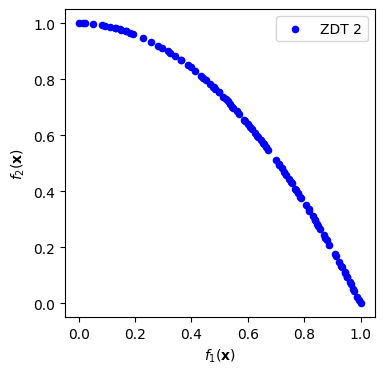

In [71]:
plot_colors = ('b','r', 'g', 'm', 'y', 'k', 'c')
fig, ax = plt.subplots(1, figsize=(4,4))

df.plot(ax=ax, kind='scatter', label='ZDT 2', 
        x=df.columns[0], y=df.columns[1], 
        color=plot_colors[i % len(plot_colors)])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

In [28]:
for index in range(1, 11):
    toolbox.register("select", tools.selNSGA3, ref_points=ref_points)
    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"
    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_iii(toolbox=toolbox,seed=index,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga3_zdt2_100_500_2_4-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga3_zdt2_100_500_2_4-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)


Iteration 1
gen	evals	Tiempo   
1  	     	0.0152161
2  	     	0.0323231
3  	     	0.0470762
4  	     	0.049901 
5  	     	0.0727594
6  	     	0.088835 
7  	     	0.0970809
8  	     	0.104695 
9  	     	0.105727 
10 	     	0.113785 
11 	     	0.12221  
12 	     	0.12324  
13 	     	0.12324  
14 	     	0.133513 
15 	     	0.133513 
16 	     	0.133513 
17 	     	0.149154 
18 	     	0.149154 
19 	     	0.149154 
20 	     	0.149154 
21 	     	0.164775 
22 	     	0.164775 
23 	     	0.174288 
24 	     	0.174288 
25 	     	0.174288 
26 	     	0.195461 
27 	     	0.196461 
28 	     	0.205275 
29 	     	0.214577 
30 	     	0.222434 
31 	     	0.223433 
32 	     	0.231453 
33 	     	0.238946 
34 	     	0.255192 
35 	     	0.261894 
36 	     	0.261894 
37 	     	0.274193 
38 	     	0.284261 
39 	     	0.28859  
40 	     	0.299275 
41 	     	0.307671 
42 	     	0.307671 
43 	     	0.315724 
44 	     	0.322963 
45 	     	0.322963 
46 	     	0.338811 
47 	     	0.34808  
48 	     	0.355543 
49 	    

414	     	3.04344  
415	     	3.04828  
416	     	3.05548  
417	     	3.06231  
418	     	3.07092  
419	     	3.07547  
420	     	3.07547  
421	     	3.08891  
422	     	3.08891  
423	     	3.09695  
424	     	3.10548  
425	     	3.10548  
426	     	3.10548  
427	     	3.12219  
428	     	3.12219  
429	     	3.13787  
430	     	3.1389   
431	     	3.1389   
432	     	3.15511  
433	     	3.16186  
434	     	3.16489  
435	     	3.1728   
436	     	3.17585  
437	     	3.18785  
438	     	3.18885  
439	     	3.1969   
440	     	3.20641  
441	     	3.20641  
442	     	3.20641  
443	     	3.22477  
444	     	3.22477  
445	     	3.23542  
446	     	3.23542  
447	     	3.23542  
448	     	3.25639  
449	     	3.25956  
450	     	3.25956  
451	     	3.27705  
452	     	3.28892  
453	     	3.28975  
454	     	3.29903  
455	     	3.30748  
456	     	3.30748  
457	     	3.31553  
458	     	3.32278  
459	     	3.32278  
460	     	3.32278  
461	     	3.34354  
462	     	3.34354  
463	     	3.34354  


316	     	2.49419   
317	     	2.50392   
318	     	2.51119   
319	     	2.51223   
320	     	2.5203    
321	     	2.52861   
322	     	2.52861   
323	     	2.53666   
324	     	2.54609   
325	     	2.54609   
326	     	2.54609   
327	     	2.56226   
328	     	2.56777   
329	     	2.56777   
330	     	2.58722   
331	     	2.59593   
332	     	2.59593   
333	     	2.60616   
334	     	2.61147   
335	     	2.61147   
336	     	2.61147   
337	     	2.62841   
338	     	2.62841   
339	     	2.64414   
340	     	2.64514   
341	     	2.64514   
342	     	2.66152   
343	     	2.66252   
344	     	2.67479   
345	     	2.67479   
346	     	2.67479   
347	     	2.69049   
348	     	2.69049   
349	     	2.70837   
350	     	2.71831   
351	     	2.72836   
352	     	2.72836   
353	     	2.74447   
354	     	2.75304   
355	     	2.76104   
356	     	2.76248   
357	     	2.76804   
358	     	2.77804   
359	     	2.78626   
360	     	2.78626   
361	     	2.78626   
362	     	2.80194   
363	     	2.8

224	     	1.54698  
225	     	1.54901  
226	     	1.56124  
227	     	1.57128  
228	     	1.57993  
229	     	1.58627  
230	     	1.59304  
231	     	1.59304  
232	     	1.6011   
233	     	1.60792  
234	     	1.61597  
235	     	1.61597  
236	     	1.62551  
237	     	1.62551  
238	     	1.64034  
239	     	1.64134  
240	     	1.64134  
241	     	1.65828  
242	     	1.65828  
243	     	1.67455  
244	     	1.67558  
245	     	1.68489  
246	     	1.6912   
247	     	1.6912   
248	     	1.6912   
249	     	1.70892  
250	     	1.71596  
251	     	1.71701  
252	     	1.72996  
253	     	1.73099  
254	     	1.74227  
255	     	1.74227  
256	     	1.75032  
257	     	1.75984  
258	     	1.77019  
259	     	1.77765  
260	     	1.77765  
261	     	1.7922   
262	     	1.7922   
263	     	1.80026  
264	     	1.8079   
265	     	1.81832  
266	     	1.82862  
267	     	1.83526  
268	     	1.84251  
269	     	1.84251  
270	     	1.85234  
271	     	1.85919  
272	     	1.86721  
273	     	1.87441  


135	     	0.95901   
136	     	0.961039  
137	     	0.972578  
138	     	0.984762  
139	     	0.99579   
140	     	1.00444   
141	     	1.02652   
142	     	1.03345   
143	     	1.04541   
144	     	1.05553   
145	     	1.07458   
146	     	1.08678   
147	     	1.0982    
148	     	1.11017   
149	     	1.12029   
150	     	1.13386   
151	     	1.14518   
152	     	1.14518   
153	     	1.14518   
154	     	1.16258   
155	     	1.17382   
156	     	1.18198   
157	     	1.196     
158	     	1.20217   
159	     	1.20217   
160	     	1.2174    
161	     	1.2174    
162	     	1.23249   
163	     	1.23249   
164	     	1.24464   
165	     	1.24564   
166	     	1.24564   
167	     	1.26279   
168	     	1.26279   
169	     	1.26279   
170	     	1.27831   
171	     	1.29595   
172	     	1.29595   
173	     	1.29595   
174	     	1.3123    
175	     	1.3123    
176	     	1.32908   
177	     	1.33268   
178	     	1.33268   
179	     	1.34978   
180	     	1.35673   
181	     	1.36137   
182	     	1.3

42 	     	0.21807   
43 	     	0.224919  
44 	     	0.247352  
45 	     	0.258073  
46 	     	0.266138  
47 	     	0.2742    
48 	     	0.275799  
49 	     	0.283851  
50 	     	0.292744  
51 	     	0.292744  
52 	     	0.292744  
53 	     	0.309512  
54 	     	0.309512  
55 	     	0.309512  
56 	     	0.326309  
57 	     	0.326309  
58 	     	0.326309  
59 	     	0.343027  
60 	     	0.343027  
61 	     	0.358817  
62 	     	0.359814  
63 	     	0.359814  
64 	     	0.376539  
65 	     	0.376539  
66 	     	0.390615  
67 	     	0.391613  
68 	     	0.391613  
69 	     	0.408551  
70 	     	0.413198  
71 	     	0.413198  
72 	     	0.413198  
73 	     	0.441106  
74 	     	0.452511  
75 	     	0.457392  
76 	     	0.464099  
77 	     	0.474772  
78 	     	0.474772  
79 	     	0.482827  
80 	     	0.491709  
81 	     	0.491709  
82 	     	0.499753  
83 	     	0.508399  
84 	     	0.508399  
85 	     	0.508399  
86 	     	0.525073  
87 	     	0.525073  
88 	     	0.525073  
89 	     	0.5

460	     	3.26455   
461	     	3.26911   
462	     	3.27464   
463	     	3.28268   
464	     	3.29721   
465	     	3.2982    
466	     	3.3133    
467	     	3.31533   
468	     	3.32749   
469	     	3.33228   
470	     	3.34475   
471	     	3.34838   
472	     	3.36082   
473	     	3.36431   
474	     	3.37552   
475	     	3.38132   
476	     	3.39111   
477	     	3.39573   
478	     	3.39573   
479	     	3.40808   
480	     	3.41617   
481	     	3.41617   
482	     	3.42771   
483	     	3.43576   
484	     	3.44056   
485	     	3.45819   
486	     	3.45819   
487	     	3.46623   
488	     	3.47567   
489	     	3.47567   
490	     	3.4935    
491	     	3.50328   
492	     	3.51323   
493	     	3.51422   
494	     	3.52463   
495	     	3.52463   
496	     	3.53269   
497	     	3.54174   
498	     	3.54174   
499	     	3.5498    
500	     	3.55916   
Iteration 6
gen	evals	Tiempo     
1  	     	0.000997305
2  	     	0.000997305
3  	     	0.000997305
4  	     	0.0209925  
5  	     	0.02099

354	     	2.5626     
355	     	2.57276    
356	     	2.58187    
357	     	2.59602    
358	     	2.6025     
359	     	2.61152    
360	     	2.61765    
361	     	2.62686    
362	     	2.62785    
363	     	2.64304    
364	     	2.64552    
365	     	2.65951    
366	     	2.66051    
367	     	2.67635    
368	     	2.67843    
369	     	2.69097    
370	     	2.69785    
371	     	2.71053    
372	     	2.71156    
373	     	2.72653    
374	     	2.72853    
375	     	2.74205    
376	     	2.7435     
377	     	2.75928    
378	     	2.7624     
379	     	2.77286    
380	     	2.77537    
381	     	2.78546    
382	     	2.797      
383	     	2.80423    
384	     	2.80423    
385	     	2.81347    
386	     	2.82019    
387	     	2.82944    
388	     	2.83609    
389	     	2.83609    
390	     	2.84411    
391	     	2.85208    
392	     	2.86029    
393	     	2.86128    
394	     	2.87299    
395	     	2.88419    
396	     	2.88727    
397	     	2.88727    
398	     	2.88727    
399	     	

254	     	1.85487   
255	     	1.85646   
256	     	1.86947   
257	     	1.87559   
258	     	1.88132   
259	     	1.8882    
260	     	1.8932    
261	     	1.9031    
262	     	1.91025   
263	     	1.91971   
264	     	1.92626   
265	     	1.93252   
266	     	1.94057   
267	     	1.94721   
268	     	1.95426   
269	     	1.95426   
270	     	1.96342   
271	     	1.96924   
272	     	1.9748    
273	     	1.98479   
274	     	1.98679   
275	     	1.98679   
276	     	2.00268   
277	     	2.00268   
278	     	2.00268   
279	     	2.01944   
280	     	2.01944   
281	     	2.01944   
282	     	2.03617   
283	     	2.03617   
284	     	2.03617   
285	     	2.05292   
286	     	2.05292   
287	     	2.05292   
288	     	2.07503   
289	     	2.0834    
290	     	2.08572   
291	     	2.09377   
292	     	2.10187   
293	     	2.10291   
294	     	2.11097   
295	     	2.11934   
296	     	2.12129   
297	     	2.12129   
298	     	2.12129   
299	     	2.1381    
300	     	2.1381    
301	     	2.1

153	     	1.05356   
154	     	1.06923   
155	     	1.08216   
156	     	1.09486   
157	     	1.10597   
158	     	1.11013   
159	     	1.11911   
160	     	1.12982   
161	     	1.13732   
162	     	1.13732   
163	     	1.13732   
164	     	1.15407   
165	     	1.15407   
166	     	1.16926   
167	     	1.16926   
168	     	1.16926   
169	     	1.187     
170	     	1.187     
171	     	1.187     
172	     	1.20387   
173	     	1.20387   
174	     	1.20387   
175	     	1.22526   
176	     	1.22778   
177	     	1.23699   
178	     	1.23699   
179	     	1.23699   
180	     	1.25291   
181	     	1.25291   
182	     	1.2684    
183	     	1.27642   
184	     	1.28701   
185	     	1.28701   
186	     	1.29505   
187	     	1.30293   
188	     	1.31094   
189	     	1.31094   
190	     	1.32018   
191	     	1.3289    
192	     	1.33601   
193	     	1.33601   
194	     	1.33601   
195	     	1.35271   
196	     	1.35271   
197	     	1.35271   
198	     	1.36941   
199	     	1.36941   
200	     	1.3

52 	     	0.339464  
53 	     	0.347936  
54 	     	0.354637  
55 	     	0.367404  
56 	     	0.371246  
57 	     	0.386163  
58 	     	0.392675  
59 	     	0.402168  
60 	     	0.402168  
61 	     	0.422061  
62 	     	0.422061  
63 	     	0.4354    
64 	     	0.4354    
65 	     	0.456355  
66 	     	0.467211  
67 	     	0.469717  
68 	     	0.484494  
69 	     	0.486551  
70 	     	0.501997  
71 	     	0.504163  
72 	     	0.520459  
73 	     	0.520459  
74 	     	0.537478  
75 	     	0.537478  
76 	     	0.552184  
77 	     	0.565319  
78 	     	0.574193  
79 	     	0.587121  
80 	     	0.597002  
81 	     	0.607     
82 	     	0.624485  
83 	     	0.640378  
84 	     	0.646103  
85 	     	0.666362  
86 	     	0.671778  
87 	     	0.683557  
88 	     	0.685551  
89 	     	0.700553  
90 	     	0.708161  
91 	     	0.71618   
92 	     	0.724233  
93 	     	0.732751  
94 	     	0.740849  
95 	     	0.749463  
96 	     	0.755856  
97 	     	0.766746  
98 	     	0.771963  
99 	     	0.7

459	     	3.38876   
460	     	3.4003    
461	     	3.40701   
462	     	3.41398   
463	     	3.4226    
464	     	3.43043   
465	     	3.43142   
466	     	3.43947   
467	     	3.44742   
468	     	3.45548   
469	     	3.45548   
470	     	3.46505   
471	     	3.46505   
472	     	3.46505   
473	     	3.48179   
474	     	3.48179   
475	     	3.49821   
476	     	3.49821   
477	     	3.49821   
478	     	3.51382   
479	     	3.51382   
480	     	3.53017   
481	     	3.5312    
482	     	3.5312    
483	     	3.54695   
484	     	3.54795   
485	     	3.54795   
486	     	3.56466   
487	     	3.56466   
488	     	3.58039   
489	     	3.58138   
490	     	3.58138   
491	     	3.59821   
492	     	3.60642   
493	     	3.616     
494	     	3.616     
495	     	3.616     
496	     	3.63145   
497	     	3.63958   
498	     	3.64727   
499	     	3.64727   
500	     	3.65533   
Iteration 10
gen	evals	Tiempo    
1  	     	0.00314045
2  	     	0.00314045
3  	     	0.00314045
4  	     	0.00314045


350	     	2.36836   
351	     	2.38166   
352	     	2.39452   
353	     	2.39452   
354	     	2.40477   
355	     	2.41267   
356	     	2.42291   
357	     	2.43007   
358	     	2.4457    
359	     	2.4457    
360	     	2.4457    
361	     	2.46244   
362	     	2.46244   
363	     	2.46244   
364	     	2.47988   
365	     	2.49557   
366	     	2.49657   
367	     	2.49657   
368	     	2.51325   
369	     	2.5285    
370	     	2.5295    
371	     	2.5295    
372	     	2.54619   
373	     	2.54619   
374	     	2.54619   
375	     	2.56292   
376	     	2.56292   
377	     	2.57965   
378	     	2.5899    
379	     	2.59791   
380	     	2.59791   
381	     	2.59791   
382	     	2.61215   
383	     	2.62021   
384	     	2.62021   
385	     	2.62989   
386	     	2.63795   
387	     	2.6447    
388	     	2.6447    
389	     	2.66855   
390	     	2.67242   
391	     	2.69469   
392	     	2.71144   
393	     	2.72518   
394	     	2.73305   
395	     	2.75139   
396	     	2.76241   
397	     	2.7

## ZDT 3

In [29]:
NDIM = 5

In [30]:
for index in range(1, 11):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
    creator.create("Individual", list, fitness=creator.FitnessMin) 

    toolbox = base.Toolbox()

    toolbox.register("evaluate", zdt3) #Fitness Function

    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    # Initialize statistics object
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    # logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"
    logbook.header = "gen", "evals", "Tiempo"
    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_ii(toolbox=toolbox, seed=index, stats=stats, verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga2_zdt3_100_500_2_5-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga2_zdt3_100_500_2_5-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 1
gen	evals	Tiempo   
1  	     	0.0230947
2  	     	0.0887082
3  	     	0.122072 
4  	     	0.139384 
5  	     	0.158059 
6  	     	0.175188 
7  	     	0.19087  
8  	     	0.206489 
9  	     	0.223149 
10 	     	0.240317 
11 	     	0.259153 
12 	     	0.272871 
13 	     	0.289677 
14 	     	0.323177 
15 	     	0.339982 
16 	     	0.358334 
17 	     	0.373998 
18 	     	0.394802 
19 	     	0.413212 
20 	     	0.427107 
21 	     	0.448348 
22 	     	0.471011 
23 	     	0.495278 
24 	     	0.512849 
25 	     	0.529998 
26 	     	0.539479 
27 	     	0.558288 
28 	     	0.579694 
29 	     	0.596545 
30 	     	0.61222  
31 	     	0.627841 
32 	     	0.643462 
33 	     	0.658472 
34 	     	0.6741   
35 	     	0.689721 
36 	     	0.706431 
37 	     	0.744791 
38 	     	0.758591 
39 	     	0.788114 
40 	     	0.821803 
41 	     	0.852524 
42 	     	0.893569 
43 	     	0.910608 
44 	     	0.931699 
45 	     	0.939164 
46 	     	0.958923 
47 	     	0.975154 
48 	     	1.00417  
49 	    

419	     	9.1246   
420	     	9.13985  
421	     	9.1703   
422	     	9.17214  
423	     	9.20448  
424	     	9.22415  
425	     	9.24775  
426	     	9.26456  
427	     	9.28126  
428	     	9.30469  
429	     	9.33164  
430	     	9.35449  
431	     	9.37761  
432	     	9.39005  
433	     	9.4137   
434	     	9.43001  
435	     	9.45618  
436	     	9.48261  
437	     	9.49702  
438	     	9.52859  
439	     	9.54822  
440	     	9.57081  
441	     	9.59365  
442	     	9.61302  
443	     	9.63173  
444	     	9.6582   
445	     	9.67977  
446	     	9.6979   
447	     	9.71435  
448	     	9.75559  
449	     	9.78788  
450	     	9.81491  
451	     	9.84742  
452	     	9.86365  
453	     	9.89161  
454	     	9.91265  
455	     	9.92163  
456	     	9.94608  
457	     	9.96309  
458	     	9.98233  
459	     	9.9972   
460	     	10.0272  
461	     	10.0473  
462	     	10.0668  
463	     	10.0803  
464	     	10.097   
465	     	10.1135  
466	     	10.1384  
467	     	10.1578  
468	     	10.1781  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 2
gen	evals	Tiempo   
1  	     	0.0216739
2  	     	0.0564761
3  	     	0.0805867
4  	     	0.0972445
5  	     	0.113335 
6  	     	0.137714 
7  	     	0.155632 
8  	     	0.173981 
9  	     	0.195008 
10 	     	0.217979 
11 	     	0.241389 
12 	     	0.269981 
13 	     	0.289845 
14 	     	0.309773 
15 	     	0.324732 
16 	     	0.341348 
17 	     	0.363988 
18 	     	0.38993  
19 	     	0.408813 
20 	     	0.425943 
21 	     	0.449027 
22 	     	0.480004 
23 	     	0.501186 
24 	     	0.522985 
25 	     	0.551716 
26 	     	0.572614 
27 	     	0.591897 
28 	     	0.623499 
29 	     	0.644388 
30 	     	0.661879 
31 	     	0.68847  
32 	     	0.706498 
33 	     	0.72195  
34 	     	0.738499 
35 	     	0.741334 
36 	     	0.757678 
37 	     	0.7746   
38 	     	0.79023  
39 	     	0.800194 
40 	     	0.838533 
41 	     	0.856612 
42 	     	0.874757 
43 	     	0.889812 
44 	     	0.907821 
45 	     	0.923019 
46 	     	0.950992 
47 	     	0.987057 
48 	     	1.02279  
49 	    

420	     	8.72258  
421	     	8.76199  
422	     	8.77707  
423	     	8.79639  
424	     	8.81496  
425	     	8.83075  
426	     	8.8499   
427	     	8.86097  
428	     	8.8766   
429	     	8.89222  
430	     	8.90784  
431	     	8.93998  
432	     	8.95571  
433	     	8.97178  
434	     	8.98929  
435	     	9.00037  
436	     	9.01604  
437	     	9.02591  
438	     	9.03893  
439	     	9.0612   
440	     	9.0612   
441	     	9.09365  
442	     	9.118    
443	     	9.14011  
444	     	9.15481  
445	     	9.17127  
446	     	9.18002  
447	     	9.20026  
448	     	9.21834  
449	     	9.23057  
450	     	9.25387  
451	     	9.26137  
452	     	9.28169  
453	     	9.29612  
454	     	9.31315  
455	     	9.32262  
456	     	9.33938  
457	     	9.3551   
458	     	9.37747  
459	     	9.3941   
460	     	9.41085  
461	     	9.41085  
462	     	9.44097  
463	     	9.45774  
464	     	9.47253  
465	     	9.49711  
466	     	9.5129   
467	     	9.52153  
468	     	9.53298  
469	     	9.54991  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


3  	     	0.126471
4  	     	0.138791
5  	     	0.15872 
6  	     	0.175485
7  	     	0.191162
8  	     	0.206744
9  	     	0.22349 
10 	     	0.239168
11 	     	0.270078
12 	     	0.285646
13 	     	0.305073
14 	     	0.326144
15 	     	0.343864
16 	     	0.3653  
17 	     	0.385371
18 	     	0.410278
19 	     	0.432043
20 	     	0.442775
21 	     	0.460137
22 	     	0.475815
23 	     	0.492539
24 	     	0.525898
25 	     	0.544801
26 	     	0.560779
27 	     	0.590809
28 	     	0.603396
29 	     	0.626547
30 	     	0.635143
31 	     	0.652695
32 	     	0.659705
33 	     	0.676409
34 	     	0.692039
35 	     	0.70766 
36 	     	0.723281
37 	     	0.738903
38 	     	0.785228
39 	     	0.805562
40 	     	0.826269
41 	     	0.850743
42 	     	0.868844
43 	     	0.886967
44 	     	0.903766
45 	     	0.920843
46 	     	0.936513
47 	     	0.959802
48 	     	0.985781
49 	     	1.00289 
50 	     	1.02942 
51 	     	1.05684 
52 	     	1.07202 
53 	     	1.08505 
54 	     	1.11965 
55 	     	1.

442	     	8.89757 
443	     	8.9058  
444	     	8.92235 
445	     	8.93805 
446	     	8.95336 
447	     	8.97018 
448	     	8.98445 
449	     	9.00208 
450	     	9.01797 
451	     	9.01901 
452	     	9.03738 
453	     	9.05305 
454	     	9.05305 
455	     	9.06973 
456	     	9.08648 
457	     	9.10321 
458	     	9.11888 
459	     	9.13755 
460	     	9.13755 
461	     	9.17114 
462	     	9.17822 
463	     	9.2213  
464	     	9.25181 
465	     	9.26928 
466	     	9.30941 
467	     	9.33802 
468	     	9.35105 
469	     	9.36782 
470	     	9.38553 
471	     	9.40227 
472	     	9.41902 
473	     	9.43629 
474	     	9.43776 
475	     	9.46708 
476	     	9.48348 
477	     	9.49362 
478	     	9.50949 
479	     	9.52364 
480	     	9.53727 
481	     	9.53727 
482	     	9.55295 
483	     	9.58502 
484	     	9.60149 
485	     	9.61896 
486	     	9.61896 
487	     	9.63736 
488	     	9.65304 
489	     	9.66971 
490	     	9.68645 
491	     	9.70371 
492	     	9.72633 
493	     	9.73742 
494	     	9.

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


6  	     	0.199405 
7  	     	0.235055 
8  	     	0.273403 
9  	     	0.299655 
10 	     	0.315518 
11 	     	0.331215 
12 	     	0.333209 
13 	     	0.351003 
14 	     	0.382236 
15 	     	0.399045 
16 	     	0.416641 
17 	     	0.4371   
18 	     	0.45102  
19 	     	0.465684 
20 	     	0.482266 
21 	     	0.499007 
22 	     	0.520871 
23 	     	0.536383 
24 	     	0.559445 
25 	     	0.575262 
26 	     	0.592548 
27 	     	0.608223 
28 	     	0.635208 
29 	     	0.64996  
30 	     	0.665313 
31 	     	0.675615 
32 	     	0.685299 
33 	     	0.698867 
34 	     	0.732238 
35 	     	0.751755 
36 	     	0.766561 
37 	     	0.78227  
38 	     	0.809652 
39 	     	0.832235 
40 	     	0.849897 
41 	     	0.871255 
42 	     	0.890694 
43 	     	0.915634 
44 	     	0.933971 
45 	     	0.949643 
46 	     	0.954272 
47 	     	0.966033 
48 	     	0.98549  
49 	     	1.00116  
50 	     	1.02499  
51 	     	1.05574  
52 	     	1.08168  
53 	     	1.10904  
54 	     	1.14014  
55 	     	1.15247  


419	     	8.98476  
420	     	9.00901  
421	     	9.03461  
422	     	9.05458  
423	     	9.0776   
424	     	9.10351  
425	     	9.11764  
426	     	9.13456  
427	     	9.15351  
428	     	9.17089  
429	     	9.19497  
430	     	9.21675  
431	     	9.23667  
432	     	9.25067  
433	     	9.26784  
434	     	9.28399  
435	     	9.30391  
436	     	9.33588  
437	     	9.35107  
438	     	9.36602  
439	     	9.38251  
440	     	9.39839  
441	     	9.41527  
442	     	9.43464  
443	     	9.4495   
444	     	9.4774   
445	     	9.49183  
446	     	9.51491  
447	     	9.53266  
448	     	9.54845  
449	     	9.57347  
450	     	9.59487  
451	     	9.61006  
452	     	9.62476  
453	     	9.64969  
454	     	9.66509  
455	     	9.66509  
456	     	9.68215  
457	     	9.69845  
458	     	9.73145  
459	     	9.7335   
460	     	9.76519  
461	     	9.78257  
462	     	9.79951  
463	     	9.85006  
464	     	9.89394  
465	     	9.91665  
466	     	9.95469  
467	     	9.98198  
468	     	9.99739  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


10 	     	0.214997 
11 	     	0.225163 
12 	     	0.259285 
13 	     	0.288493 
14 	     	0.315241 
15 	     	0.330299 
16 	     	0.360263 
17 	     	0.37675  
18 	     	0.398655 
19 	     	0.420728 
20 	     	0.440145 
21 	     	0.454401 
22 	     	0.476346 
23 	     	0.491746 
24 	     	0.514385 
25 	     	0.53036  
26 	     	0.547349 
27 	     	0.572828 
28 	     	0.591755 
29 	     	0.624706 
30 	     	0.640304 
31 	     	0.661378 
32 	     	0.683414 
33 	     	0.700392 
34 	     	0.716169 
35 	     	0.736192 
36 	     	0.758343 
37 	     	0.777391 
38 	     	0.79238  
39 	     	0.807205 
40 	     	0.830966 
41 	     	0.848516 
42 	     	0.874561 
43 	     	0.889748 
44 	     	0.906349 
45 	     	0.923064 
46 	     	0.939813 
47 	     	0.956516 
48 	     	0.976796 
49 	     	1.01128  
50 	     	1.04161  
51 	     	1.0749   
52 	     	1.10623  
53 	     	1.12812  
54 	     	1.1443   
55 	     	1.17325  
56 	     	1.20433  
57 	     	1.2238   
58 	     	1.23964  
59 	     	1.25858  


423	     	9.0183   
424	     	9.04541  
425	     	9.06281  
426	     	9.07574  
427	     	9.10028  
428	     	9.12304  
429	     	9.14636  
430	     	9.15653  
431	     	9.16465  
432	     	9.18031  
433	     	9.19593  
434	     	9.20148  
435	     	9.21715  
436	     	9.23994  
437	     	9.25783  
438	     	9.28678  
439	     	9.30609  
440	     	9.32484  
441	     	9.34256  
442	     	9.35569  
443	     	9.3727   
444	     	9.39015  
445	     	9.40171  
446	     	9.41738  
447	     	9.433    
448	     	9.44862  
449	     	9.44862  
450	     	9.46424  
451	     	9.49578  
452	     	9.50762  
453	     	9.52249  
454	     	9.53234  
455	     	9.55009  
456	     	9.57228  
457	     	9.57228  
458	     	9.60497  
459	     	9.61798  
460	     	9.64942  
461	     	9.66382  
462	     	9.68256  
463	     	9.70577  
464	     	9.72973  
465	     	9.74917  
466	     	9.77233  
467	     	9.78901  
468	     	9.81257  
469	     	9.83257  
470	     	9.84809  
471	     	9.85681  
472	     	9.87618  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


9  	     	0.213434 
10 	     	0.248136 
11 	     	0.280649 
12 	     	0.309265 
13 	     	0.336784 
14 	     	0.356543 
15 	     	0.378729 
16 	     	0.404528 
17 	     	0.425144 
18 	     	0.447666 
19 	     	0.464115 
20 	     	0.487934 
21 	     	0.505608 
22 	     	0.525525 
23 	     	0.546748 
24 	     	0.572151 
25 	     	0.59253  
26 	     	0.617646 
27 	     	0.641757 
28 	     	0.657268 
29 	     	0.679218 
30 	     	0.704526 
31 	     	0.724588 
32 	     	0.747658 
33 	     	0.763627 
34 	     	0.787037 
35 	     	0.805103 
36 	     	0.816146 
37 	     	0.829214 
38 	     	0.845603 
39 	     	0.855546 
40 	     	0.87121  
41 	     	0.887923 
42 	     	0.920108 
43 	     	0.939278 
44 	     	0.960699 
45 	     	0.992111 
46 	     	1.02088  
47 	     	1.04989  
48 	     	1.07324  
49 	     	1.09667  
50 	     	1.10474  
51 	     	1.13296  
52 	     	1.14035  
53 	     	1.15478  
54 	     	1.18881  
55 	     	1.20462  
56 	     	1.22118  
57 	     	1.23872  
58 	     	1.25448  


432	     	9.36357  
433	     	9.3802   
434	     	9.40403  
435	     	9.4277   
436	     	9.44493  
437	     	9.47311  
438	     	9.49575  
439	     	9.51214  
440	     	9.53152  
441	     	9.54642  
442	     	9.56214  
443	     	9.5934   
444	     	9.61316  
445	     	9.64521  
446	     	9.67295  
447	     	9.69807  
448	     	9.72084  
449	     	9.73734  
450	     	9.75401  
451	     	9.77059  
452	     	9.78752  
453	     	9.80475  
454	     	9.82109  
455	     	9.82936  
456	     	9.85432  
457	     	9.87073  
458	     	9.8873   
459	     	9.90405  
460	     	9.92055  
461	     	9.94274  
462	     	9.95974  
463	     	9.97658  
464	     	9.99573  
465	     	10.0134  
466	     	10.0296  
467	     	10.0446  
468	     	10.0634  
469	     	10.0717  
470	     	10.0927  
471	     	10.1049  
472	     	10.1289  
473	     	10.147   
474	     	10.1621  
475	     	10.1809  
476	     	10.1997  
477	     	10.2206  
478	     	10.2382  
479	     	10.2601  
480	     	10.2812  
481	     	10.2967  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 7
gen	evals	Tiempo   
1  	     	0.0152197
2  	     	0.0554564
3  	     	0.0804541
4  	     	0.0968938
5  	     	0.113832 
6  	     	0.124617 
7  	     	0.155942 
8  	     	0.171531 
9  	     	0.180588 
10 	     	0.197279 
11 	     	0.214018 
12 	     	0.241849 
13 	     	0.265775 
14 	     	0.286677 
15 	     	0.320789 
16 	     	0.343846 
17 	     	0.369567 
18 	     	0.400862 
19 	     	0.41592  
20 	     	0.439109 
21 	     	0.447842 
22 	     	0.472873 
23 	     	0.480861 
24 	     	0.496976 
25 	     	0.530294 
26 	     	0.549799 
27 	     	0.565242 
28 	     	0.591403 
29 	     	0.609422 
30 	     	0.631379 
31 	     	0.647932 
32 	     	0.685205 
33 	     	0.70133  
34 	     	0.716788 
35 	     	0.742295 
36 	     	0.764783 
37 	     	0.781002 
38 	     	0.796862 
39 	     	0.822383 
40 	     	0.843938 
41 	     	0.865237 
42 	     	0.883444 
43 	     	0.901388 
44 	     	0.92091  
45 	     	0.937454 
46 	     	0.958508 
47 	     	0.975494 
48 	     	0.990206 
49 	    

416	     	9.05713  
417	     	9.07991  
418	     	9.08957  
419	     	9.10524  
420	     	9.12256  
421	     	9.13739  
422	     	9.16341  
423	     	9.188    
424	     	9.20498  
425	     	9.23736  
426	     	9.26469  
427	     	9.28981  
428	     	9.29686  
429	     	9.32354  
430	     	9.34044  
431	     	9.34307  
432	     	9.37278  
433	     	9.38926  
434	     	9.41284  
435	     	9.4187   
436	     	9.4353   
437	     	9.46325  
438	     	9.46733  
439	     	9.48631  
440	     	9.50607  
441	     	9.52223  
442	     	9.54655  
443	     	9.56295  
444	     	9.58039  
445	     	9.59701  
446	     	9.61374  
447	     	9.61374  
448	     	9.64646  
449	     	9.66538  
450	     	9.68052  
451	     	9.69815  
452	     	9.71484  
453	     	9.73047  
454	     	9.74722  
455	     	9.74722  
456	     	9.78075  
457	     	9.79756  
458	     	9.81431  
459	     	9.83102  
460	     	9.84775  
461	     	9.84775  
462	     	9.86448  
463	     	9.89634  
464	     	9.89933  
465	     	9.9319   


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


8  	     	0.166848  
9  	     	0.185197  
10 	     	0.19735   
11 	     	0.215612  
12 	     	0.246051  
13 	     	0.25759   
14 	     	0.287881  
15 	     	0.303766  
16 	     	0.330271  
17 	     	0.345933  
18 	     	0.353732  
19 	     	0.387963  
20 	     	0.404678  
21 	     	0.421427  
22 	     	0.421427  
23 	     	0.447169  
24 	     	0.462832  
25 	     	0.470318  
26 	     	0.488023  
27 	     	0.504763  
28 	     	0.52149   
29 	     	0.546851  
30 	     	0.566733  
31 	     	0.575471  
32 	     	0.613564  
33 	     	0.647975  
34 	     	0.670252  
35 	     	0.687057  
36 	     	0.703745  
37 	     	0.720254  
38 	     	0.736991  
39 	     	0.747043  
40 	     	0.762714  
41 	     	0.778331  
42 	     	0.811624  
43 	     	0.811624  
44 	     	0.848075  
45 	     	0.862702  
46 	     	0.888901  
47 	     	0.90698   
48 	     	0.930668  
49 	     	0.956031  
50 	     	0.971704  
51 	     	0.971704  
52 	     	1.00023   
53 	     	1.01158   
54 	     	1.03713   
55 	     	1.0

400	     	8.51997   
401	     	8.52275   
402	     	8.55505   
403	     	8.55505   
404	     	8.58937   
405	     	8.59202   
406	     	8.6219    
407	     	8.62289   
408	     	8.65631   
409	     	8.67092   
410	     	8.6867    
411	     	8.70326   
412	     	8.72129   
413	     	8.75325   
414	     	8.76983   
415	     	8.78546   
416	     	8.79146   
417	     	8.82394   
418	     	8.83957   
419	     	8.85519   
420	     	8.87298   
421	     	8.89174   
422	     	8.89174   
423	     	8.90737   
424	     	8.94284   
425	     	8.96244   
426	     	8.97874   
427	     	8.99189   
428	     	9.01886   
429	     	9.03672   
430	     	9.05323   
431	     	9.06994   
432	     	9.09221   
433	     	9.10783   
434	     	9.12346   
435	     	9.12346   
436	     	9.13908   
437	     	9.17041   
438	     	9.17141   
439	     	9.1922    
440	     	9.22547   
441	     	9.26369   
442	     	9.27996   
443	     	9.3032    
444	     	9.3113    
445	     	9.32816   
446	     	9.34507   
447	     	9.3

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 9
gen	evals	Tiempo   
1  	     	0.0305216
2  	     	0.0625432
3  	     	0.0793839
4  	     	0.11064  
5  	     	0.127491 
6  	     	0.158785 
7  	     	0.178419 
8  	     	0.194041 
9  	     	0.224334 
10 	     	0.240201 
11 	     	0.25777  
12 	     	0.262818 
13 	     	0.279599 
14 	     	0.296416 
15 	     	0.312085 
16 	     	0.344508 
17 	     	0.363585 
18 	     	0.382215 
19 	     	0.390234 
20 	     	0.408751 
21 	     	0.424426 
22 	     	0.441121 
23 	     	0.457892 
24 	     	0.462947 
25 	     	0.489944 
26 	     	0.505538 
27 	     	0.523329 
28 	     	0.523329 
29 	     	0.556743 
30 	     	0.578426 
31 	     	0.578426 
32 	     	0.610847 
33 	     	0.623366 
34 	     	0.640143 
35 	     	0.656861 
36 	     	0.662908 
37 	     	0.68037  
38 	     	0.697189 
39 	     	0.712857 
40 	     	0.74147  
41 	     	0.770808 
42 	     	0.79     
43 	     	0.798049 
44 	     	0.814876 
45 	     	0.823399 
46 	     	0.840103 
47 	     	0.856802 
48 	     	0.863357 
49 	    

415	     	8.53973  
416	     	8.5563   
417	     	8.57203  
418	     	8.59932  
419	     	8.61721  
420	     	8.63196  
421	     	8.64976  
422	     	8.66657  
423	     	8.68986  
424	     	8.70729  
425	     	8.73085  
426	     	8.74782  
427	     	8.76847  
428	     	8.78969  
429	     	8.80638  
430	     	8.82294  
431	     	8.84164  
432	     	8.85732  
433	     	8.87401  
434	     	8.88976  
435	     	8.8908   
436	     	8.90759  
437	     	8.92434  
438	     	8.9447   
439	     	8.95952  
440	     	8.98098  
441	     	8.99792  
442	     	9.00721  
443	     	9.02389  
444	     	9.03966  
445	     	9.05834  
446	     	9.07401  
447	     	9.0908   
448	     	9.10756  
449	     	9.1404   
450	     	9.15678  
451	     	9.18427  
452	     	9.18965  
453	     	9.20805  
454	     	9.22478  
455	     	9.24071  
456	     	9.25752  
457	     	9.27423  
458	     	9.29823  
459	     	9.31272  
460	     	9.33089  
461	     	9.34082  
462	     	9.357    
463	     	9.37376  
464	     	9.38944  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


4  	     	0.0940294
5  	     	0.114041 
6  	     	0.142691 
7  	     	0.159288 
8  	     	0.177059 
9  	     	0.197001 
10 	     	0.210316 
11 	     	0.228273 
12 	     	0.245228 
13 	     	0.26211  
14 	     	0.278882 
15 	     	0.296736 
16 	     	0.30936  
17 	     	0.327106 
18 	     	0.360281 
19 	     	0.379943 
20 	     	0.405535 
21 	     	0.432698 
22 	     	0.443854 
23 	     	0.468602 
24 	     	0.487274 
25 	     	0.494616 
26 	     	0.50974  
27 	     	0.528508 
28 	     	0.544175 
29 	     	0.562148 
30 	     	0.580773 
31 	     	0.598807 
32 	     	0.609761 
33 	     	0.629585 
34 	     	0.645264 
35 	     	0.663233 
36 	     	0.696919 
37 	     	0.743718 
38 	     	0.777285 
39 	     	0.810305 
40 	     	0.83783  
41 	     	0.855824 
42 	     	0.876699 
43 	     	0.895948 
44 	     	0.914769 
45 	     	0.944287 
46 	     	0.979788 
47 	     	1.00847  
48 	     	1.03615  
49 	     	1.06119  
50 	     	1.07718  
51 	     	1.1114   
52 	     	1.13207  
53 	     	1.16254  


417	     	8.75921  
418	     	8.77595  
419	     	8.79669  
420	     	8.81236  
421	     	8.81236  
422	     	8.8459   
423	     	8.8588   
424	     	8.8977   
425	     	8.92778  
426	     	8.94317  
427	     	8.95864  
428	     	8.97548  
429	     	8.99117  
430	     	8.99676  
431	     	9.01243  
432	     	9.02805  
433	     	9.04367  
434	     	9.06035  
435	     	9.07711  
436	     	9.09682  
437	     	9.1139   
438	     	9.1307   
439	     	9.14205  
440	     	9.1588   
441	     	9.18345  
442	     	9.19718  
443	     	9.21714  
444	     	9.23639  
445	     	9.25004  
446	     	9.26804  
447	     	9.27548  
448	     	9.2971   
449	     	9.31273  
450	     	9.3168   
451	     	9.33714  
452	     	9.3528   
453	     	9.37101  
454	     	9.39097  
455	     	9.39738  
456	     	9.40871  
457	     	9.42434  
458	     	9.442    
459	     	9.45873  
460	     	9.47539  
461	     	9.50857  
462	     	9.51882  
463	     	9.53601  
464	     	9.55104  
465	     	9.56707  
466	     	9.58239  


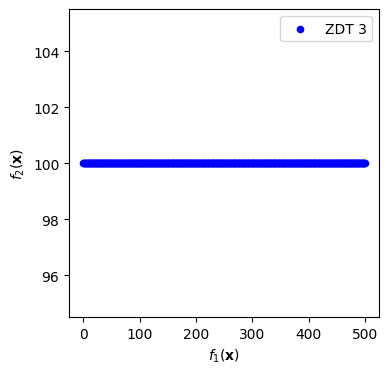

In [85]:
plot_colors = ('b','r', 'g', 'm', 'y', 'k', 'c')
fig, ax = plt.subplots(1, figsize=(4,4))

df.plot(ax=ax, kind='scatter', label='ZDT 3', 
        x=df.columns[0], y=df.columns[1], 
        color=plot_colors[i % len(plot_colors)])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

In [31]:
for index in range(1, 11):
    toolbox.register("select", tools.selNSGA3, ref_points=ref_points)
    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"
    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_iii(toolbox=toolbox,seed=index,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga3_zdt3_100_500_2_5-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga3_zdt3_100_500_2_5-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)
    

Iteration 1
gen	evals	Tiempo   
1  	     	0.0130072
2  	     	0.018708 
3  	     	0.0249617
4  	     	0.0321376
5  	     	0.033988 
6  	     	0.0430439
7  	     	0.0430439
8  	     	0.052249 
9  	     	0.0573094
10 	     	0.0573094
11 	     	0.0659723
12 	     	0.0735552
13 	     	0.0735552
14 	     	0.080107 
15 	     	0.080107 
16 	     	0.0904994
17 	     	0.0904994
18 	     	0.0993419
19 	     	0.0993419
20 	     	0.0993419
21 	     	0.0993419
22 	     	0.126033 
23 	     	0.134784 
24 	     	0.141487 
25 	     	0.157317 
26 	     	0.166078 
27 	     	0.175992 
28 	     	0.182863 
29 	     	0.187342 
30 	     	0.191808 
31 	     	0.199826 
32 	     	0.205777 
33 	     	0.212116 
34 	     	0.221365 
35 	     	0.227834 
36 	     	0.227834 
37 	     	0.235725 
38 	     	0.247396 
39 	     	0.247396 
40 	     	0.257073 
41 	     	0.268362 
42 	     	0.28372  
43 	     	0.289989 
44 	     	0.294885 
45 	     	0.294885 
46 	     	0.308021 
47 	     	0.308021 
48 	     	0.323696 
49 	    

439	     	3.20812  
440	     	3.22321  
441	     	3.23421  
442	     	3.24157  
443	     	3.24256  
444	     	3.24256  
445	     	3.25805  
446	     	3.26611  
447	     	3.27377  
448	     	3.27377  
449	     	3.28484  
450	     	3.29135  
451	     	3.29135  
452	     	3.29135  
453	     	3.30807  
454	     	3.30807  
455	     	3.30807  
456	     	3.32486  
457	     	3.32486  
458	     	3.32486  
459	     	3.34159  
460	     	3.34159  
461	     	3.34159  
462	     	3.35836  
463	     	3.35836  
464	     	3.35836  
465	     	3.37518  
466	     	3.37518  
467	     	3.39028  
468	     	3.3916   
469	     	3.39875  
470	     	3.4111   
471	     	3.4111   
472	     	3.42335  
473	     	3.43054  
474	     	3.43328  
475	     	3.44317  
476	     	3.45188  
477	     	3.4568   
478	     	3.46484  
479	     	3.46484  
480	     	3.47372  
481	     	3.4818   
482	     	3.4903   
483	     	3.49126  
484	     	3.49126  
485	     	3.50878  
486	     	3.50878  
487	     	3.50878  
488	     	3.52553  


366	     	2.66193  
367	     	2.66826  
368	     	2.6778   
369	     	2.69076  
370	     	2.69275  
371	     	2.70474  
372	     	2.70677  
373	     	2.71739  
374	     	2.72296  
375	     	2.73091  
376	     	2.73523  
377	     	2.74329  
378	     	2.74329  
379	     	2.7509   
380	     	2.75896  
381	     	2.76749  
382	     	2.76749  
383	     	2.76749  
384	     	2.78703  
385	     	2.78703  
386	     	2.80186  
387	     	2.80186  
388	     	2.80991  
389	     	2.81885  
390	     	2.8267   
391	     	2.83443  
392	     	2.83537  
393	     	2.84228  
394	     	2.85467  
395	     	2.8587   
396	     	2.8685   
397	     	2.87629  
398	     	2.88766  
399	     	2.8963   
400	     	2.90459  
401	     	2.91088  
402	     	2.91802  
403	     	2.92116  
404	     	2.93442  
405	     	2.94283  
406	     	2.94984  
407	     	2.95245  
408	     	2.95899  
409	     	2.96968  
410	     	2.96968  
411	     	2.97774  
412	     	2.9853   
413	     	2.9853   
414	     	2.9853   
415	     	3.00177  


252	     	1.81528    
253	     	1.82608    
254	     	1.83528    
255	     	1.83528    
256	     	1.84826    
257	     	1.85631    
258	     	1.85631    
259	     	1.86531    
260	     	1.87337    
261	     	1.88079    
262	     	1.88185    
263	     	1.88185    
264	     	1.89754    
265	     	1.89854    
266	     	1.89854    
267	     	1.91526    
268	     	1.91526    
269	     	1.91526    
270	     	1.93201    
271	     	1.93201    
272	     	1.93201    
273	     	1.94873    
274	     	1.95383    
275	     	1.95383    
276	     	1.95383    
277	     	1.96951    
278	     	1.96951    
279	     	1.9853     
280	     	1.98733    
281	     	2.00076    
282	     	2.00178    
283	     	2.00178    
284	     	2.01865    
285	     	2.01964    
286	     	2.01964    
287	     	2.03639    
288	     	2.04505    
289	     	2.05528    
290	     	2.05528    
291	     	2.06745    
292	     	2.08077    
293	     	2.08077    
294	     	2.08984    
295	     	2.09719    
296	     	2.09719    
297	     	

141	     	0.980559  
142	     	0.991114  
143	     	1.00038   
144	     	1.00826   
145	     	1.02288   
146	     	1.0364    
147	     	1.04362   
148	     	1.05264   
149	     	1.05888   
150	     	1.07343   
151	     	1.0852    
152	     	1.09962   
153	     	1.11673   
154	     	1.12574   
155	     	1.13411   
156	     	1.14888   
157	     	1.15096   
158	     	1.1664    
159	     	1.1664    
160	     	1.18387   
161	     	1.19311   
162	     	1.20488   
163	     	1.21319   
164	     	1.2219    
165	     	1.22921   
166	     	1.23497   
167	     	1.23497   
168	     	1.25181   
169	     	1.25855   
170	     	1.26683   
171	     	1.28383   
172	     	1.29061   
173	     	1.29691   
174	     	1.30512   
175	     	1.30612   
176	     	1.31747   
177	     	1.32967   
178	     	1.33963   
179	     	1.34888   
180	     	1.35151   
181	     	1.35923   
182	     	1.3702    
183	     	1.37654   
184	     	1.38526   
185	     	1.39123   
186	     	1.39326   
187	     	1.40528   
188	     	1.4

53 	     	0.319183  
54 	     	0.329526  
55 	     	0.333639  
56 	     	0.340688  
57 	     	0.350404  
58 	     	0.361668  
59 	     	0.36999   
60 	     	0.379753  
61 	     	0.386461  
62 	     	0.394735  
63 	     	0.402736  
64 	     	0.415825  
65 	     	0.415825  
66 	     	0.423878  
67 	     	0.429581  
68 	     	0.437711  
69 	     	0.445115  
70 	     	0.446151  
71 	     	0.446151  
72 	     	0.462776  
73 	     	0.463773  
74 	     	0.463773  
75 	     	0.479496  
76 	     	0.486795  
77 	     	0.48779   
78 	     	0.497212  
79 	     	0.505579  
80 	     	0.51276   
81 	     	0.51276   
82 	     	0.520492  
83 	     	0.529259  
84 	     	0.536117  
85 	     	0.540017  
86 	     	0.549755  
87 	     	0.558664  
88 	     	0.564665  
89 	     	0.572719  
90 	     	0.578746  
91 	     	0.579778  
92 	     	0.590702  
93 	     	0.596262  
94 	     	0.596262  
95 	     	0.596262  
96 	     	0.612993  
97 	     	0.612993  
98 	     	0.628627  
99 	     	0.63033   
100	     	0.6

460	     	3.39111   
461	     	3.4012    
462	     	3.41305   
463	     	3.42106   
464	     	3.43125   
465	     	3.43789   
466	     	3.44647   
467	     	3.44747   
468	     	3.4567    
469	     	3.46418   
470	     	3.46518   
471	     	3.47638   
472	     	3.47939   
473	     	3.47939   
474	     	3.49521   
475	     	3.49624   
476	     	3.49624   
477	     	3.51192   
478	     	3.51295   
479	     	3.51295   
480	     	3.52866   
481	     	3.5297    
482	     	3.5297    
483	     	3.54544   
484	     	3.54648   
485	     	3.54648   
486	     	3.5622    
487	     	3.56529   
488	     	3.56529   
489	     	3.56529   
490	     	3.58096   
491	     	3.58096   
492	     	3.58096   
493	     	3.60487   
494	     	3.61346   
495	     	3.61346   
496	     	3.62329   
497	     	3.63017   
498	     	3.63937   
499	     	3.645     
500	     	3.646     
Iteration 6
gen	evals	Tiempo
1  	     	0     
2  	     	0.0167878
3  	     	0.0354192
4  	     	0.0354192
5  	     	0.0354192
6  	     	0.0

377	     	2.52091  
378	     	2.53348  
379	     	2.54105  
380	     	2.54786  
381	     	2.54786  
382	     	2.55598  
383	     	2.5648   
384	     	2.5648   
385	     	2.57285  
386	     	2.58132  
387	     	2.58132  
388	     	2.58132  
389	     	2.59818  
390	     	2.59818  
391	     	2.59818  
392	     	2.61483  
393	     	2.61483  
394	     	2.61483  
395	     	2.63153  
396	     	2.63153  
397	     	2.64721  
398	     	2.6483   
399	     	2.6483   
400	     	2.66503  
401	     	2.67245  
402	     	2.67444  
403	     	2.68263  
404	     	2.68263  
405	     	2.69942  
406	     	2.69942  
407	     	2.71613  
408	     	2.71613  
409	     	2.71613  
410	     	2.73494  
411	     	2.75104  
412	     	2.75325  
413	     	2.7634   
414	     	2.76552  
415	     	2.77358  
416	     	2.78152  
417	     	2.78683  
418	     	2.78683  
419	     	2.79895  
420	     	2.79895  
421	     	2.80706  
422	     	2.80706  
423	     	2.82588  
424	     	2.83446  
425	     	2.83546  
426	     	2.85047  


275	     	1.90459   
276	     	1.91653   
277	     	1.92716   
278	     	1.92816   
279	     	1.93622   
280	     	1.94528   
281	     	1.94732   
282	     	1.95533   
283	     	1.96166   
284	     	1.97088   
285	     	1.97088   
286	     	1.97088   
287	     	1.98774   
288	     	1.98774   
289	     	2.00341   
290	     	2.00341   
291	     	2.00341   
292	     	2.01903   
293	     	2.01903   
294	     	2.01903   
295	     	2.03466   
296	     	2.03466   
297	     	2.04771   
298	     	2.04771   
299	     	2.04771   
300	     	2.06337   
301	     	2.06337   
302	     	2.079     
303	     	2.08011   
304	     	2.08807   
305	     	2.09535   
306	     	2.09535   
307	     	2.11209   
308	     	2.12403   
309	     	2.13286   
310	     	2.13286   
311	     	2.14802   
312	     	2.14802   
313	     	2.16196   
314	     	2.16196   
315	     	2.17001   
316	     	2.17852   
317	     	2.17852   
318	     	2.17852   
319	     	2.19628   
320	     	2.19628   
321	     	2.19628   
322	     	2.2

167	     	1.0923    
168	     	1.10422   
169	     	1.12064   
170	     	1.13464   
171	     	1.13564   
172	     	1.14366   
173	     	1.15354   
174	     	1.15453   
175	     	1.16159   
176	     	1.16883   
177	     	1.16883   
178	     	1.16883   
179	     	1.18653   
180	     	1.18653   
181	     	1.20259   
182	     	1.20259   
183	     	1.22897   
184	     	1.23669   
185	     	1.25364   
186	     	1.26255   
187	     	1.28517   
188	     	1.29626   
189	     	1.30762   
190	     	1.31775   
191	     	1.32896   
192	     	1.33801   
193	     	1.34922   
194	     	1.35228   
195	     	1.36184   
196	     	1.36784   
197	     	1.3689    
198	     	1.3689    
199	     	1.38571   
200	     	1.38571   
201	     	1.38571   
202	     	1.40241   
203	     	1.40241   
204	     	1.40241   
205	     	1.41914   
206	     	1.41914   
207	     	1.41914   
208	     	1.43587   
209	     	1.43587   
210	     	1.43587   
211	     	1.45262   
212	     	1.45262   
213	     	1.46427   
214	     	1.4

58 	     	0.367459  
59 	     	0.379925  
60 	     	0.387861  
61 	     	0.387861  
62 	     	0.401269  
63 	     	0.403988  
64 	     	0.41278   
65 	     	0.418001  
66 	     	0.426011  
67 	     	0.426011  
68 	     	0.435206  
69 	     	0.435206  
70 	     	0.435206  
71 	     	0.451221  
72 	     	0.451221  
73 	     	0.46806   
74 	     	0.480782  
75 	     	0.491934  
76 	     	0.493928  
77 	     	0.501059  
78 	     	0.510018  
79 	     	0.519434  
80 	     	0.534683  
81 	     	0.542786  
82 	     	0.543781  
83 	     	0.543781  
84 	     	0.559447  
85 	     	0.559447  
86 	     	0.559447  
87 	     	0.57507   
88 	     	0.585485  
89 	     	0.593458  
90 	     	0.601593  
91 	     	0.603589  
92 	     	0.603589  
93 	     	0.621147  
94 	     	0.628764  
95 	     	0.634577  
96 	     	0.645536  
97 	     	0.65904   
98 	     	0.668888  
99 	     	0.679971  
100	     	0.68562   
101	     	0.68767   
102	     	0.695727  
103	     	0.70147   
104	     	0.709522  
105	     	0.7

473	     	3.22787   
474	     	3.24102   
475	     	3.25119   
476	     	3.25119   
477	     	3.26069   
478	     	3.26779   
479	     	3.27584   
480	     	3.28334   
481	     	3.28945   
482	     	3.28945   
483	     	3.28945   
484	     	3.30635   
485	     	3.30635   
486	     	3.30635   
487	     	3.32203   
488	     	3.32203   
489	     	3.33766   
490	     	3.33766   
491	     	3.35328   
492	     	3.35328   
493	     	3.35328   
494	     	3.3689    
495	     	3.3689    
496	     	3.3689    
497	     	3.38559   
498	     	3.38965   
499	     	3.38965   
500	     	3.38965   
Iteration 10
gen	evals	Tiempo    
1  	     	0.00338435
2  	     	0.00338435
3  	     	0.00338435
4  	     	0.0192294 
5  	     	0.0244129 
6  	     	0.0361171 
7  	     	0.0381119 
8  	     	0.0461609 
9  	     	0.0546231 
10 	     	0.0546231 
11 	     	0.0626721 
12 	     	0.0701394 
13 	     	0.0756924 
14 	     	0.0756924 
15 	     	0.0874877 
16 	     	0.0874877 
17 	     	0.0954976 
18 	     	0.10459   


384	     	2.64097   
385	     	2.65321   
386	     	2.6604    
387	     	2.6604    
388	     	2.66985   
389	     	2.6779    
390	     	2.6779    
391	     	2.68691   
392	     	2.69492   
393	     	2.70227   
394	     	2.70441   
395	     	2.70441   
396	     	2.72116   
397	     	2.72116   
398	     	2.73446   
399	     	2.74147   
400	     	2.74412   
401	     	2.75428   
402	     	2.7563    
403	     	2.7563    
404	     	2.77262   
405	     	2.77693   
406	     	2.77693   
407	     	2.78704   
408	     	2.78704   
409	     	2.78704   
410	     	2.80378   
411	     	2.80378   
412	     	2.81951   
413	     	2.82054   
414	     	2.82054   
415	     	2.8363    
416	     	2.8363    
417	     	2.8363    
418	     	2.85398   
419	     	2.86424   
420	     	2.87183   
421	     	2.87183   
422	     	2.87183   
423	     	2.89222   
424	     	2.8943    
425	     	2.90316   
426	     	2.90815   
427	     	2.91903   
428	     	2.92703   
429	     	2.92703   
430	     	2.9363    
431	     	2.9

## ZDT 4

In [32]:
NDIM = 7

In [33]:
for index in range(1, 11):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
    creator.create("Individual", list, fitness=creator.FitnessMin) 

    toolbox = base.Toolbox()

    toolbox.register("evaluate", zdt4) #Fitness Function

    #Chromosome representation Real Valued
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    # Initialize statistics object
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"
    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_ii(toolbox=toolbox, seed=index, stats=stats, verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga2_zdt4_100_500_2_7-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga2_zdt4_100_500_2_7-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 1
gen	evals	Tiempo   
1  	     	0.0747461
2  	     	0.112578 
3  	     	0.140126 
4  	     	0.158892 
5  	     	0.191249 
6  	     	0.208072 
7  	     	0.224783 
8  	     	0.242402 
9  	     	0.270371 
10 	     	0.299294 
11 	     	0.33575  
12 	     	0.361112 
13 	     	0.403234 
14 	     	0.41673  
15 	     	0.439984 
16 	     	0.459373 
17 	     	0.476327 
18 	     	0.497503 
19 	     	0.529471 
20 	     	0.532464 
21 	     	0.574073 
22 	     	0.580791 
23 	     	0.606813 
24 	     	0.62366  
25 	     	0.642714 
26 	     	0.658233 
27 	     	0.658233 
28 	     	0.674999 
29 	     	0.691767 
30 	     	0.716773 
31 	     	0.740155 
32 	     	0.758214 
33 	     	0.774382 
34 	     	0.790137 
35 	     	0.806884 
36 	     	0.830315 
37 	     	0.859124 
38 	     	0.891783 
39 	     	0.929328 
40 	     	0.959456 
41 	     	0.984654 
42 	     	0.996875 
43 	     	1.01699  
44 	     	1.03539  
45 	     	1.04194  
46 	     	1.07075  
47 	     	1.08881  
48 	     	1.09382  
49 	    

427	     	9.64971  
428	     	9.6665   
429	     	9.70031  
430	     	9.7228   
431	     	9.73089  
432	     	9.74785  
433	     	9.76458  
434	     	9.78025  
435	     	9.7953   
436	     	9.81097  
437	     	9.82768  
438	     	9.84335  
439	     	9.84335  
440	     	9.85898  
441	     	9.87459  
442	     	9.89749  
443	     	9.92141  
444	     	9.9432   
445	     	9.95858  
446	     	9.98447  
447	     	9.99867  
448	     	10.0146  
449	     	10.0262  
450	     	10.0418  
451	     	10.0574  
452	     	10.0747  
453	     	10.0915  
454	     	10.1117  
455	     	10.1397  
456	     	10.1552  
457	     	10.1798  
458	     	10.1896  
459	     	10.2146  
460	     	10.2261  
461	     	10.2429  
462	     	10.2649  
463	     	10.2831  
464	     	10.2977  
465	     	10.3063  
466	     	10.3265  
467	     	10.3397  
468	     	10.3574  
469	     	10.374   
470	     	10.4076  
471	     	10.4398  
472	     	10.4565  
473	     	10.4738  
474	     	10.4898  
475	     	10.5064  
476	     	10.5231  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	evals	Tiempo   
1  	     	0.0918655
2  	     	0.176053 
3  	     	0.20583  
4  	     	0.238648 
5  	     	0.265114 
6  	     	0.285535 
7  	     	0.329698 
8  	     	0.344808 
9  	     	0.370926 
10 	     	0.378497 
11 	     	0.427213 
12 	     	0.444942 
13 	     	0.460657 
14 	     	0.477571 
15 	     	0.496902 
16 	     	0.512572 
17 	     	0.529248 
18 	     	0.544878 
19 	     	0.561529 
20 	     	0.593811 
21 	     	0.611525 
22 	     	0.627371 
23 	     	0.64511  
24 	     	0.664175 
25 	     	0.687014 
26 	     	0.696834 
27 	     	0.720604 
28 	     	0.731672 
29 	     	0.751916 
30 	     	0.76754  
31 	     	0.784338 
32 	     	0.796387 
33 	     	0.796387 
34 	     	0.814139 
35 	     	0.8311   
36 	     	0.854823 
37 	     	0.863713 
38 	     	0.886327 
39 	     	0.896577 
40 	     	0.910594 
41 	     	0.919787 
42 	     	0.928106 
43 	     	0.961411 
44 	     	0.984424 
45 	     	1.00468  
46 	     	1.03771  
47 	     	1.06502  
48 	     	1.09505  
49 	     	1.09765  


421	     	8.76757  
422	     	8.78324  
423	     	8.80403  
424	     	8.82146  
425	     	8.83835  
426	     	8.84592  
427	     	8.86267  
428	     	8.89595  
429	     	8.904    
430	     	8.94257  
431	     	8.96107  
432	     	8.97694  
433	     	8.99248  
434	     	9.01099  
435	     	9.02791  
436	     	9.05159  
437	     	9.06115  
438	     	9.07782  
439	     	9.10408  
440	     	9.12814  
441	     	9.15578  
442	     	9.17892  
443	     	9.197    
444	     	9.21925  
445	     	9.23988  
446	     	9.24777  
447	     	9.26553  
448	     	9.28234  
449	     	9.30405  
450	     	9.31694  
451	     	9.33366  
452	     	9.34891  
453	     	9.36809  
454	     	9.39227  
455	     	9.40927  
456	     	9.42802  
457	     	9.43798  
458	     	9.46629  
459	     	9.49756  
460	     	9.51875  
461	     	9.54425  
462	     	9.56025  
463	     	9.57686  
464	     	9.58896  
465	     	9.61014  
466	     	9.62687  
467	     	9.64362  
468	     	9.66038  
469	     	9.68587  
470	     	9.69443  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


9  	     	0.219128  
10 	     	0.224142  
11 	     	0.248296  
12 	     	0.271658  
13 	     	0.287647  
14 	     	0.289641  
15 	     	0.306248  
16 	     	0.32301   
17 	     	0.340414  
18 	     	0.374474  
19 	     	0.389453  
20 	     	0.406564  
21 	     	0.427606  
22 	     	0.448765  
23 	     	0.466357  
24 	     	0.482749  
25 	     	0.508464  
26 	     	0.522631  
27 	     	0.548976  
28 	     	0.573321  
29 	     	0.590474  
30 	     	0.606659  
31 	     	0.623417  
32 	     	0.643817  
33 	     	0.661751  
34 	     	0.680317  
35 	     	0.697369  
36 	     	0.722604  
37 	     	0.73924   
38 	     	0.755994  
39 	     	0.772716  
40 	     	0.78846   
41 	     	0.805665  
42 	     	0.823753  
43 	     	0.839223  
44 	     	0.856027  
45 	     	0.873673  
46 	     	0.873673  
47 	     	0.906653  
48 	     	0.923406  
49 	     	0.955989  
50 	     	0.97283   
51 	     	0.97283   
52 	     	0.991723  
53 	     	1.01395   
54 	     	1.0494    
55 	     	1.08108   
56 	     	1.1

414	     	7.90463   
415	     	7.90563   
416	     	7.9415    
417	     	7.95542   
418	     	7.97941   
419	     	7.99095   
420	     	8.00774   
421	     	8.02338   
422	     	8.04012   
423	     	8.05688   
424	     	8.07362   
425	     	8.07362   
426	     	8.09043   
427	     	8.10718   
428	     	8.12227   
429	     	8.13897   
430	     	8.15675   
431	     	8.17348   
432	     	8.19024   
433	     	8.20699   
434	     	8.22374   
435	     	8.23949   
436	     	8.25969   
437	     	8.2733    
438	     	8.28897   
439	     	8.30557   
440	     	8.30557   
441	     	8.32108   
442	     	8.33882   
443	     	8.35449   
444	     	8.3723    
445	     	8.39023   
446	     	8.4055    
447	     	8.41739   
448	     	8.42218   
449	     	8.43899   
450	     	8.45569   
451	     	8.47241   
452	     	8.4892    
453	     	8.50596   
454	     	8.52355   
455	     	8.52355   
456	     	8.55536   
457	     	8.5723    
458	     	8.58034   
459	     	8.58891   
460	     	8.60567   
461	     	8.6

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


5  	     	0.097579 
6  	     	0.117991 
7  	     	0.139117 
8  	     	0.157671 
9  	     	0.173851 
10 	     	0.187965 
11 	     	0.196565 
12 	     	0.229929 
13 	     	0.247241 
14 	     	0.263968 
15 	     	0.280715 
16 	     	0.314286 
17 	     	0.339082 
18 	     	0.355983 
19 	     	0.372612 
20 	     	0.397299 
21 	     	0.416159 
22 	     	0.430916 
23 	     	0.452298 
24 	     	0.469079 
25 	     	0.506464 
26 	     	0.521251 
27 	     	0.538245 
28 	     	0.548776 
29 	     	0.563529 
30 	     	0.580298 
31 	     	0.597041 
32 	     	0.613759 
33 	     	0.63045  
34 	     	0.648798 
35 	     	0.665764 
36 	     	0.68144  
37 	     	0.700134 
38 	     	0.713362 
39 	     	0.730052 
40 	     	0.748679 
41 	     	0.765472 
42 	     	0.802225 
43 	     	0.814016 
44 	     	0.832098 
45 	     	0.84974  
46 	     	0.867622 
47 	     	0.867622 
48 	     	0.883291 
49 	     	0.900007 
50 	     	0.915682 
51 	     	0.931264 
52 	     	0.948535 
53 	     	0.966353 
54 	     	1.00567  


427	     	8.61729  
428	     	8.63983  
429	     	8.66379  
430	     	8.69329  
431	     	8.71291  
432	     	8.71291  
433	     	8.7405   
434	     	8.76291  
435	     	8.78582  
436	     	8.80148  
437	     	8.82856  
438	     	8.84988  
439	     	8.86419  
440	     	8.8834   
441	     	8.90385  
442	     	8.92173  
443	     	8.95294  
444	     	8.97971  
445	     	9.00462  
446	     	9.02091  
447	     	9.04125  
448	     	9.05436  
449	     	9.06474  
450	     	9.08771  
451	     	9.09641  
452	     	9.11393  
453	     	9.13504  
454	     	9.15098  
455	     	9.16305  
456	     	9.18473  
457	     	9.20532  
458	     	9.22434  
459	     	9.24601  
460	     	9.27197  
461	     	9.29759  
462	     	9.31308  
463	     	9.3298   
464	     	9.34656  
465	     	9.36318  
466	     	9.37995  
467	     	9.41246  
468	     	9.43023  
469	     	9.45275  
470	     	9.47127  
471	     	9.47972  
472	     	9.51189  
473	     	9.54287  
474	     	9.56338  
475	     	9.58072  
476	     	9.59714  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 5
gen	evals	Tiempo   
1  	     	0.0148556
2  	     	0.0496225
3  	     	0.0710204
4  	     	0.0896125
5  	     	0.105416 
6  	     	0.114983 
7  	     	0.131749 
8  	     	0.148485 
9  	     	0.165258 
10 	     	0.182055 
11 	     	0.210882 
12 	     	0.24041  
13 	     	0.264258 
14 	     	0.280349 
15 	     	0.298372 
16 	     	0.325327 
17 	     	0.340034 
18 	     	0.365085 
19 	     	0.375266 
20 	     	0.397146 
21 	     	0.414798 
22 	     	0.450896 
23 	     	0.479645 
24 	     	0.498149 
25 	     	0.520263 
26 	     	0.537147 
27 	     	0.552776 
28 	     	0.587197 
29 	     	0.605828 
30 	     	0.622588 
31 	     	0.648121 
32 	     	0.681417 
33 	     	0.76535  
34 	     	0.806675 
35 	     	0.834022 
36 	     	0.851443 
37 	     	0.902456 
38 	     	0.9147   
39 	     	0.934227 
40 	     	0.947066 
41 	     	0.956652 
42 	     	0.973377 
43 	     	0.989049 
44 	     	1.03055  
45 	     	1.05383  
46 	     	1.08133  
47 	     	1.11042  
48 	     	1.14115  
49 	    

411	     	8.39818  
412	     	8.41495  
413	     	8.4485   
414	     	8.46328  
415	     	8.48029  
416	     	8.49689  
417	     	8.51438  
418	     	8.53848  
419	     	8.56057  
420	     	8.57869  
421	     	8.60691  
422	     	8.62067  
423	     	8.63757  
424	     	8.64807  
425	     	8.66574  
426	     	8.68247  
427	     	8.69925  
428	     	8.69925  
429	     	8.73406  
430	     	8.75212  
431	     	8.76963  
432	     	8.78093  
433	     	8.79691  
434	     	8.81549  
435	     	8.81549  
436	     	8.83236  
437	     	8.84805  
438	     	8.86476  
439	     	8.88151  
440	     	8.90602  
441	     	8.92288  
442	     	8.94816  
443	     	8.94816  
444	     	8.96489  
445	     	8.98228  
446	     	9.00044  
447	     	9.01613  
448	     	9.03296  
449	     	9.03296  
450	     	9.04972  
451	     	9.07062  
452	     	9.08846  
453	     	9.11851  
454	     	9.16344  
455	     	9.18989  
456	     	9.20063  
457	     	9.22599  
458	     	9.24717  
459	     	9.24917  
460	     	9.28155  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


8  	     	0.224794 
9  	     	0.242546 
10 	     	0.257269 
11 	     	0.279698 
12 	     	0.297503 
13 	     	0.308557 
14 	     	0.340271 
15 	     	0.35736  
16 	     	0.375195 
17 	     	0.390232 
18 	     	0.416855 
19 	     	0.43187  
20 	     	0.447493 
21 	     	0.463112 
22 	     	0.486899 
23 	     	0.509148 
24 	     	0.524817 
25 	     	0.545236 
26 	     	0.557097 
27 	     	0.574492 
28 	     	0.591364 
29 	     	0.609051 
30 	     	0.62376  
31 	     	0.65455  
32 	     	0.677514 
33 	     	0.701706 
34 	     	0.70893  
35 	     	0.724735 
36 	     	0.742135 
37 	     	0.7609   
38 	     	0.778473 
39 	     	0.778473 
40 	     	0.79415  
41 	     	0.82255  
42 	     	0.827007 
43 	     	0.841218 
44 	     	0.867529 
45 	     	0.891394 
46 	     	0.923546 
47 	     	0.941273 
48 	     	0.957221 
49 	     	0.965273 
50 	     	0.973763 
51 	     	0.992707 
52 	     	1.00925  
53 	     	1.00925  
54 	     	1.02935  
55 	     	1.05641  
56 	     	1.0737   
57 	     	1.0925   


421	     	8.49007  
422	     	8.49231  
423	     	8.50798  
424	     	8.54186  
425	     	8.56548  
426	     	8.57527  
427	     	8.59018  
428	     	8.60874  
429	     	8.62442  
430	     	8.62442  
431	     	8.65876  
432	     	8.67611  
433	     	8.69178  
434	     	8.70847  
435	     	8.7242   
436	     	8.74423  
437	     	8.75883  
438	     	8.77325  
439	     	8.79008  
440	     	8.79008  
441	     	8.8105   
442	     	8.82614  
443	     	8.86097  
444	     	8.90821  
445	     	8.94584  
446	     	8.95785  
447	     	8.97666  
448	     	8.99347  
449	     	9.0091   
450	     	9.02418  
451	     	9.04508  
452	     	9.06032  
453	     	9.07596  
454	     	9.10853  
455	     	9.12328  
456	     	9.13907  
457	     	9.15825  
458	     	9.16863  
459	     	9.19992  
460	     	9.21669  
461	     	9.23997  
462	     	9.26143  
463	     	9.27868  
464	     	9.30155  
465	     	9.32305  
466	     	9.34212  
467	     	9.35016  
468	     	9.37036  
469	     	9.38346  
470	     	9.40376  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


2  	     	0.0518975 
3  	     	0.0696383 
4  	     	0.0864141 
5  	     	0.105243  
6  	     	0.120915  
7  	     	0.151629  
8  	     	0.169322  
9  	     	0.185185  
10 	     	0.204463  
11 	     	0.222226  
12 	     	0.237902  
13 	     	0.254637  
14 	     	0.271443  
15 	     	0.304394  
16 	     	0.32006   
17 	     	0.341319  
18 	     	0.360764  
19 	     	0.383998  
20 	     	0.404283  
21 	     	0.418487  
22 	     	0.435157  
23 	     	0.452863  
24 	     	0.469633  
25 	     	0.486375  
26 	     	0.505291  
27 	     	0.533996  
28 	     	0.551809  
29 	     	0.551809  
30 	     	0.584893  
31 	     	0.604576  
32 	     	0.605613  
33 	     	0.634911  
34 	     	0.651806  
35 	     	0.669648  
36 	     	0.686356  
37 	     	0.686356  
38 	     	0.718347  
39 	     	0.735131  
40 	     	0.752743  
41 	     	0.752743  
42 	     	0.785218  
43 	     	0.805609  
44 	     	0.805609  
45 	     	0.821283  
46 	     	0.838087  
47 	     	0.869436  
48 	     	0.870433  
49 	     	0.9

405	     	8.03366   
406	     	8.05139   
407	     	8.0671    
408	     	8.08736   
409	     	8.1029    
410	     	8.11922   
411	     	8.13487   
412	     	8.15239   
413	     	8.16914   
414	     	8.18508   
415	     	8.20184   
416	     	8.21858   
417	     	8.23474   
418	     	8.25146   
419	     	8.25146   
420	     	8.2849    
421	     	8.30162   
422	     	8.32118   
423	     	8.33473   
424	     	8.3693    
425	     	8.39123   
426	     	8.41355   
427	     	8.42728   
428	     	8.43485   
429	     	8.46223   
430	     	8.47598   
431	     	8.4894    
432	     	8.50723   
433	     	8.536     
434	     	8.5514    
435	     	8.56811   
436	     	8.58478   
437	     	8.60146   
438	     	8.62001   
439	     	8.63615   
440	     	8.65796   
441	     	8.69399   
442	     	8.7179    
443	     	8.73501   
444	     	8.75176   
445	     	8.76851   
446	     	8.78527   
447	     	8.78527   
448	     	8.80199   
449	     	8.83431   
450	     	8.8353    
451	     	8.85301   
452	     	8.8

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 8
gen	evals	Tiempo   
1  	     	0.0651133
2  	     	0.145247 
3  	     	0.181499 
4  	     	0.208784 
5  	     	0.23614  
6  	     	0.254738 
7  	     	0.26912  
8  	     	0.277323 
9  	     	0.312883 
10 	     	0.327055 
11 	     	0.353228 
12 	     	0.377943 
13 	     	0.40239  
14 	     	0.410891 
15 	     	0.445588 
16 	     	0.45999  
17 	     	0.476626 
18 	     	0.493363 
19 	     	0.510034 
20 	     	0.526742 
21 	     	0.537954 
22 	     	0.561903 
23 	     	0.576576 
24 	     	0.594277 
25 	     	0.611107 
26 	     	0.627828 
27 	     	0.65381  
28 	     	0.682689 
29 	     	0.711214 
30 	     	0.735865 
31 	     	0.759689 
32 	     	0.784987 
33 	     	0.801244 
34 	     	0.819293 
35 	     	0.845054 
36 	     	0.864357 
37 	     	0.886438 
38 	     	0.902686 
39 	     	0.919232 
40 	     	0.943158 
41 	     	0.970521 
42 	     	1.00507  
43 	     	1.03672  
44 	     	1.07857  
45 	     	1.10964  
46 	     	1.11878  
47 	     	1.21159  
48 	     	1.27269  
49 	    

416	     	8.99927  
417	     	9.01527  
418	     	9.0357   
419	     	9.05469  
420	     	9.07758  
421	     	9.09853  
422	     	9.11453  
423	     	9.12887  
424	     	9.14703  
425	     	9.18433  
426	     	9.21296  
427	     	9.22962  
428	     	9.24674  
429	     	9.2659   
430	     	9.28714  
431	     	9.3132   
432	     	9.34148  
433	     	9.36279  
434	     	9.38307  
435	     	9.40105  
436	     	9.42692  
437	     	9.44581  
438	     	9.46313  
439	     	9.48301  
440	     	9.5036   
441	     	9.52583  
442	     	9.54257  
443	     	9.55934  
444	     	9.5732   
445	     	9.59016  
446	     	9.61003  
447	     	9.62591  
448	     	9.64142  
449	     	9.65556  
450	     	9.67512  
451	     	9.69345  
452	     	9.70921  
453	     	9.73084  
454	     	9.74657  
455	     	9.7683   
456	     	9.78492  
457	     	9.80059  
458	     	9.81472  
459	     	9.83509  
460	     	9.85705  
461	     	9.8731   
462	     	9.89364  
463	     	9.90925  
464	     	9.92288  
465	     	9.93703  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


5  	     	0.151513 
6  	     	0.177242 
7  	     	0.202972 
8  	     	0.224489 
9  	     	0.24453  
10 	     	0.261084 
11 	     	0.29366  
12 	     	0.318482 
13 	     	0.343534 
14 	     	0.364055 
15 	     	0.380744 
16 	     	0.401409 
17 	     	0.423841 
18 	     	0.443558 
19 	     	0.457014 
20 	     	0.471169 
21 	     	0.50338  
22 	     	0.523357 
23 	     	0.553068 
24 	     	0.578098 
25 	     	0.599323 
26 	     	0.615323 
27 	     	0.632629 
28 	     	0.651567 
29 	     	0.67088  
30 	     	0.68866  
31 	     	0.707307 
32 	     	0.719312 
33 	     	0.735309 
34 	     	0.752924 
35 	     	0.77652  
36 	     	0.793357 
37 	     	0.805425 
38 	     	0.824904 
39 	     	0.840543 
40 	     	0.855725 
41 	     	0.87298  
42 	     	0.884979 
43 	     	0.901301 
44 	     	0.91871  
45 	     	0.949727 
46 	     	0.964893 
47 	     	0.987262 
48 	     	1.01233  
49 	     	1.03353  
50 	     	1.05066  
51 	     	1.06803  
52 	     	1.08116  
53 	     	1.09763  
54 	     	1.11038  


421	     	8.89922  
422	     	8.91662  
423	     	8.93253  
424	     	8.95237  
425	     	8.96601  
426	     	8.98558  
427	     	9.00262  
428	     	9.02347  
429	     	9.0429   
430	     	9.05658  
431	     	9.07739  
432	     	9.09605  
433	     	9.11062  
434	     	9.12765  
435	     	9.14319  
436	     	9.15963  
437	     	9.17463  
438	     	9.19917  
439	     	9.21768  
440	     	9.23767  
441	     	9.25637  
442	     	9.27245  
443	     	9.28742  
444	     	9.3024   
445	     	9.32267  
446	     	9.3454   
447	     	9.36492  
448	     	9.37629  
449	     	9.39311  
450	     	9.41312  
451	     	9.42934  
452	     	9.44796  
453	     	9.46333  
454	     	9.47728  
455	     	9.49436  
456	     	9.50968  
457	     	9.52825  
458	     	9.54427  
459	     	9.56268  
460	     	9.57724  
461	     	9.59445  
462	     	9.61055  
463	     	9.63342  
464	     	9.65122  
465	     	9.66945  
466	     	9.68681  
467	     	9.70318  
468	     	9.71968  
469	     	9.737    
470	     	9.7521   


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 10
gen	evals	Tiempo   
1  	     	0.0472088
2  	     	0.120935 
3  	     	0.155951 
4  	     	0.184944 
5  	     	0.202123 
6  	     	0.22649  
7  	     	0.251797 
8  	     	0.271952 
9  	     	0.289115 
10 	     	0.306473 
11 	     	0.324418 
12 	     	0.340037 
13 	     	0.362969 
14 	     	0.378691 
15 	     	0.396962 
16 	     	0.415646 
17 	     	0.437425 
18 	     	0.457464 
19 	     	0.470575 
20 	     	0.489483 
21 	     	0.505481 
22 	     	0.525442 
23 	     	0.545443 
24 	     	0.565442 
25 	     	0.578699 
26 	     	0.594699 
27 	     	0.606699 
28 	     	0.623167 
29 	     	0.644622 
30 	     	0.663733 
31 	     	0.68046  
32 	     	0.689501 
33 	     	0.703226 
34 	     	0.716255 
35 	     	0.738679 
36 	     	0.754759 
37 	     	0.772652 
38 	     	0.785501 
39 	     	0.801501 
40 	     	0.814747 
41 	     	0.826801 
42 	     	0.834799 
43 	     	0.846786 
44 	     	0.858801 
45 	     	0.880513 
46 	     	0.896512 
47 	     	0.912512 
48 	     	0.932553 
49 	   

425	     	8.61525  
426	     	8.63281  
427	     	8.64736  
428	     	8.66866  
429	     	8.68465  
430	     	8.69854  
431	     	8.71423  
432	     	8.73187  
433	     	8.74769  
434	     	8.76373  
435	     	8.78137  
436	     	8.79844  
437	     	8.8105   
438	     	8.82735  
439	     	8.84451  
440	     	8.85768  
441	     	8.88274  
442	     	8.90691  
443	     	8.9468   
444	     	8.9695   
445	     	8.98609  
446	     	8.9985   
447	     	9.01441  
448	     	9.03047  
449	     	9.05053  
450	     	9.06653  
451	     	9.0862   
452	     	9.10225  
453	     	9.11425  
454	     	9.13025  
455	     	9.14625  
456	     	9.16259  
457	     	9.18104  
458	     	9.19418  
459	     	9.20619  
460	     	9.2263   
461	     	9.24629  
462	     	9.26229  
463	     	9.27535  
464	     	9.29339  
465	     	9.3142   
466	     	9.33083  
467	     	9.34884  
468	     	9.38441  
469	     	9.40955  
470	     	9.43649  
471	     	9.45788  
472	     	9.47322  
473	     	9.49235  
474	     	9.51128  


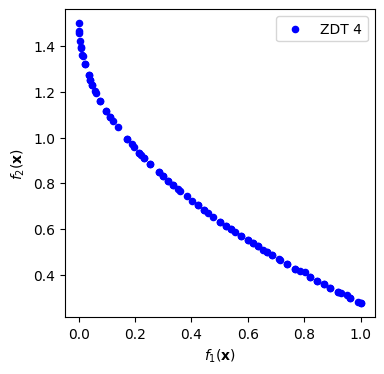

In [32]:
plot_colors = ('b','r', 'g', 'm', 'y', 'k', 'c')
fig, ax = plt.subplots(1, figsize=(4,4))

df.plot(ax=ax, kind='scatter', label='ZDT 4', 
        x=df.columns[0], y=df.columns[1], 
        color=plot_colors[i % len(plot_colors)])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

In [34]:
for index in range(1, 11):
    toolbox.register("select", tools.selNSGA3, ref_points=ref_points)
    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    # Initialize statistics object
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"
    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_iii(toolbox=toolbox,seed=index,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga3_zdt4_100_500_2_7-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga3_zdt4_100_500_2_7-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)

Iteration 1
gen	evals	Tiempo   
1  	     	0.0112913
2  	     	0.0172703
3  	     	0.0273325
4  	     	0.0325468
5  	     	0.044559 
6  	     	0.0498452
7  	     	0.0558634
8  	     	0.0609283
9  	     	0.0660837
10 	     	0.070092 
11 	     	0.0768137
12 	     	0.0820308
13 	     	0.0860441
14 	     	0.0940437
15 	     	0.107308 
16 	     	0.112553 
17 	     	0.122521 
18 	     	0.1317   
19 	     	0.135712 
20 	     	0.143712 
21 	     	0.158453 
22 	     	0.165491 
23 	     	0.173489 
24 	     	0.181492 
25 	     	0.186707 
26 	     	0.193223 
27 	     	0.215239 
28 	     	0.224783 
29 	     	0.237878 
30 	     	0.248383 
31 	     	0.256031 
32 	     	0.260066 
33 	     	0.268097 
34 	     	0.272096 
35 	     	0.280165 
36 	     	0.296213 
37 	     	0.304217 
38 	     	0.313506 
39 	     	0.317505 
40 	     	0.321506 
41 	     	0.329505 
42 	     	0.337505 
43 	     	0.344065 
44 	     	0.357191 
45 	     	0.364372 
46 	     	0.368372 
47 	     	0.382449 
48 	     	0.387466 
49 	    

413	     	3.44015  
414	     	3.45056  
415	     	3.4606   
416	     	3.46866  
417	     	3.47749  
418	     	3.4841   
419	     	3.48811  
420	     	3.49839  
421	     	3.50239  
422	     	3.51011  
423	     	3.51937  
424	     	3.52666  
425	     	3.53879  
426	     	3.54748  
427	     	3.55356  
428	     	3.55989  
429	     	3.57078  
430	     	3.58486  
431	     	3.59412  
432	     	3.608    
433	     	3.61617  
434	     	3.62749  
435	     	3.64284  
436	     	3.65709  
437	     	3.66651  
438	     	3.6743   
439	     	3.6874   
440	     	3.69321  
441	     	3.70126  
442	     	3.70527  
443	     	3.71209  
444	     	3.72015  
445	     	3.72814  
446	     	3.73214  
447	     	3.74015  
448	     	3.74623  
449	     	3.75557  
450	     	3.76209  
451	     	3.77009  
452	     	3.78049  
453	     	3.78449  
454	     	3.79321  
455	     	3.80122  
456	     	3.81007  
457	     	3.81417  
458	     	3.82217  
459	     	3.83017  
460	     	3.83417  
461	     	3.84217  
462	     	3.85125  


309	     	2.45445   
310	     	2.46497   
311	     	2.47228   
312	     	2.47843   
313	     	2.48553   
314	     	2.49358   
315	     	2.50129   
316	     	2.50737   
317	     	2.51138   
318	     	2.52022   
319	     	2.52428   
320	     	2.53227   
321	     	2.54027   
322	     	2.54427   
323	     	2.5537    
324	     	2.56365   
325	     	2.57166   
326	     	2.57808   
327	     	2.5866    
328	     	2.59465   
329	     	2.60322   
330	     	2.60727   
331	     	2.61527   
332	     	2.62291   
333	     	2.62691   
334	     	2.63567   
335	     	2.6457    
336	     	2.6497    
337	     	2.6577    
338	     	2.67034   
339	     	2.68287   
340	     	2.68652   
341	     	2.69665   
342	     	2.70217   
343	     	2.70734   
344	     	2.71538   
345	     	2.72434   
346	     	2.73234   
347	     	2.73739   
348	     	2.7454    
349	     	2.75237   
350	     	2.75642   
351	     	2.76558   
352	     	2.76963   
353	     	2.77764   
354	     	2.78816   
355	     	2.79423   
356	     	2.8

209	     	1.63588   
210	     	1.65816   
211	     	1.66606   
212	     	1.66904   
213	     	1.6771    
214	     	1.68514   
215	     	1.69065   
216	     	1.70026   
217	     	1.70026   
218	     	1.7097    
219	     	1.71624   
220	     	1.71624   
221	     	1.73377   
222	     	1.73377   
223	     	1.73377   
224	     	1.75048   
225	     	1.75048   
226	     	1.76624   
227	     	1.76624   
228	     	1.78294   
229	     	1.78949   
230	     	1.78949   
231	     	1.80914   
232	     	1.82642   
233	     	1.84103   
234	     	1.8555    
235	     	1.86489   
236	     	1.8771    
237	     	1.88368   
238	     	1.88973   
239	     	1.89865   
240	     	1.90514   
241	     	1.90913   
242	     	1.91612   
243	     	1.91612   
244	     	1.91612   
245	     	1.93203   
246	     	1.93203   
247	     	1.94965   
248	     	1.95393   
249	     	1.95393   
250	     	1.96979   
251	     	1.97577   
252	     	1.97577   
253	     	1.98984   
254	     	1.98984   
255	     	1.99943   
256	     	1.9

100	     	0.632619  
101	     	0.647612  
102	     	0.654887  
103	     	0.661941  
104	     	0.672985  
105	     	0.672985  
106	     	0.682862  
107	     	0.69091   
108	     	0.698846  
109	     	0.698846  
110	     	0.706897  
111	     	0.727921  
112	     	0.731964  
113	     	0.742494  
114	     	0.742494  
115	     	0.742494  
116	     	0.761975  
117	     	0.761975  
118	     	0.761975  
119	     	0.777649  
120	     	0.777649  
121	     	0.793266  
122	     	0.793266  
123	     	0.793266  
124	     	0.80889   
125	     	0.80889   
126	     	0.824505  
127	     	0.824505  
128	     	0.838548  
129	     	0.838548  
130	     	0.855329  
131	     	0.865233  
132	     	0.872092  
133	     	0.881986  
134	     	0.881986  
135	     	0.890031  
136	     	0.89889   
137	     	0.906943  
138	     	0.916476  
139	     	0.916476  
140	     	0.916476  
141	     	0.933205  
142	     	0.933205  
143	     	0.949922  
144	     	0.950919  
145	     	0.961974  
146	     	0.961974  
147	     	0.9

gen	evals	Tiempo   
1  	     	0.0069232
2  	     	0.0106978
3  	     	0.0221555
4  	     	0.0241499
5  	     	0.0241499
6  	     	0.0382864
7  	     	0.0392835
8  	     	0.0473289
9  	     	0.0539317
10 	     	0.0539317
11 	     	0.0619423
12 	     	0.0704916
13 	     	0.0704916
14 	     	0.0792482
15 	     	0.087841 
16 	     	0.087841 
17 	     	0.087841 
18 	     	0.104606 
19 	     	0.121396 
20 	     	0.121396 
21 	     	0.121396 
22 	     	0.121396 
23 	     	0.139098 
24 	     	0.139098 
25 	     	0.139098 
26 	     	0.155821 
27 	     	0.155821 
28 	     	0.155821 
29 	     	0.171457 
30 	     	0.171457 
31 	     	0.171457 
32 	     	0.188003 
33 	     	0.188003 
34 	     	0.204722 
35 	     	0.204722 
36 	     	0.204722 
37 	     	0.226532 
38 	     	0.23583  
39 	     	0.23683  
40 	     	0.244884 
41 	     	0.253907 
42 	     	0.253907 
43 	     	0.261984 
44 	     	0.271573 
45 	     	0.271573 
46 	     	0.271573 
47 	     	0.288238 
48 	     	0.288238 
49 	     	0.288238 


428	     	3.07678  
429	     	3.09139  
430	     	3.10339  
431	     	3.1061   
432	     	3.11415  
433	     	3.12216  
434	     	3.13021  
435	     	3.13671  
436	     	3.13671  
437	     	3.15378  
438	     	3.15378  
439	     	3.15378  
440	     	3.1705   
441	     	3.1705   
442	     	3.1862   
443	     	3.18724  
444	     	3.18724  
445	     	3.20402  
446	     	3.20402  
447	     	3.22132  
448	     	3.22232  
449	     	3.22232  
450	     	3.23799  
451	     	3.23799  
452	     	3.25363  
453	     	3.25467  
454	     	3.25467  
455	     	3.27142  
456	     	3.27142  
457	     	3.28713  
458	     	3.29663  
459	     	3.30337  
460	     	3.31263  
461	     	3.32037  
462	     	3.32242  
463	     	3.33156  
464	     	3.33698  
465	     	3.34513  
466	     	3.34513  
467	     	3.3608   
468	     	3.3608   
469	     	3.3608   
470	     	3.37642  
471	     	3.37642  
472	     	3.39204  
473	     	3.39204  
474	     	3.39204  
475	     	3.40766  
476	     	3.40766  
477	     	3.42373  


343	     	2.52751  
344	     	2.53626  
345	     	2.54306  
346	     	2.54951  
347	     	2.55756  
348	     	2.56637  
349	     	2.56837  
350	     	2.57764  
351	     	2.58288  
352	     	2.59306  
353	     	2.6089   
354	     	2.61731  
355	     	2.63857  
356	     	2.63857  
357	     	2.65547  
358	     	2.65547  
359	     	2.67115  
360	     	2.67115  
361	     	2.68677  
362	     	2.68677  
363	     	2.68677  
364	     	2.70239  
365	     	2.70239  
366	     	2.71805  
367	     	2.71805  
368	     	2.74013  
369	     	2.74932  
370	     	2.74932  
371	     	2.75868  
372	     	2.76637  
373	     	2.77443  
374	     	2.78192  
375	     	2.78298  
376	     	2.78298  
377	     	2.79966  
378	     	2.79966  
379	     	2.8154   
380	     	2.81639  
381	     	2.81639  
382	     	2.83912  
383	     	2.83912  
384	     	2.85598  
385	     	2.85598  
386	     	2.87165  
387	     	2.87165  
388	     	2.87165  
389	     	2.88727  
390	     	2.88727  
391	     	2.90289  
392	     	2.90289  


262	     	2.05715   
263	     	2.06669   
264	     	2.0784    
265	     	2.08645   
266	     	2.09452   
267	     	2.09452   
268	     	2.10724   
269	     	2.10828   
270	     	2.11633   
271	     	2.12583   
272	     	2.13417   
273	     	2.13417   
274	     	2.15096   
275	     	2.15096   
276	     	2.16663   
277	     	2.16663   
278	     	2.16663   
279	     	2.18225   
280	     	2.19376   
281	     	2.19376   
282	     	2.19376   
283	     	2.20939   
284	     	2.20939   
285	     	2.23272   
286	     	2.23272   
287	     	2.24381   
288	     	2.24381   
289	     	2.25898   
290	     	2.26703   
291	     	2.27573   
292	     	2.28853   
293	     	2.29718   
294	     	2.30723   
295	     	2.30823   
296	     	2.31629   
297	     	2.32435   
298	     	2.32435   
299	     	2.32435   
300	     	2.34249   
301	     	2.34249   
302	     	2.35922   
303	     	2.36021   
304	     	2.36021   
305	     	2.37588   
306	     	2.37588   
307	     	2.39334   
308	     	2.40197   
309	     	2.4

168	     	1.36133   
169	     	1.37446   
170	     	1.39873   
171	     	1.40797   
172	     	1.41807   
173	     	1.41807   
174	     	1.42613   
175	     	1.43547   
176	     	1.43547   
177	     	1.43547   
178	     	1.45221   
179	     	1.4603    
180	     	1.4603    
181	     	1.47598   
182	     	1.48419   
183	     	1.48419   
184	     	1.50116   
185	     	1.52523   
186	     	1.53581   
187	     	1.54646   
188	     	1.55789   
189	     	1.57044   
190	     	1.58862   
191	     	1.60394   
192	     	1.60494   
193	     	1.61729   
194	     	1.61729   
195	     	1.6253    
196	     	1.63547   
197	     	1.64352   
198	     	1.65116   
199	     	1.65116   
200	     	1.67346   
201	     	1.68452   
202	     	1.68452   
203	     	1.69949   
204	     	1.69949   
205	     	1.70755   
206	     	1.71606   
207	     	1.71606   
208	     	1.73535   
209	     	1.73535   
210	     	1.73535   
211	     	1.75103   
212	     	1.75103   
213	     	1.76773   
214	     	1.76773   
215	     	1.7

65 	     	0.535798 
66 	     	0.55476  
67 	     	0.558751 
68 	     	0.57131  
69 	     	0.578381 
70 	     	0.5863   
71 	     	0.594351 
72 	     	0.606008 
73 	     	0.614189 
74 	     	0.614189 
75 	     	0.629856 
76 	     	0.629856 
77 	     	0.629856 
78 	     	0.655437 
79 	     	0.657951 
80 	     	0.67358  
81 	     	0.67358  
82 	     	0.689543 
83 	     	0.690541 
84 	     	0.690541 
85 	     	0.706214 
86 	     	0.706214 
87 	     	0.723587 
88 	     	0.723587 
89 	     	0.741547 
90 	     	0.757774 
91 	     	0.760587 
92 	     	0.769513 
93 	     	0.777523 
94 	     	0.786366 
95 	     	0.791741 
96 	     	0.799798 
97 	     	0.80252  
98 	     	0.81193  
99 	     	0.81193  
100	     	0.827618 
101	     	0.827618 
102	     	0.843225 
103	     	0.843225 
104	     	0.858273 
105	     	0.858273 
106	     	0.875202 
107	     	0.886013 
108	     	0.896215 
109	     	0.90259  
110	     	0.90259  
111	     	0.919471 
112	     	0.919471 
113	     	0.94623  
114	     	0.958262 


496	     	3.8299   
497	     	3.84553  
498	     	3.85345  
499	     	3.85345  
500	     	3.86273  
Iteration 10
gen	evals	Tiempo  
1  	     	0.016758
2  	     	0.0177934
3  	     	0.0345597
4  	     	0.0515404
5  	     	0.0515404
6  	     	0.0515404
7  	     	0.0683088
8  	     	0.0683088
9  	     	0.083986 
10 	     	0.0910611
11 	     	0.0910611
12 	     	0.0910611
13 	     	0.107824 
14 	     	0.107824 
15 	     	0.107824 
16 	     	0.123524 
17 	     	0.132977 
18 	     	0.141762 
19 	     	0.150339 
20 	     	0.151336 
21 	     	0.159381 
22 	     	0.166386 
23 	     	0.166386 
24 	     	0.176502 
25 	     	0.183794 
26 	     	0.191369 
27 	     	0.191369 
28 	     	0.191369 
29 	     	0.208309 
30 	     	0.216047 
31 	     	0.224826 
32 	     	0.224826 
33 	     	0.232955 
34 	     	0.241008 
35 	     	0.248425 
36 	     	0.250534 
37 	     	0.250534 
38 	     	0.250534 
39 	     	0.268368 
40 	     	0.268368 
41 	     	0.268368 
42 	     	0.283999 
43 	     	0.291543 
44 	     

409	     	3.39328  
410	     	3.40109  
411	     	3.4117   
412	     	3.41932  
413	     	3.42648  
414	     	3.43426  
415	     	3.4414   
416	     	3.44945  
417	     	3.45846  
418	     	3.47077  
419	     	3.4787   
420	     	3.48828  
421	     	3.49474  
422	     	3.50215  
423	     	3.5095   
424	     	3.51771  
425	     	3.52545  
426	     	3.53287  
427	     	3.5339   
428	     	3.54243  
429	     	3.55008  
430	     	3.5596   
431	     	3.567    
432	     	3.57504  
433	     	3.58248  
434	     	3.58845  
435	     	3.58845  
436	     	3.60395  
437	     	3.60922  
438	     	3.62678  
439	     	3.63352  
440	     	3.63352  
441	     	3.64262  
442	     	3.64946  
443	     	3.65751  
444	     	3.66696  
445	     	3.66792  
446	     	3.66792  
447	     	3.68467  
448	     	3.68467  
449	     	3.69933  
450	     	3.70362  
451	     	3.70362  
452	     	3.71819  
453	     	3.73411  
454	     	3.7371   
455	     	3.75452  
456	     	3.78444  
457	     	3.79849  
458	     	3.81642  


## ZDT 5

In [35]:
NDIM = 80

In [36]:
for index in range(1, 11):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
    creator.create("Individual", list, fitness=creator.FitnessMin) 

    toolbox = base.Toolbox()
    toolbox.register("evaluate", zdt5) #Fitness Function

    #Chromosome representation Binary
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, NDIM) #The individual consist of a 35 binary length
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    # Initialize statistics object
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"
    
    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_ii(toolbox=toolbox, seed=index, stats=stats, verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga2_zdt5_100_500_2_80-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga2_zdt5_100_500_2_80-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 1
gen	evals	Tiempo  
1  	     	0.131484
2  	     	0.159945
3  	     	0.176   
4  	     	0.196203
5  	     	0.241695
6  	     	0.260108
7  	     	0.28144 
8  	     	0.288741
9  	     	0.325012
10 	     	0.352245
11 	     	0.396785
12 	     	0.418294
13 	     	0.426101
14 	     	0.460453
15 	     	0.477222
16 	     	0.500522
17 	     	0.516203
18 	     	0.54689 
19 	     	0.568694
20 	     	0.59391 
21 	     	0.615934
22 	     	0.637552
23 	     	0.675925
24 	     	0.71668 
25 	     	0.751005
26 	     	0.782799
27 	     	0.807453
28 	     	0.878346
29 	     	0.944778
30 	     	0.976881
31 	     	1.0227  
32 	     	1.06552 
33 	     	1.09257 
34 	     	1.11787 
35 	     	1.14275 
36 	     	1.16143 
37 	     	1.19568 
38 	     	1.22944 
39 	     	1.24383 
40 	     	1.27504 
41 	     	1.28057 
42 	     	1.32252 
43 	     	1.38029 
44 	     	1.46713 
45 	     	1.51918 
46 	     	1.55745 
47 	     	1.60041 
48 	     	1.63355 
49 	     	1.65932 
50 	     	1.70151 
51 	     	1.7115  


435	     	10.6458 
436	     	10.6655 
437	     	10.6839 
438	     	10.7079 
439	     	10.7125 
440	     	10.7422 
441	     	10.759  
442	     	10.7757 
443	     	10.8142 
444	     	10.8347 
445	     	10.8588 
446	     	10.867  
447	     	10.8823 
448	     	10.9136 
449	     	10.9423 
450	     	10.9597 
451	     	10.9824 
452	     	11.0013 
453	     	11.0216 
454	     	11.0338 
455	     	11.0494 
456	     	11.081  
457	     	11.111  
458	     	11.1296 
459	     	11.1452 
460	     	11.1757 
461	     	11.1925 
462	     	11.2137 
463	     	11.234  
464	     	11.2496 
465	     	11.2653 
466	     	11.2821 
467	     	11.2996 
468	     	11.315  
469	     	11.3472 
470	     	11.3679 
471	     	11.3934 
472	     	11.4143 
473	     	11.4322 
474	     	11.4588 
475	     	11.4763 
476	     	11.4921 
477	     	11.5265 
478	     	11.5422 
479	     	11.5599 
480	     	11.5777 
481	     	11.611  
482	     	11.6322 
483	     	11.6522 
484	     	11.6755 
485	     	11.6923 
486	     	11.7146 
487	     	11

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


6  	     	0.131607 
7  	     	0.149504 
8  	     	0.163598 
9  	     	0.181384 
10 	     	0.224321 
11 	     	0.239955 
12 	     	0.288689 
13 	     	0.312002 
14 	     	0.339763 
15 	     	0.362567 
16 	     	0.388689 
17 	     	0.407447 
18 	     	0.440923 
19 	     	0.462919 
20 	     	0.479868 
21 	     	0.496638 
22 	     	0.527889 
23 	     	0.561577 
24 	     	0.581178 
25 	     	0.606404 
26 	     	0.624175 
27 	     	0.639694 
28 	     	0.663462 
29 	     	0.689798 
30 	     	0.706513 
31 	     	0.739912 
32 	     	0.763716 
33 	     	0.779385 
34 	     	0.797136 
35 	     	0.806466 
36 	     	0.841015 
37 	     	0.863564 
38 	     	0.881322 
39 	     	0.922984 
40 	     	0.939909 
41 	     	0.963624 
42 	     	0.97929  
43 	     	1.0218   
44 	     	1.04962  
45 	     	1.09756  
46 	     	1.12576  
47 	     	1.14106  
48 	     	1.16383  
49 	     	1.17301  
50 	     	1.20658  
51 	     	1.22825  
52 	     	1.24074  
53 	     	1.27573  
54 	     	1.29856  
55 	     	1.32421  


427	     	9.86507  
428	     	9.88942  
429	     	9.90949  
430	     	9.93166  
431	     	9.95882  
432	     	9.97787  
433	     	10.0052  
434	     	10.0237  
435	     	10.0507  
436	     	10.139   
437	     	10.1717  
438	     	10.1892  
439	     	10.2231  
440	     	10.2583  
441	     	10.2807  
442	     	10.2911  
443	     	10.3076  
444	     	10.3473  
445	     	10.3661  
446	     	10.3903  
447	     	10.4079  
448	     	10.4246  
449	     	10.4414  
450	     	10.4727  
451	     	10.4904  
452	     	10.511   
453	     	10.5392  
454	     	10.5621  
455	     	10.5881  
456	     	10.607   
457	     	10.6236  
458	     	10.6561  
459	     	10.6806  
460	     	10.6974  
461	     	10.706   
462	     	10.7392  
463	     	10.7566  
464	     	10.7734  
465	     	10.7902  
466	     	10.822   
467	     	10.8398  
468	     	10.8595  
469	     	10.8817  
470	     	10.8974  
471	     	10.939   
472	     	10.9559  
473	     	10.98    
474	     	11.0016  
475	     	11.0224  
476	     	11.0393  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


7  	     	0.147495 
8  	     	0.184571 
9  	     	0.208904 
10 	     	0.230607 
11 	     	0.247394 
12 	     	0.264146 
13 	     	0.280998 
14 	     	0.313437 
15 	     	0.335344 
16 	     	0.363194 
17 	     	0.380796 
18 	     	0.397507 
19 	     	0.430948 
20 	     	0.449063 
21 	     	0.465775 
22 	     	0.496878 
23 	     	0.521228 
24 	     	0.539022 
25 	     	0.582057 
26 	     	0.597158 
27 	     	0.621362 
28 	     	0.647657 
29 	     	0.664392 
30 	     	0.679736 
31 	     	0.696455 
32 	     	0.729875 
33 	     	0.750412 
34 	     	0.784164 
35 	     	0.817244 
36 	     	0.832921 
37 	     	0.866068 
38 	     	0.89036  
39 	     	0.913018 
40 	     	0.93081  
41 	     	0.947588 
42 	     	0.980036 
43 	     	1.01476  
44 	     	1.04224  
45 	     	1.07991  
46 	     	1.12558  
47 	     	1.14719  
48 	     	1.17982  
49 	     	1.21887  
50 	     	1.24695  
51 	     	1.26441  
52 	     	1.28781  
53 	     	1.30961  
54 	     	1.32966  
55 	     	1.36214  
56 	     	1.38322  


425	     	9.63524  
426	     	9.65086  
427	     	9.67043  
428	     	9.69597  
429	     	9.71276  
430	     	9.73529  
431	     	9.75091  
432	     	9.79609  
433	     	9.83469  
434	     	9.8685   
435	     	9.90965  
436	     	9.92923  
437	     	9.94678  
438	     	9.97487  
439	     	9.99705  
440	     	10.0293  
441	     	10.046   
442	     	10.0626  
443	     	10.0797  
444	     	10.0981  
445	     	10.115   
446	     	10.1352  
447	     	10.147   
448	     	10.1881  
449	     	10.2126  
450	     	10.2294  
451	     	10.2554  
452	     	10.2859  
453	     	10.3039  
454	     	10.3208  
455	     	10.3354  
456	     	10.351   
457	     	10.3679  
458	     	10.3992  
459	     	10.4196  
460	     	10.4356  
461	     	10.4524  
462	     	10.4875  
463	     	10.5051  
464	     	10.5383  
465	     	10.5635  
466	     	10.5795  
467	     	10.596   
468	     	10.6127  
469	     	10.6355  
470	     	10.6626  
471	     	10.6793  
472	     	10.7135  
473	     	10.7353  
474	     	10.7521  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


10 	     	0.213338 
11 	     	0.240901 
12 	     	0.273762 
13 	     	0.297321 
14 	     	0.322562 
15 	     	0.348417 
16 	     	0.36409  
17 	     	0.379673 
18 	     	0.397353 
19 	     	0.439921 
20 	     	0.455971 
21 	     	0.473631 
22 	     	0.496595 
23 	     	0.526918 
24 	     	0.55495  
25 	     	0.573611 
26 	     	0.59772  
27 	     	0.61472  
28 	     	0.652402 
29 	     	0.672606 
30 	     	0.690233 
31 	     	0.712454 
32 	     	0.730385 
33 	     	0.746058 
34 	     	0.783435 
35 	     	0.806771 
36 	     	0.840095 
37 	     	0.858987 
38 	     	0.87577  
39 	     	0.896942 
40 	     	0.922604 
41 	     	0.939294 
42 	     	0.956038 
43 	     	0.97281  
44 	     	1.0212   
45 	     	1.05307  
46 	     	1.09404  
47 	     	1.12215  
48 	     	1.15692  
49 	     	1.18356  
50 	     	1.20597  
51 	     	1.22809  
52 	     	1.25638  
53 	     	1.28062  
54 	     	1.30573  
55 	     	1.32244  
56 	     	1.33921  
57 	     	1.37221  
58 	     	1.38921  
59 	     	1.41248  


426	     	9.32647  
427	     	9.34778  
428	     	9.36449  
429	     	9.38025  
430	     	9.38882  
431	     	9.40654  
432	     	9.43892  
433	     	9.4556   
434	     	9.4744   
435	     	9.49003  
436	     	9.50668  
437	     	9.539    
438	     	9.55578  
439	     	9.57353  
440	     	9.59042  
441	     	9.63436  
442	     	9.65583  
443	     	9.68088  
444	     	9.68937  
445	     	9.71444  
446	     	9.73918  
447	     	9.75589  
448	     	9.79875  
449	     	9.82228  
450	     	9.84232  
451	     	9.85795  
452	     	9.87953  
453	     	9.90174  
454	     	9.92307  
455	     	9.93936  
456	     	9.95645  
457	     	9.97321  
458	     	9.98994  
459	     	10.0067  
460	     	10.0235  
461	     	10.0608  
462	     	10.0821  
463	     	10.1053  
464	     	10.1403  
465	     	10.1903  
466	     	10.2085  
467	     	10.2222  
468	     	10.2398  
469	     	10.2565  
470	     	10.2729  
471	     	10.2916  
472	     	10.3229  
473	     	10.3397  
474	     	10.3564  
475	     	10.3732  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


2  	     	0.0571542
3  	     	0.0694971
4  	     	0.0862882
5  	     	0.10723  
6  	     	0.146189 
7  	     	0.163507 
8  	     	0.180273 
9  	     	0.226052 
10 	     	0.25236  
11 	     	0.274062 
12 	     	0.299298 
13 	     	0.31902  
14 	     	0.33663  
15 	     	0.353371 
16 	     	0.370141 
17 	     	0.386891 
18 	     	0.407185 
19 	     	0.442085 
20 	     	0.471851 
21 	     	0.510475 
22 	     	0.535454 
23 	     	0.563968 
24 	     	0.594985 
25 	     	0.619282 
26 	     	0.648396 
27 	     	0.671904 
28 	     	0.703707 
29 	     	0.735027 
30 	     	0.757505 
31 	     	0.787676 
32 	     	0.820243 
33 	     	0.84382  
34 	     	0.872834 
35 	     	0.903661 
36 	     	0.930828 
37 	     	0.952082 
38 	     	0.968549 
39 	     	1.00203  
40 	     	1.04051  
41 	     	1.08636  
42 	     	1.12378  
43 	     	1.14799  
44 	     	1.17588  
45 	     	1.20179  
46 	     	1.23559  
47 	     	1.25965  
48 	     	1.26872  
49 	     	1.30714  
50 	     	1.32281  
51 	     	1.35816  


423	     	10.0789  
424	     	10.1047  
425	     	10.1278  
426	     	10.1517  
427	     	10.1694  
428	     	10.1861  
429	     	10.2193  
430	     	10.2371  
431	     	10.2599  
432	     	10.2766  
433	     	10.2937  
434	     	10.3111  
435	     	10.336   
436	     	10.3527  
437	     	10.3863  
438	     	10.403   
439	     	10.4198  
440	     	10.4441  
441	     	10.4784  
442	     	10.4943  
443	     	10.5098  
444	     	10.5365  
445	     	10.5533  
446	     	10.5945  
447	     	10.6175  
448	     	10.6377  
449	     	10.6534  
450	     	10.6701  
451	     	10.6869  
452	     	10.7037  
453	     	10.7194  
454	     	10.7581  
455	     	10.7889  
456	     	10.8098  
457	     	10.8195  
458	     	10.8475  
459	     	10.8682  
460	     	10.8839  
461	     	10.9016  
462	     	10.9358  
463	     	10.9516  
464	     	10.985   
465	     	11.0014  
466	     	11.0191  
467	     	11.0379  
468	     	11.0703  
469	     	11.094   
470	     	11.1172  
471	     	11.1375  
472	     	11.1672  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 6
gen	evals	Tiempo   
1  	     	0.0707037
2  	     	0.105124 
3  	     	0.131264 
4  	     	0.146949 
5  	     	0.178145 
6  	     	0.189769 
7  	     	0.22205  
8  	     	0.238772 
9  	     	0.267794 
10 	     	0.304155 
11 	     	0.338154 
12 	     	0.354148 
13 	     	0.373706 
14 	     	0.390845 
15 	     	0.423455 
16 	     	0.43908  
17 	     	0.471469 
18 	     	0.492923 
19 	     	0.521349 
20 	     	0.554882 
21 	     	0.580786 
22 	     	0.605109 
23 	     	0.621826 
24 	     	0.660592 
25 	     	0.680802 
26 	     	0.696479 
27 	     	0.720599 
28 	     	0.73733  
29 	     	0.762665 
30 	     	0.782932 
31 	     	0.804576 
32 	     	0.836263 
33 	     	0.854968 
34 	     	0.882862 
35 	     	0.904095 
36 	     	0.923201 
37 	     	0.953403 
38 	     	0.983366 
39 	     	1.006    
40 	     	1.04771  
41 	     	1.09076  
42 	     	1.10395  
43 	     	1.12182  
44 	     	1.15293  
45 	     	1.1765   
46 	     	1.18727  
47 	     	1.22062  
48 	     	1.23819  
49 	    

419	     	10.2616  
420	     	10.2867  
421	     	10.3073  
422	     	10.337   
423	     	10.3567  
424	     	10.3803  
425	     	10.4094  
426	     	10.4394  
427	     	10.4645  
428	     	10.4876  
429	     	10.5093  
430	     	10.5253  
431	     	10.5375  
432	     	10.5545  
433	     	10.5803  
434	     	10.5972  
435	     	10.6315  
436	     	10.6545  
437	     	10.6784  
438	     	10.6987  
439	     	10.7211  
440	     	10.7478  
441	     	10.7719  
442	     	10.7965  
443	     	10.8201  
444	     	10.8492  
445	     	10.8727  
446	     	10.8964  
447	     	10.9242  
448	     	10.9496  
449	     	10.9711  
450	     	10.9866  
451	     	11.0072  
452	     	11.0228  
453	     	11.0551  
454	     	11.0719  
455	     	11.0879  
456	     	11.1046  
457	     	11.1225  
458	     	11.1663  
459	     	11.2582  
460	     	11.2764  
461	     	11.3122  
462	     	11.3259  
463	     	11.3588  
464	     	11.3868  
465	     	11.4133  
466	     	11.4418  
467	     	11.4716  
468	     	11.492   


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


3  	     	0.072886 
4  	     	0.0902708
5  	     	0.122688 
6  	     	0.1397   
7  	     	0.157319 
8  	     	0.174053 
9  	     	0.206482 
10 	     	0.222806 
11 	     	0.256298 
12 	     	0.273985 
13 	     	0.306976 
14 	     	0.331003 
15 	     	0.34076  
16 	     	0.361592 
17 	     	0.406287 
18 	     	0.422973 
19 	     	0.439681 
20 	     	0.4721   
21 	     	0.489941 
22 	     	0.506716 
23 	     	0.555002 
24 	     	0.573012 
25 	     	0.59061  
26 	     	0.60744  
27 	     	0.638634 
28 	     	0.662458 
29 	     	0.690341 
30 	     	0.707319 
31 	     	0.722872 
32 	     	0.763134 
33 	     	0.790414 
34 	     	0.80732  
35 	     	0.822911 
36 	     	0.8612   
37 	     	0.87682  
38 	     	0.893578 
39 	     	0.922793 
40 	     	0.95599  
41 	     	0.984245 
42 	     	1.01057  
43 	     	1.09963  
44 	     	1.14246  
45 	     	1.15611  
46 	     	1.1732   
47 	     	1.2061   
48 	     	1.23494  
49 	     	1.26864  
50 	     	1.29429  
51 	     	1.32187  
52 	     	1.34021  


421	     	9.13942  
422	     	9.17627  
423	     	9.2246   
424	     	9.23953  
425	     	9.24768  
426	     	9.26334  
427	     	9.29584  
428	     	9.31088  
429	     	9.33961  
430	     	9.35644  
431	     	9.37322  
432	     	9.38996  
433	     	9.40671  
434	     	9.45072  
435	     	9.46585  
436	     	9.48906  
437	     	9.50725  
438	     	9.52714  
439	     	9.5593   
440	     	9.59249  
441	     	9.62643  
442	     	9.64004  
443	     	9.65679  
444	     	9.67356  
445	     	9.7073   
446	     	9.7299   
447	     	9.75571  
448	     	9.78046  
449	     	9.7972   
450	     	9.81455  
451	     	9.8403   
452	     	9.85705  
453	     	9.87231  
454	     	9.8892   
455	     	9.90591  
456	     	9.94191  
457	     	9.9671   
458	     	9.9782   
459	     	10.0135  
460	     	10.0354  
461	     	10.0408  
462	     	10.0576  
463	     	10.1065  
464	     	10.1225  
465	     	10.1408  
466	     	10.1575  
467	     	10.1744  
468	     	10.1901  
469	     	10.2225  
470	     	10.2409  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	evals	Tiempo   
1  	     	0.0194762
2  	     	0.0591519
3  	     	0.0902915
4  	     	0.111871 
5  	     	0.13606  
6  	     	0.152799 
7  	     	0.171578 
8  	     	0.18726  
9  	     	0.204938 
10 	     	0.236061 
11 	     	0.263324 
12 	     	0.286987 
13 	     	0.313959 
14 	     	0.346006 
15 	     	0.37157  
16 	     	0.394802 
17 	     	0.419466 
18 	     	0.444314 
19 	     	0.472398 
20 	     	0.521849 
21 	     	0.568302 
22 	     	0.597017 
23 	     	0.603909 
24 	     	0.620669 
25 	     	0.661515 
26 	     	0.686086 
27 	     	0.70294  
28 	     	0.736639 
29 	     	0.753863 
30 	     	0.772617 
31 	     	0.806804 
32 	     	0.822482 
33 	     	0.838102 
34 	     	0.854814 
35 	     	0.889297 
36 	     	0.908852 
37 	     	0.940148 
38 	     	0.971507 
39 	     	1.00627  
40 	     	1.02719  
41 	     	1.07065  
42 	     	1.10917  
43 	     	1.13743  
44 	     	1.15419  
45 	     	1.1872   
46 	     	1.20277  
47 	     	1.23715  
48 	     	1.26697  
49 	     	1.30157  


418	     	9.41226  
419	     	9.45262  
420	     	9.48921  
421	     	9.51909  
422	     	9.53681  
423	     	9.55357  
424	     	9.5703   
425	     	9.59448  
426	     	9.61014  
427	     	9.62731  
428	     	9.64298  
429	     	9.67981  
430	     	9.70237  
431	     	9.72014  
432	     	9.74444  
433	     	9.77257  
434	     	9.80494  
435	     	9.8257   
436	     	9.84354  
437	     	9.87895  
438	     	9.90121  
439	     	9.92349  
440	     	9.95326  
441	     	9.97     
442	     	9.99798  
443	     	10.0147  
444	     	10.0355  
445	     	10.0523  
446	     	10.0793  
447	     	10.1039  
448	     	10.1378  
449	     	10.1761  
450	     	10.1937  
451	     	10.2271  
452	     	10.2524  
453	     	10.2691  
454	     	10.2862  
455	     	10.3248  
456	     	10.3426  
457	     	10.3689  
458	     	10.4025  
459	     	10.4103  
460	     	10.4514  
461	     	10.4715  
462	     	10.4946  
463	     	10.5196  
464	     	10.538   
465	     	10.5536  
466	     	10.5713  
467	     	10.5857  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


8  	     	0.185546 
9  	     	0.201131 
10 	     	0.218874 
11 	     	0.261596 
12 	     	0.295158 
13 	     	0.319082 
14 	     	0.328614 
15 	     	0.360614 
16 	     	0.386927 
17 	     	0.411528 
18 	     	0.443028 
19 	     	0.460718 
20 	     	0.47857  
21 	     	0.49745  
22 	     	0.529853 
23 	     	0.54549  
24 	     	0.570204 
25 	     	0.593041 
26 	     	0.619534 
27 	     	0.645154 
28 	     	0.654705 
29 	     	0.702558 
30 	     	0.721418 
31 	     	0.745199 
32 	     	0.770878 
33 	     	0.804594 
34 	     	0.831168 
35 	     	0.861801 
36 	     	0.87757  
37 	     	0.897269 
38 	     	0.912941 
39 	     	0.946803 
40 	     	0.961181 
41 	     	0.99488  
42 	     	1.02101  
43 	     	1.05859  
44 	     	1.12235  
45 	     	1.15488  
46 	     	1.17743  
47 	     	1.19407  
48 	     	1.21176  
49 	     	1.22899  
50 	     	1.26064  
51 	     	1.27736  
52 	     	1.3098   
53 	     	1.32936  
54 	     	1.34616  
55 	     	1.35521  
56 	     	1.40039  
57 	     	1.44297  


424	     	9.6841   
425	     	9.70315  
426	     	9.72002  
427	     	9.73682  
428	     	9.75379  
429	     	9.79347  
430	     	9.8207   
431	     	9.85552  
432	     	9.88468  
433	     	9.90926  
434	     	9.92128  
435	     	9.93849  
436	     	9.97079  
437	     	9.9936   
438	     	10.0119  
439	     	10.0339  
440	     	10.0595  
441	     	10.078   
442	     	10.0947  
443	     	10.1114  
444	     	10.1281  
445	     	10.1499  
446	     	10.1655  
447	     	10.1968  
448	     	10.2124  
449	     	10.2437  
450	     	10.2503  
451	     	10.2827  
452	     	10.304   
453	     	10.3116  
454	     	10.3504  
455	     	10.3691  
456	     	10.3847  
457	     	10.4103  
458	     	10.427   
459	     	10.4504  
460	     	10.4661  
461	     	10.4827  
462	     	10.4984  
463	     	10.5307  
464	     	10.5518  
465	     	10.5705  
466	     	10.6104  
467	     	10.6281  
468	     	10.6459  
469	     	10.651   
470	     	10.6841  
471	     	10.6997  
472	     	10.7153  
473	     	10.731   


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


7  	     	0.184477 
8  	     	0.21783  
9  	     	0.254992 
10 	     	0.277775 
11 	     	0.306328 
12 	     	0.323556 
13 	     	0.347996 
14 	     	0.377917 
15 	     	0.398368 
16 	     	0.423191 
17 	     	0.454455 
18 	     	0.48782  
19 	     	0.507293 
20 	     	0.527008 
21 	     	0.5508   
22 	     	0.580272 
23 	     	0.605812 
24 	     	0.623024 
25 	     	0.639472 
26 	     	0.670963 
27 	     	0.688748 
28 	     	0.733886 
29 	     	0.770865 
30 	     	0.795844 
31 	     	0.811767 
32 	     	0.829607 
33 	     	0.847357 
34 	     	0.884528 
35 	     	0.922839 
36 	     	0.938869 
37 	     	0.961906 
38 	     	0.99018  
39 	     	1.02639  
40 	     	1.06661  
41 	     	1.10074  
42 	     	1.13898  
43 	     	1.15565  
44 	     	1.1742   
45 	     	1.18866  
46 	     	1.22825  
47 	     	1.25658  
48 	     	1.28934  
49 	     	1.31181  
50 	     	1.35528  
51 	     	1.38043  
52 	     	1.41311  
53 	     	1.43866  
54 	     	1.44896  
55 	     	1.49749  
56 	     	1.53878  


419	     	10.4017  
420	     	10.4253  
421	     	10.4635  
422	     	10.4907  
423	     	10.514   
424	     	10.5474  
425	     	10.5642  
426	     	10.5939  
427	     	10.6216  
428	     	10.6473  
429	     	10.6716  
430	     	10.6957  
431	     	10.7217  
432	     	10.7636  
433	     	10.7797  
434	     	10.8048  
435	     	10.8224  
436	     	10.8501  
437	     	10.8658  
438	     	10.8832  
439	     	10.9119  
440	     	10.9381  
441	     	10.9592  
442	     	10.9762  
443	     	11.0048  
444	     	11.0213  
445	     	11.0407  
446	     	11.0734  
447	     	11.0881  
448	     	11.1091  
449	     	11.1203  
450	     	11.1389  
451	     	11.1557  
452	     	11.1891  
453	     	11.2065  
454	     	11.2234  
455	     	11.2401  
456	     	11.2723  
457	     	11.3012  
458	     	11.3251  
459	     	11.3571  
460	     	11.3768  
461	     	11.3971  
462	     	11.4161  
463	     	11.434   
464	     	11.4497  
465	     	11.481   
466	     	11.4981  
467	     	11.5138  
468	     	11.5463  


In [38]:
plot_colors = ('b','r', 'g', 'm', 'y', 'k', 'c')
fig, ax = plt.subplots(1, figsize=(4,4))

df.plot(ax=ax, kind='scatter', label='ZDT 5', 
        x=df.columns[0], y=df.columns[1], 
        color=plot_colors[i % len(plot_colors)])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

In [37]:
for index in range(1, 11):
    toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    # Initialize statistics object
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"
    
    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_iii(toolbox=toolbox,seed=index,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga3_zdt5_100_500_2_80-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga3_zdt5_100_500_2_80-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)

Iteration 1
gen	evals	Tiempo  
1  	     	0.030844
2  	     	0.0478499
3  	     	0.0559316
4  	     	0.0688326
5  	     	0.0688326
6  	     	0.0844631
7  	     	0.0963595
8  	     	0.126188 
9  	     	0.136413 
10 	     	0.136413 
11 	     	0.15209  
12 	     	0.167664 
13 	     	0.183332 
14 	     	0.185632 
15 	     	0.204008 
16 	     	0.213158 
17 	     	0.230881 
18 	     	0.245732 
19 	     	0.25474  
20 	     	0.267939 
21 	     	0.280904 
22 	     	0.297018 
23 	     	0.305627 
24 	     	0.319597 
25 	     	0.341908 
26 	     	0.357838 
27 	     	0.368912 
28 	     	0.38135  
29 	     	0.397745 
30 	     	0.414179 
31 	     	0.434293 
32 	     	0.450072 
33 	     	0.469303 
34 	     	0.481184 
35 	     	0.497882 
36 	     	0.509617 
37 	     	0.524594 
38 	     	0.532327 
39 	     	0.555031 
40 	     	0.568191 
41 	     	0.581345 
42 	     	0.595265 
43 	     	0.604432 
44 	     	0.62162  
45 	     	0.629399 
46 	     	0.646421 
47 	     	0.668092 
48 	     	0.680626 
49 	     	

424	     	6.62837  
425	     	6.64969  
426	     	6.66271  
427	     	6.6754   
428	     	6.68934  
429	     	6.70072  
430	     	6.7131   
431	     	6.7293   
432	     	6.73736  
433	     	6.74591  
434	     	6.76372  
435	     	6.77431  
436	     	6.79174  
437	     	6.81167  
438	     	6.84626  
439	     	6.86458  
440	     	6.88048  
441	     	6.90444  
442	     	6.91398  
443	     	6.93085  
444	     	6.9476   
445	     	6.9476   
446	     	6.96433  
447	     	6.98639  
448	     	6.99741  
449	     	7.01399  
450	     	7.0256   
451	     	7.03979  
452	     	7.04856  
453	     	7.06417  
454	     	7.08148  
455	     	7.09965  
456	     	7.11749  
457	     	7.13232  
458	     	7.14598  
459	     	7.15766  
460	     	7.17357  
461	     	7.18655  
462	     	7.19657  
463	     	7.21314  
464	     	7.23345  
465	     	7.24617  
466	     	7.2576   
467	     	7.27355  
468	     	7.28757  
469	     	7.30369  
470	     	7.31884  
471	     	7.34282  
472	     	7.35656  
473	     	7.36458  


337	     	6.00389  
338	     	6.0236   
339	     	6.03289  
340	     	6.05095  
341	     	6.06368  
342	     	6.07285  
343	     	6.09397  
344	     	6.11077  
345	     	6.12382  
346	     	6.13358  
347	     	6.15282  
348	     	6.16427  
349	     	6.18259  
350	     	6.19377  
351	     	6.21104  
352	     	6.23171  
353	     	6.25322  
354	     	6.27198  
355	     	6.28389  
356	     	6.29792  
357	     	6.3139   
358	     	6.32816  
359	     	6.34713  
360	     	6.35946  
361	     	6.37728  
362	     	6.39176  
363	     	6.40596  
364	     	6.42269  
365	     	6.43693  
366	     	6.45315  
367	     	6.46667  
368	     	6.48303  
369	     	6.50609  
370	     	6.53078  
371	     	6.55297  
372	     	6.57185  
373	     	6.59679  
374	     	6.62256  
375	     	6.63683  
376	     	6.65405  
377	     	6.66811  
378	     	6.68362  
379	     	6.69644  
380	     	6.71279  
381	     	6.72303  
382	     	6.74267  
383	     	6.75519  
384	     	6.76926  
385	     	6.78265  
386	     	6.79283  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\tools\emo.py:610: RuntimeWarning: divide by zero encountered in divide
  fn = (fitnesses - best_point) / (intercepts - best_point)
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\tools\emo.py:610: RuntimeWarning: invalid value encountered in divide
  fn = (fitnesses - best_point) / (intercepts - best_point)
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\tools\emo.py:616: RuntimeWarning: invalid value encountered in multiply
  distances = numpy.sum(fn * reference_points, axis=2) / norm.reshape(1, -1)
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\tools\emo.py:617: RuntimeWarning: invalid value encountered in multiply
  distances = distances[:, :, numpy.newaxis] * reference_points[numpy.newaxis, :, :] / norm[numpy.newaxis, :, numpy.newaxis]
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\tools\emo.py:618: RuntimeWarning: invalid value encountered in subtract
  distances = numpy.linalg.norm(dist

12 	     	0.233214 
13 	     	0.255329 
14 	     	0.272965 
15 	     	0.282156 
16 	     	0.297223 
17 	     	0.314409 
18 	     	0.323115 
19 	     	0.332299 
20 	     	0.342479 
21 	     	0.364226 
22 	     	0.378946 
23 	     	0.3909   
24 	     	0.402182 
25 	     	0.413287 
26 	     	0.432919 
27 	     	0.44655  
28 	     	0.462901 
29 	     	0.47951  
30 	     	0.482133 
31 	     	0.502463 
32 	     	0.51339  
33 	     	0.531242 
34 	     	0.541452 
35 	     	0.555498 
36 	     	0.572844 
37 	     	0.582402 
38 	     	0.596143 
39 	     	0.612254 
40 	     	0.622408 
41 	     	0.633046 
42 	     	0.646008 
43 	     	0.661666 
44 	     	0.672979 
45 	     	0.682192 
46 	     	0.703387 
47 	     	0.721091 
48 	     	0.733394 
49 	     	0.746025 
50 	     	0.765426 
51 	     	0.781534 
52 	     	0.792966 
53 	     	0.802129 
54 	     	0.822394 
55 	     	0.832262 
56 	     	0.850284 
57 	     	0.863832 
58 	     	0.88215  
59 	     	0.898458 
60 	     	0.91003  
61 	     	0.922126 


434	     	6.67021  
435	     	6.68239  
436	     	6.70187  
437	     	6.72228  
438	     	6.73338  
439	     	6.75304  
440	     	6.7656   
441	     	6.7812   
442	     	6.79483  
443	     	6.80322  
444	     	6.82025  
445	     	6.83288  
446	     	6.85002  
447	     	6.8631   
448	     	6.87311  
449	     	6.89344  
450	     	6.90205  
451	     	6.92126  
452	     	6.93248  
453	     	6.95015  
454	     	6.96436  
455	     	6.98216  
456	     	6.99565  
457	     	7.01267  
458	     	7.02189  
459	     	7.0432   
460	     	7.0619   
461	     	7.07311  
462	     	7.08229  
463	     	7.10192  
464	     	7.11406  
465	     	7.12222  
466	     	7.1409   
467	     	7.1531   
468	     	7.16475  
469	     	7.18266  
470	     	7.19582  
471	     	7.21154  
472	     	7.22195  
473	     	7.24227  
474	     	7.25339  
475	     	7.27311  
476	     	7.29237  
477	     	7.31297  
478	     	7.32322  
479	     	7.34088  
480	     	7.35311  
481	     	7.3724   
482	     	7.38224  
483	     	7.40321  


349	     	5.39723  
350	     	5.40703  
351	     	5.4307   
352	     	5.43739  
353	     	5.457    
354	     	5.47511  
355	     	5.48782  
356	     	5.50377  
357	     	5.51728  
358	     	5.53047  
359	     	5.54732  
360	     	5.55833  
361	     	5.57622  
362	     	5.58728  
363	     	5.60162  
364	     	5.61709  
365	     	5.63745  
366	     	5.64854  
367	     	5.66628  
368	     	5.67787  
369	     	5.68781  
370	     	5.71311  
371	     	5.72511  
372	     	5.73698  
373	     	5.74833  
374	     	5.76748  
375	     	5.78095  
376	     	5.79801  
377	     	5.80832  
378	     	5.817    
379	     	5.83715  
380	     	5.84894  
381	     	5.86494  
382	     	5.87716  
383	     	5.88834  
384	     	5.90506  
385	     	5.9173   
386	     	5.93033  
387	     	5.94727  
388	     	5.96652  
389	     	5.97613  
390	     	5.98811  
391	     	6.00838  
392	     	6.01628  
393	     	6.03825  
394	     	6.04479  
395	     	6.06786  
396	     	6.08047  
397	     	6.09726  
398	     	6.10802  


269	     	4.31103  
270	     	4.32574  
271	     	4.34106  
272	     	4.35386  
273	     	4.36436  
274	     	4.38196  
275	     	4.40237  
276	     	4.42506  
277	     	4.43891  
278	     	4.45098  
279	     	4.46198  
280	     	4.47102  
281	     	4.49004  
282	     	4.50513  
283	     	4.52294  
284	     	4.53744  
285	     	4.54971  
286	     	4.56191  
287	     	4.58224  
288	     	4.59069  
289	     	4.61203  
290	     	4.62969  
291	     	4.64103  
292	     	4.65905  
293	     	4.67089  
294	     	4.684    
295	     	4.70117  
296	     	4.71071  
297	     	4.73004  
298	     	4.74231  
299	     	4.76118  
300	     	4.77276  
301	     	4.79081  
302	     	4.80401  
303	     	4.81103  
304	     	4.83116  
305	     	4.84099  
306	     	4.86219  
307	     	4.8699   
308	     	4.88396  
309	     	4.89904  
310	     	4.92164  
311	     	4.93103  
312	     	4.95005  
313	     	4.96196  
314	     	4.9728   
315	     	4.9908   
316	     	5.01015  
317	     	5.02124  
318	     	5.03075  


179	     	2.99509  
180	     	3.01338  
181	     	3.02659  
182	     	3.0378   
183	     	3.05446  
184	     	3.06663  
185	     	3.08628  
186	     	3.0955   
187	     	3.11329  
188	     	3.12647  
189	     	3.14338  
190	     	3.15768  
191	     	3.17118  
192	     	3.17563  
193	     	3.19525  
194	     	3.20651  
195	     	3.22654  
196	     	3.23794  
197	     	3.25573  
198	     	3.27019  
199	     	3.28455  
200	     	3.29564  
201	     	3.30667  
202	     	3.32319  
203	     	3.33575  
204	     	3.34609  
205	     	3.36441  
206	     	3.37563  
207	     	3.38776  
208	     	3.39552  
209	     	3.4139   
210	     	3.43128  
211	     	3.45103  
212	     	3.47121  
213	     	3.49118  
214	     	3.50861  
215	     	3.52995  
216	     	3.5611   
217	     	3.57631  
218	     	3.59525  
219	     	3.60599  
220	     	3.6252   
221	     	3.63875  
222	     	3.65422  
223	     	3.67221  
224	     	3.68458  
225	     	3.69608  
226	     	3.71441  
227	     	3.72666  
228	     	3.74437  


101	     	1.95135  
102	     	1.96997  
103	     	1.98687  
104	     	1.99933  
105	     	2.01151  
106	     	2.02992  
107	     	2.04655  
108	     	2.05975  
109	     	2.0731   
110	     	2.0895   
111	     	2.10792  
112	     	2.12014  
113	     	2.13691  
114	     	2.15093  
115	     	2.17036  
116	     	2.18805  
117	     	2.20223  
118	     	2.21984  
119	     	2.22902  
120	     	2.24424  
121	     	2.25991  
122	     	2.2792   
123	     	2.29778  
124	     	2.31403  
125	     	2.3286   
126	     	2.34454  
127	     	2.37444  
128	     	2.38914  
129	     	2.40273  
130	     	2.42385  
131	     	2.44015  
132	     	2.45989  
133	     	2.46896  
134	     	2.48434  
135	     	2.51238  
136	     	2.5287   
137	     	2.54403  
138	     	2.55868  
139	     	2.5742   
140	     	2.58915  
141	     	2.60152  
142	     	2.61992  
143	     	2.63867  
144	     	2.66004  
145	     	2.67761  
146	     	2.69054  
147	     	2.70908  
148	     	2.7225   
149	     	2.7391   
150	     	2.75207  


12 	     	0.209811 
13 	     	0.242639 
14 	     	0.256688 
15 	     	0.274426 
16 	     	0.291079 
17 	     	0.306677 
18 	     	0.323705 
19 	     	0.341619 
20 	     	0.360907 
21 	     	0.374155 
22 	     	0.392828 
23 	     	0.413081 
24 	     	0.438008 
25 	     	0.456512 
26 	     	0.474225 
27 	     	0.491066 
28 	     	0.510124 
29 	     	0.521697 
30 	     	0.55336  
31 	     	0.570163 
32 	     	0.587531 
33 	     	0.605603 
34 	     	0.621796 
35 	     	0.634263 
36 	     	0.654352 
37 	     	0.671955 
38 	     	0.68405  
39 	     	0.699895 
40 	     	0.708842 
41 	     	0.723017 
42 	     	0.735856 
43 	     	0.752927 
44 	     	0.765873 
45 	     	0.773089 
46 	     	0.792907 
47 	     	0.802581 
48 	     	0.821751 
49 	     	0.833903 
50 	     	0.845195 
51 	     	0.851638 
52 	     	0.879971 
53 	     	0.894072 
54 	     	0.908554 
55 	     	0.922021 
56 	     	0.941155 
57 	     	0.952926 
58 	     	0.972719 
59 	     	0.990873 
60 	     	1.02069  
61 	     	1.03529  


435	     	7.74251  
436	     	7.76194  
437	     	7.78466  
438	     	7.80429  
439	     	7.82051  
440	     	7.83448  
441	     	7.85215  
442	     	7.8618   
443	     	7.88535  
444	     	7.90206  
445	     	7.92215  
446	     	7.93632  
447	     	7.94271  
448	     	7.96104  
449	     	7.97257  
450	     	7.98315  
451	     	7.99922  
452	     	8.01254  
453	     	8.02574  
454	     	8.03387  
455	     	8.05263  
456	     	8.06268  
457	     	8.07303  
458	     	8.09259  
459	     	8.10982  
460	     	8.12207  
461	     	8.13556  
462	     	8.14892  
463	     	8.16301  
464	     	8.1797   
465	     	8.2009   
466	     	8.223    
467	     	8.23467  
468	     	8.25274  
469	     	8.2695   
470	     	8.2851   
471	     	8.29257  
472	     	8.30175  
473	     	8.322    
474	     	8.34077  
475	     	8.35186  
476	     	8.37256  
477	     	8.38622  
478	     	8.40951  
479	     	8.42699  
480	     	8.443    
481	     	8.45262  
482	     	8.47058  
483	     	8.48321  
484	     	8.49259  


346	     	8.70637  
347	     	8.77423  
348	     	8.8304   
349	     	8.8791   
350	     	8.95573  
351	     	9.04498  
352	     	9.08712  
353	     	9.19537  
354	     	9.26872  
355	     	9.31956  
356	     	9.34812  
357	     	9.44873  
358	     	9.49788  
359	     	9.51943  
360	     	9.54381  
361	     	9.66914  
362	     	9.7173   
363	     	9.74827  
364	     	9.77833  
365	     	9.8031   
366	     	9.85074  
367	     	9.90068  
368	     	9.96823  
369	     	10.008   
370	     	10.0489  
371	     	10.0893  
372	     	10.1283  
373	     	10.1725  
374	     	10.2246  
375	     	10.2699  
376	     	10.309   
377	     	10.3361  
378	     	10.375   
379	     	10.4116  
380	     	10.4511  
381	     	10.4953  
382	     	10.5523  
383	     	10.6485  
384	     	10.6911  
385	     	10.7211  
386	     	10.7469  
387	     	10.7692  
388	     	10.7991  
389	     	10.8226  
390	     	10.8685  
391	     	10.9101  
392	     	10.9343  
393	     	10.9646  
394	     	11.0026  
395	     	11.0481  


266	     	4.64011  
267	     	4.657    
268	     	4.67536  
269	     	4.69351  
270	     	4.71702  
271	     	4.74159  
272	     	4.76016  
273	     	4.77921  
274	     	4.79373  
275	     	4.8123   
276	     	4.83259  
277	     	4.85634  
278	     	4.87696  
279	     	4.89517  
280	     	4.91599  
281	     	4.94373  
282	     	4.96987  
283	     	4.99631  
284	     	5.02727  
285	     	5.04903  
286	     	5.0636   
287	     	5.08315  
288	     	5.09452  
289	     	5.11384  
290	     	5.12714  
291	     	5.14243  
292	     	5.15302  
293	     	5.17138  
294	     	5.18716  
295	     	5.20216  
296	     	5.21344  
297	     	5.22567  
298	     	5.2422   
299	     	5.25344  
300	     	5.26854  
301	     	5.28285  
302	     	5.29574  
303	     	5.30965  
304	     	5.32371  
305	     	5.34068  
306	     	5.35251  
307	     	5.36765  
308	     	5.38126  
309	     	5.39342  
310	     	5.41116  
311	     	5.42467  
312	     	5.43781  
313	     	5.45176  
314	     	5.46283  
315	     	5.47688  


## ZDT 6

In [38]:
NDIM = 10

In [39]:
for index in range(1, 11):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
    creator.create("Individual", list, fitness=creator.FitnessMin) 

    toolbox = base.Toolbox()

    toolbox.register("evaluate", zdt6) #Fitness Function

    #Chromosome representation Real Valued
    toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("select", tools.selNSGA2)

    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    # Initialize statistics object
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"
    
    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_ii(toolbox=toolbox, seed=index, stats=stats, verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga2_zdt6_100_500_2_10-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga2_zdt6_100_500_2_10-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 1
gen	evals	Tiempo   
1  	     	0.0523279
2  	     	0.0814071
3  	     	0.110242 
4  	     	0.129159 
5  	     	0.142165 
6  	     	0.161398 
7  	     	0.193738 
8  	     	0.212146 
9  	     	0.239198 
10 	     	0.271038 
11 	     	0.281184 
12 	     	0.309213 
13 	     	0.333285 
14 	     	0.350155 
15 	     	0.368188 
16 	     	0.393112 
17 	     	0.409056 
18 	     	0.430057 
19 	     	0.457253 
20 	     	0.481271 
21 	     	0.501079 
22 	     	0.519347 
23 	     	0.541121 
24 	     	0.56124  
25 	     	0.581805 
26 	     	0.60121  
27 	     	0.621681 
28 	     	0.642214 
29 	     	0.661466 
30 	     	0.681312 
31 	     	0.706914 
32 	     	0.740158 
33 	     	0.768735 
34 	     	0.800663 
35 	     	0.832655 
36 	     	0.849311 
37 	     	0.875615 
38 	     	0.891981 
39 	     	0.927452 
40 	     	0.952705 
41 	     	0.978829 
42 	     	1.0034   
43 	     	1.02209  
44 	     	1.04184  
45 	     	1.06124  
46 	     	1.0808   
47 	     	1.10803  
48 	     	1.12675  
49 	    

419	     	9.28229  
420	     	9.31697  
421	     	9.34125  
422	     	9.3655   
423	     	9.38613  
424	     	9.4119   
425	     	9.44135  
426	     	9.46247  
427	     	9.48135  
428	     	9.50102  
429	     	9.52734  
430	     	9.54816  
431	     	9.57092  
432	     	9.59298  
433	     	9.61214  
434	     	9.63624  
435	     	9.66259  
436	     	9.68612  
437	     	9.71118  
438	     	9.7308   
439	     	9.75921  
440	     	9.78031  
441	     	9.80131  
442	     	9.82425  
443	     	9.84515  
444	     	9.87089  
445	     	9.89308  
446	     	9.9119   
447	     	9.93212  
448	     	9.95763  
449	     	9.97456  
450	     	10.0198  
451	     	10.0419  
452	     	10.0616  
453	     	10.0871  
454	     	10.1068  
455	     	10.1307  
456	     	10.1519  
457	     	10.1783  
458	     	10.2024  
459	     	10.2321  
460	     	10.2577  
461	     	10.2751  
462	     	10.2964  
463	     	10.3189  
464	     	10.342   
465	     	10.3601  
466	     	10.3809  
467	     	10.4001  
468	     	10.4199  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


2  	     	0.113763 
3  	     	0.148161 
4  	     	0.18726  
5  	     	0.219002 
6  	     	0.237771 
7  	     	0.260786 
8  	     	0.285187 
9  	     	0.304204 
10 	     	0.339768 
11 	     	0.36011  
12 	     	0.378161 
13 	     	0.397757 
14 	     	0.415705 
15 	     	0.439106 
16 	     	0.459834 
17 	     	0.483222 
18 	     	0.504394 
19 	     	0.525216 
20 	     	0.548081 
21 	     	0.566454 
22 	     	0.585112 
23 	     	0.608951 
24 	     	0.63606  
25 	     	0.660121 
26 	     	0.683302 
27 	     	0.701612 
28 	     	0.727673 
29 	     	0.744231 
30 	     	0.769198 
31 	     	0.795453 
32 	     	0.815575 
33 	     	0.834102 
34 	     	0.852845 
35 	     	0.875468 
36 	     	0.911369 
37 	     	0.933815 
38 	     	0.960101 
39 	     	0.985414 
40 	     	1.0112   
41 	     	1.03981  
42 	     	1.07284  
43 	     	1.10456  
44 	     	1.14122  
45 	     	1.16434  
46 	     	1.18424  
47 	     	1.20531  
48 	     	1.23322  
49 	     	1.25623  
50 	     	1.28309  
51 	     	1.30928  


422	     	9.6909   
423	     	9.71129  
424	     	9.7333   
425	     	9.75163  
426	     	9.77108  
427	     	9.79934  
428	     	9.81705  
429	     	9.83331  
430	     	9.85551  
431	     	9.88277  
432	     	9.89945  
433	     	9.92383  
434	     	9.9402   
435	     	9.95553  
436	     	9.97095  
437	     	9.99227  
438	     	10.011   
439	     	10.0438  
440	     	10.0788  
441	     	10.1142  
442	     	10.1409  
443	     	10.16    
444	     	10.1881  
445	     	10.2188  
446	     	10.2401  
447	     	10.2563  
448	     	10.2751  
449	     	10.2922  
450	     	10.316   
451	     	10.3414  
452	     	10.3601  
453	     	10.3834  
454	     	10.4044  
455	     	10.4262  
456	     	10.4441  
457	     	10.4661  
458	     	10.4867  
459	     	10.5006  
460	     	10.5201  
461	     	10.5387  
462	     	10.5544  
463	     	10.5713  
464	     	10.5889  
465	     	10.6132  
466	     	10.6302  
467	     	10.6512  
468	     	10.6693  
469	     	10.6867  
470	     	10.7045  
471	     	10.7198  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 3
gen	evals	Tiempo   
1  	     	0.0337503
2  	     	0.0839059
3  	     	0.105104 
4  	     	0.136443 
5  	     	0.159211 
6  	     	0.188704 
7  	     	0.20526  
8  	     	0.229791 
9  	     	0.264719 
10 	     	0.287451 
11 	     	0.304616 
12 	     	0.325336 
13 	     	0.344745 
14 	     	0.365115 
15 	     	0.384867 
16 	     	0.405073 
17 	     	0.42576  
18 	     	0.449071 
19 	     	0.476852 
20 	     	0.505136 
21 	     	0.530294 
22 	     	0.564507 
23 	     	0.596312 
24 	     	0.624756 
25 	     	0.650046 
26 	     	0.679408 
27 	     	0.699539 
28 	     	0.732794 
29 	     	0.756484 
30 	     	0.781716 
31 	     	0.806088 
32 	     	0.845096 
33 	     	0.875832 
34 	     	0.900855 
35 	     	0.921685 
36 	     	0.94987  
37 	     	0.974557 
38 	     	1.0062   
39 	     	1.02878  
40 	     	1.06851  
41 	     	1.10742  
42 	     	1.14814  
43 	     	1.17022  
44 	     	1.19598  
45 	     	1.22467  
46 	     	1.24509  
47 	     	1.27587  
48 	     	1.29964  
49 	    

422	     	9.6289   
423	     	9.64511  
424	     	9.66475  
425	     	9.68169  
426	     	9.69965  
427	     	9.73113  
428	     	9.74506  
429	     	9.76678  
430	     	9.78891  
431	     	9.8088   
432	     	9.83026  
433	     	9.84686  
434	     	9.87031  
435	     	9.89097  
436	     	9.91018  
437	     	9.935    
438	     	9.95482  
439	     	9.97502  
440	     	9.99557  
441	     	10.0204  
442	     	10.0369  
443	     	10.0587  
444	     	10.084   
445	     	10.1125  
446	     	10.1372  
447	     	10.1563  
448	     	10.1758  
449	     	10.2016  
450	     	10.2247  
451	     	10.2421  
452	     	10.2616  
453	     	10.28    
454	     	10.3036  
455	     	10.325   
456	     	10.3448  
457	     	10.3661  
458	     	10.3899  
459	     	10.406   
460	     	10.425   
461	     	10.4492  
462	     	10.4728  
463	     	10.4967  
464	     	10.5139  
465	     	10.5336  
466	     	10.5488  
467	     	10.5694  
468	     	10.5879  
469	     	10.605   
470	     	10.6258  
471	     	10.6451  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


9  	     	0.198928 
10 	     	0.216362 
11 	     	0.233621 
12 	     	0.260142 
13 	     	0.278998 
14 	     	0.298064 
15 	     	0.319018 
16 	     	0.335362 
17 	     	0.355386 
18 	     	0.3722   
19 	     	0.394906 
20 	     	0.414375 
21 	     	0.433807 
22 	     	0.457961 
23 	     	0.480016 
24 	     	0.495366 
25 	     	0.515361 
26 	     	0.533922 
27 	     	0.55021  
28 	     	0.565051 
29 	     	0.581058 
30 	     	0.60439  
31 	     	0.630317 
32 	     	0.655351 
33 	     	0.681757 
34 	     	0.706384 
35 	     	0.729861 
36 	     	0.747893 
37 	     	0.768836 
38 	     	0.789098 
39 	     	0.807964 
40 	     	0.826998 
41 	     	0.844265 
42 	     	0.860201 
43 	     	0.880775 
44 	     	0.900947 
45 	     	0.922668 
46 	     	0.941013 
47 	     	0.960747 
48 	     	0.985833 
49 	     	1.00994  
50 	     	1.03524  
51 	     	1.06799  
52 	     	1.11156  
53 	     	1.14834  
54 	     	1.16981  
55 	     	1.19302  
56 	     	1.20992  
57 	     	1.23025  
58 	     	1.25996  


428	     	9.78318  
429	     	9.81002  
430	     	9.82963  
431	     	9.85496  
432	     	9.87376  
433	     	9.89007  
434	     	9.92179  
435	     	9.94776  
436	     	9.97003  
437	     	9.9897   
438	     	10.009   
439	     	10.0222  
440	     	10.0408  
441	     	10.0687  
442	     	10.09    
443	     	10.1097  
444	     	10.13    
445	     	10.1477  
446	     	10.1609  
447	     	10.1833  
448	     	10.2076  
449	     	10.2211  
450	     	10.2602  
451	     	10.2834  
452	     	10.3079  
453	     	10.33    
454	     	10.3497  
455	     	10.37    
456	     	10.3908  
457	     	10.418   
458	     	10.4418  
459	     	10.4612  
460	     	10.4799  
461	     	10.509   
462	     	10.5276  
463	     	10.5411  
464	     	10.5723  
465	     	10.5988  
466	     	10.621   
467	     	10.641   
468	     	10.6602  
469	     	10.6808  
470	     	10.7029  
471	     	10.7222  
472	     	10.7412  
473	     	10.7599  
474	     	10.7812  
475	     	10.809   
476	     	10.8296  
477	     	10.85    


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


4  	     	0.0947068
5  	     	0.116751 
6  	     	0.137087 
7  	     	0.149865 
8  	     	0.170122 
9  	     	0.188174 
10 	     	0.21775  
11 	     	0.23662  
12 	     	0.254936 
13 	     	0.274625 
14 	     	0.28779  
15 	     	0.30715  
16 	     	0.327858 
17 	     	0.349141 
18 	     	0.36972  
19 	     	0.388131 
20 	     	0.414871 
21 	     	0.434775 
22 	     	0.448806 
23 	     	0.46818  
24 	     	0.498931 
25 	     	0.51839  
26 	     	0.548149 
27 	     	0.570596 
28 	     	0.587123 
29 	     	0.61341  
30 	     	0.636949 
31 	     	0.665803 
32 	     	0.68717  
33 	     	0.72818  
34 	     	0.748825 
35 	     	0.782683 
36 	     	0.805055 
37 	     	0.816751 
38 	     	0.837005 
39 	     	0.868002 
40 	     	0.906649 
41 	     	0.928013 
42 	     	0.948606 
43 	     	0.967052 
44 	     	0.985672 
45 	     	1.00797  
46 	     	1.03777  
47 	     	1.07165  
48 	     	1.10751  
49 	     	1.13602  
50 	     	1.14927  
51 	     	1.16686  
52 	     	1.18817  
53 	     	1.21447  


426	     	9.85255  
427	     	9.87511  
428	     	9.90443  
429	     	9.92612  
430	     	9.94457  
431	     	9.96712  
432	     	9.99231  
433	     	10.017   
434	     	10.0391  
435	     	10.0594  
436	     	10.0929  
437	     	10.1171  
438	     	10.1373  
439	     	10.1611  
440	     	10.1804  
441	     	10.2077  
442	     	10.2321  
443	     	10.2486  
444	     	10.2721  
445	     	10.2889  
446	     	10.3049  
447	     	10.3201  
448	     	10.3368  
449	     	10.3611  
450	     	10.3895  
451	     	10.4098  
452	     	10.4312  
453	     	10.4486  
454	     	10.467   
455	     	10.4881  
456	     	10.508   
457	     	10.5267  
458	     	10.5535  
459	     	10.583   
460	     	10.5992  
461	     	10.6221  
462	     	10.6388  
463	     	10.6569  
464	     	10.6758  
465	     	10.6971  
466	     	10.7124  
467	     	10.7303  
468	     	10.7482  
469	     	10.7648  
470	     	10.7814  
471	     	10.7979  
472	     	10.818   
473	     	10.835   
474	     	10.8528  
475	     	10.875   


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


2  	     	0.0483668
3  	     	0.0768006
4  	     	0.0975752
5  	     	0.116813 
6  	     	0.133496 
7  	     	0.157819 
8  	     	0.199119 
9  	     	0.23087  
10 	     	0.259061 
11 	     	0.285921 
12 	     	0.308779 
13 	     	0.338737 
14 	     	0.36646  
15 	     	0.390263 
16 	     	0.416622 
17 	     	0.439566 
18 	     	0.465587 
19 	     	0.490482 
20 	     	0.517381 
21 	     	0.549146 
22 	     	0.582762 
23 	     	0.615567 
24 	     	0.646821 
25 	     	0.674389 
26 	     	0.707969 
27 	     	0.732625 
28 	     	0.757636 
29 	     	0.777854 
30 	     	0.797577 
31 	     	0.81271  
32 	     	0.833674 
33 	     	0.855871 
34 	     	0.872015 
35 	     	0.892773 
36 	     	0.912708 
37 	     	0.942939 
38 	     	0.96156  
39 	     	0.989316 
40 	     	1.01385  
41 	     	1.03875  
42 	     	1.09365  
43 	     	1.15341  
44 	     	1.18296  
45 	     	1.21329  
46 	     	1.23873  
47 	     	1.27215  
48 	     	1.29769  
49 	     	1.32301  
50 	     	1.34855  
51 	     	1.37542  


412	     	9.44844  
413	     	9.48117  
414	     	9.50028  
415	     	9.52842  
416	     	9.54678  
417	     	9.56842  
418	     	9.59078  
419	     	9.61667  
420	     	9.63839  
421	     	9.65811  
422	     	9.67788  
423	     	9.70212  
424	     	9.72352  
425	     	9.7453   
426	     	9.75744  
427	     	9.79126  
428	     	9.80843  
429	     	9.83553  
430	     	9.85789  
431	     	9.87806  
432	     	9.89777  
433	     	9.9156   
434	     	9.9386   
435	     	9.95788  
436	     	9.97837  
437	     	10.0002  
438	     	10.0199  
439	     	10.0386  
440	     	10.0692  
441	     	10.1002  
442	     	10.1398  
443	     	10.1677  
444	     	10.1863  
445	     	10.2115  
446	     	10.2376  
447	     	10.269   
448	     	10.2975  
449	     	10.3228  
450	     	10.3486  
451	     	10.3719  
452	     	10.3968  
453	     	10.4273  
454	     	10.4632  
455	     	10.5482  
456	     	10.5767  
457	     	10.5988  
458	     	10.6286  
459	     	10.6606  
460	     	10.6892  
461	     	10.7168  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 7
gen	evals	Tiempo   
1  	     	0.0232835
2  	     	0.087127 
3  	     	0.121061 
4  	     	0.151419 
5  	     	0.181353 
6  	     	0.201051 
7  	     	0.226413 
8  	     	0.250862 
9  	     	0.269915 
10 	     	0.304122 
11 	     	0.334736 
12 	     	0.356795 
13 	     	0.386293 
14 	     	0.416193 
15 	     	0.436883 
16 	     	0.467039 
17 	     	0.49642  
18 	     	0.521691 
19 	     	0.552756 
20 	     	0.584277 
21 	     	0.617718 
22 	     	0.651994 
23 	     	0.680959 
24 	     	0.705039 
25 	     	0.732711 
26 	     	0.764105 
27 	     	0.783806 
28 	     	0.804791 
29 	     	0.829664 
30 	     	0.855429 
31 	     	0.884085 
32 	     	0.905811 
33 	     	0.93132  
34 	     	0.959945 
35 	     	0.98736  
36 	     	1.01812  
37 	     	1.06237  
38 	     	1.0973   
39 	     	1.12163  
40 	     	1.15104  
41 	     	1.18654  
42 	     	1.2107   
43 	     	1.2372   
44 	     	1.26962  
45 	     	1.29692  
46 	     	1.32731  
47 	     	1.34791  
48 	     	1.36595  
49 	    

416	     	9.56634  
417	     	9.58833  
418	     	9.60954  
419	     	9.62869  
420	     	9.66758  
421	     	9.68866  
422	     	9.71405  
423	     	9.73712  
424	     	9.76976  
425	     	9.82392  
426	     	9.84794  
427	     	9.86892  
428	     	9.89722  
429	     	9.91675  
430	     	9.93715  
431	     	9.95947  
432	     	9.97828  
433	     	9.99686  
434	     	10.0172  
435	     	10.0427  
436	     	10.0641  
437	     	10.0861  
438	     	10.1088  
439	     	10.1259  
440	     	10.1499  
441	     	10.1741  
442	     	10.1969  
443	     	10.2143  
444	     	10.227   
445	     	10.2595  
446	     	10.2758  
447	     	10.2971  
448	     	10.3241  
449	     	10.3453  
450	     	10.3679  
451	     	10.3918  
452	     	10.4109  
453	     	10.4342  
454	     	10.4591  
455	     	10.4851  
456	     	10.5107  
457	     	10.5273  
458	     	10.5472  
459	     	10.5739  
460	     	10.5968  
461	     	10.6162  
462	     	10.6461  
463	     	10.6639  
464	     	10.6852  
465	     	10.716   


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Iteration 8
gen	evals	Tiempo   
1  	     	0.0185893
2  	     	0.0525227
3  	     	0.0815947
4  	     	0.126418 
5  	     	0.163253 
6  	     	0.182578 
7  	     	0.203685 
8  	     	0.238192 
9  	     	0.259573 
10 	     	0.284035 
11 	     	0.313627 
12 	     	0.33396  
13 	     	0.353127 
14 	     	0.381603 
15 	     	0.407443 
16 	     	0.431968 
17 	     	0.457647 
18 	     	0.483001 
19 	     	0.50866  
20 	     	0.531091 
21 	     	0.552201 
22 	     	0.573426 
23 	     	0.602597 
24 	     	0.623662 
25 	     	0.64826  
26 	     	0.67238  
27 	     	0.700597 
28 	     	0.717568 
29 	     	0.742938 
30 	     	0.769467 
31 	     	0.790234 
32 	     	0.807149 
33 	     	0.825238 
34 	     	0.846343 
35 	     	0.86742  
36 	     	0.881534 
37 	     	0.900349 
38 	     	0.919505 
39 	     	0.953763 
40 	     	0.988883 
41 	     	1.03944  
42 	     	1.07435  
43 	     	1.12794  
44 	     	1.15817  
45 	     	1.18167  
46 	     	1.1983   
47 	     	1.21851  
48 	     	1.23817  
49 	    

417	     	9.56839  
418	     	9.59956  
419	     	9.63103  
420	     	9.65034  
421	     	9.67239  
422	     	9.69335  
423	     	9.71452  
424	     	9.73525  
425	     	9.75752  
426	     	9.77922  
427	     	9.79893  
428	     	9.81533  
429	     	9.83847  
430	     	9.86113  
431	     	9.88108  
432	     	9.90007  
433	     	9.91847  
434	     	9.93617  
435	     	9.95393  
436	     	9.97191  
437	     	10.0027  
438	     	10.0286  
439	     	10.0472  
440	     	10.0733  
441	     	10.0988  
442	     	10.1175  
443	     	10.1351  
444	     	10.1529  
445	     	10.181   
446	     	10.1988  
447	     	10.2186  
448	     	10.2432  
449	     	10.2661  
450	     	10.2821  
451	     	10.3081  
452	     	10.3292  
453	     	10.3436  
454	     	10.3691  
455	     	10.387   
456	     	10.4045  
457	     	10.4235  
458	     	10.4518  
459	     	10.4731  
460	     	10.4937  
461	     	10.5138  
462	     	10.5351  
463	     	10.5533  
464	     	10.5694  
465	     	10.588   
466	     	10.6084  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	evals	Tiempo   
1  	     	0.0744045
2  	     	0.145499 
3  	     	0.173908 
4  	     	0.207409 
5  	     	0.226119 
6  	     	0.251479 
7  	     	0.274286 
8  	     	0.289815 
9  	     	0.311525 
10 	     	0.328195 
11 	     	0.348932 
12 	     	0.379623 
13 	     	0.401792 
14 	     	0.418955 
15 	     	0.440086 
16 	     	0.459562 
17 	     	0.48555  
18 	     	0.505853 
19 	     	0.530466 
20 	     	0.552818 
21 	     	0.571915 
22 	     	0.587595 
23 	     	0.607401 
24 	     	0.634645 
25 	     	0.651289 
26 	     	0.667925 
27 	     	0.686224 
28 	     	0.709956 
29 	     	0.739052 
30 	     	0.75833  
31 	     	0.775547 
32 	     	0.795025 
33 	     	0.812238 
34 	     	0.829979 
35 	     	0.856072 
36 	     	0.875398 
37 	     	0.895124 
38 	     	0.91669  
39 	     	0.935775 
40 	     	0.95538  
41 	     	0.986428 
42 	     	1.01789  
43 	     	1.0575   
44 	     	1.13678  
45 	     	1.16801  
46 	     	1.19181  
47 	     	1.21064  
48 	     	1.24708  
49 	     	1.27297  


410	     	8.86824  
411	     	8.88926  
412	     	8.91304  
413	     	8.9309   
414	     	8.9518   
415	     	8.97284  
416	     	9.00073  
417	     	9.0177   
418	     	9.03617  
419	     	9.05911  
420	     	9.08105  
421	     	9.10299  
422	     	9.13514  
423	     	9.15309  
424	     	9.17104  
425	     	9.19001  
426	     	9.20996  
427	     	9.2309   
428	     	9.25472  
429	     	9.27463  
430	     	9.29722  
431	     	9.31432  
432	     	9.34021  
433	     	9.36019  
434	     	9.3781   
435	     	9.40318  
436	     	9.42614  
437	     	9.45212  
438	     	9.46895  
439	     	9.48192  
440	     	9.50005  
441	     	9.52     
442	     	9.53899  
443	     	9.55681  
444	     	9.57779  
445	     	9.59602  
446	     	9.619    
447	     	9.63691  
448	     	9.65542  
449	     	9.67185  
450	     	9.6888   
451	     	9.70681  
452	     	9.73713  
453	     	9.75365  
454	     	9.77061  
455	     	9.79227  
456	     	9.80779  
457	     	9.82935  
458	     	9.84923  
459	     	9.87295  


C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


9  	     	0.213188 
10 	     	0.23771  
11 	     	0.260723 
12 	     	0.292186 
13 	     	0.350345 
14 	     	0.394717 
15 	     	0.424541 
16 	     	0.449144 
17 	     	0.495377 
18 	     	0.516512 
19 	     	0.542704 
20 	     	0.566629 
21 	     	0.585702 
22 	     	0.605093 
23 	     	0.625997 
24 	     	0.64479  
25 	     	0.664696 
26 	     	0.685731 
27 	     	0.70468  
28 	     	0.724147 
29 	     	0.745522 
30 	     	0.769458 
31 	     	0.793648 
32 	     	0.816691 
33 	     	0.8358   
34 	     	0.85403  
35 	     	0.874323 
36 	     	0.892727 
37 	     	0.914224 
38 	     	0.942424 
39 	     	0.962433 
40 	     	0.981694 
41 	     	1.00368  
42 	     	1.02857  
43 	     	1.05459  
44 	     	1.09639  
45 	     	1.13368  
46 	     	1.15549  
47 	     	1.17446  
48 	     	1.19171  
49 	     	1.2127   
50 	     	1.23262  
51 	     	1.25413  
52 	     	1.27611  
53 	     	1.29385  
54 	     	1.30886  
55 	     	1.32755  
56 	     	1.34488  
57 	     	1.36542  
58 	     	1.38268  


430	     	9.61285  
431	     	9.62986  
432	     	9.65243  
433	     	9.67139  
434	     	9.68988  
435	     	9.71477  
436	     	9.73271  
437	     	9.75469  
438	     	9.77306  
439	     	9.79109  
440	     	9.81685  
441	     	9.84214  
442	     	9.86412  
443	     	9.8948   
444	     	9.9195   
445	     	9.94241  
446	     	9.96379  
447	     	9.98578  
448	     	10.0123  
449	     	10.0406  
450	     	10.0605  
451	     	10.0849  
452	     	10.1068  
453	     	10.1278  
454	     	10.1526  
455	     	10.1735  
456	     	10.191   
457	     	10.2094  
458	     	10.2314  
459	     	10.2495  
460	     	10.2765  
461	     	10.2988  
462	     	10.3178  
463	     	10.3445  
464	     	10.3666  
465	     	10.3869  
466	     	10.4044  
467	     	10.4227  
468	     	10.4416  
469	     	10.4635  
470	     	10.489   
471	     	10.5058  
472	     	10.5248  
473	     	10.5506  
474	     	10.5696  
475	     	10.5888  
476	     	10.6109  
477	     	10.6348  
478	     	10.6517  
479	     	10.6704  


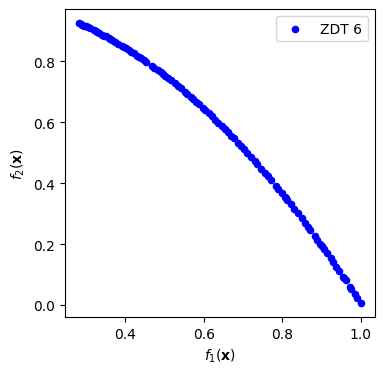

In [25]:
plot_colors = ('b','r', 'g', 'm', 'y', 'k', 'c')
fig, ax = plt.subplots(1, figsize=(4,4))

df.plot(ax=ax, kind='scatter', label='ZDT 6', 
        x=df.columns[0], y=df.columns[1], 
        color=plot_colors[i % len(plot_colors)])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

In [40]:
for index in range(1, 11):
    toolbox.register("select", tools.selNSGA3, ref_points=ref_points)
    toolbox.pop_size = MU
    toolbox.max_gen = NGEN
    toolbox.mut_prob = MUTPB
    toolbox.cross_prob = CXPB

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Tiempo", measure_time)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "Tiempo"
    
    print(f"Iteration {index}")
    start_time = time.time()
    res, logbook = nsga_iii(toolbox=toolbox,seed=index,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

    fronts = tools.emo.sortLogNondominated(res, len(res))

    for i, inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)

    df.to_csv(f'deap_fitness_nsga3_zdt6_100_500_2_10-{index}.csv', index=False)
    log = pd.DataFrame(logbook)
    log.to_csv(f'deap_time_nsga3_zdt6_100_500_2_10-{index}.csv', index=False)
    del(log, df, par, fronts, logbook, res, start_time)


Iteration 1
gen	evals	Tiempo   
1  	     	0.0105622
2  	     	0.0160964
3  	     	0.0241694
4  	     	0.0291834
5  	     	0.0341446
6  	     	0.0410829
7  	     	0.0470669
8  	     	0.0524735
9  	     	0.0584953
10 	     	0.0634801
11 	     	0.0694268
12 	     	0.0770345
13 	     	0.0842764
14 	     	0.0924582
15 	     	0.09829  
16 	     	0.109262 
17 	     	0.118277 
18 	     	0.125661 
19 	     	0.132463 
20 	     	0.139199 
21 	     	0.147017 
22 	     	0.157569 
23 	     	0.16664  
24 	     	0.174472 
25 	     	0.182603 
26 	     	0.190388 
27 	     	0.19809  
28 	     	0.206066 
29 	     	0.215066 
30 	     	0.225937 
31 	     	0.232942 
32 	     	0.240992 
33 	     	0.253452 
34 	     	0.26445  
35 	     	0.275349 
36 	     	0.280336 
37 	     	0.290249 
38 	     	0.297275 
39 	     	0.305255 
40 	     	0.311238 
41 	     	0.317086 
42 	     	0.32643  
43 	     	0.336405 
44 	     	0.344382 
45 	     	0.352382 
46 	     	0.367287 
47 	     	0.377101 
48 	     	0.38508  
49 	    

419	     	3.43628  
420	     	3.44629  
421	     	3.45223  
422	     	3.46025  
423	     	3.46705  
424	     	3.47613  
425	     	3.48307  
426	     	3.49406  
427	     	3.50165  
428	     	3.5116   
429	     	3.51958  
430	     	3.5275   
431	     	3.53448  
432	     	3.54342  
433	     	3.5504   
434	     	3.55948  
435	     	3.56927  
436	     	3.57832  
437	     	3.58549  
438	     	3.59408  
439	     	3.60108  
440	     	3.61004  
441	     	3.61902  
442	     	3.62706  
443	     	3.63456  
444	     	3.64254  
445	     	3.65151  
446	     	3.65988  
447	     	3.66717  
448	     	3.67625  
449	     	3.68327  
450	     	3.69317  
451	     	3.70015  
452	     	3.70971  
453	     	3.71769  
454	     	3.72774  
455	     	3.73552  
456	     	3.745    
457	     	3.75444  
458	     	3.76333  
459	     	3.77144  
460	     	3.78042  
461	     	3.78943  
462	     	3.79704  
463	     	3.806    
464	     	3.81398  
465	     	3.82528  
466	     	3.833    
467	     	3.84198  
468	     	3.85007  


326	     	2.81942   
327	     	2.82834   
328	     	2.83538   
329	     	2.84289   
330	     	2.85037   
331	     	2.86081   
332	     	2.86882   
333	     	2.87735   
334	     	2.88433   
335	     	2.89426   
336	     	2.90179   
337	     	2.90981   
338	     	2.91679   
339	     	2.92473   
340	     	2.93137   
341	     	2.94075   
342	     	2.95125   
343	     	2.96429   
344	     	2.97428   
345	     	2.98226   
346	     	2.99083   
347	     	2.99781   
348	     	3.00398   
349	     	3.01196   
350	     	3.01898   
351	     	3.02696   
352	     	3.0359    
353	     	3.04524   
354	     	3.05206   
355	     	3.05904   
356	     	3.06798   
357	     	3.075     
358	     	3.083     
359	     	3.09098   
360	     	3.098     
361	     	3.10398   
362	     	3.11292   
363	     	3.12192   
364	     	3.12891   
365	     	3.13589   
366	     	3.14332   
367	     	3.15027   
368	     	3.1608    
369	     	3.16875   
370	     	3.17824   
371	     	3.18642   
372	     	3.19485   
373	     	3.2

231	     	1.97793   
232	     	1.98817   
233	     	1.99964   
234	     	2.00368   
235	     	2.01498   
236	     	2.01909   
237	     	2.02917   
238	     	2.03418   
239	     	2.04385   
240	     	2.0499    
241	     	2.06048   
242	     	2.06652   
243	     	2.07031   
244	     	2.07916   
245	     	2.08783   
246	     	2.09463   
247	     	2.09903   
248	     	2.10818   
249	     	2.11135   
250	     	2.11946   
251	     	2.13155   
252	     	2.13915   
253	     	2.14818   
254	     	2.15392   
255	     	2.16178   
256	     	2.1711    
257	     	2.17935   
258	     	2.18336   
259	     	2.1958    
260	     	2.20688   
261	     	2.21658   
262	     	2.22309   
263	     	2.22979   
264	     	2.23779   
265	     	2.24706   
266	     	2.25637   
267	     	2.26242   
268	     	2.27558   
269	     	2.28765   
270	     	2.2973    
271	     	2.30256   
272	     	2.31269   
273	     	2.31886   
274	     	2.3326    
275	     	2.34001   
276	     	2.35017   
277	     	2.35875   
278	     	2.3

136	     	0.982937  
137	     	0.994635  
138	     	1.00687   
139	     	1.02367   
140	     	1.04339   
141	     	1.05084   
142	     	1.05937   
143	     	1.07495   
144	     	1.09175   
145	     	1.10442   
146	     	1.11643   
147	     	1.1277    
148	     	1.14324   
149	     	1.14953   
150	     	1.15635   
151	     	1.16334   
152	     	1.17178   
153	     	1.17582   
154	     	1.18659   
155	     	1.19312   
156	     	1.19713   
157	     	1.20844   
158	     	1.21771   
159	     	1.22301   
160	     	1.23414   
161	     	1.24324   
162	     	1.24844   
163	     	1.254     
164	     	1.2631    
165	     	1.26987   
166	     	1.27213   
167	     	1.28092   
168	     	1.28848   
169	     	1.29308   
170	     	1.30089   
171	     	1.30324   
172	     	1.31194   
173	     	1.3197    
174	     	1.32806   
175	     	1.33584   
176	     	1.34296   
177	     	1.34701   
178	     	1.35637   
179	     	1.36292   
180	     	1.3712    
181	     	1.3758    
182	     	1.38325   
183	     	1.3

33 	     	0.248794  
34 	     	0.256617  
35 	     	0.263706  
36 	     	0.271056  
37 	     	0.281193  
38 	     	0.286777  
39 	     	0.296997  
40 	     	0.301045  
41 	     	0.312101  
42 	     	0.315682  
43 	     	0.324812  
44 	     	0.32929   
45 	     	0.336117  
46 	     	0.346596  
47 	     	0.350651  
48 	     	0.356759  
49 	     	0.364768  
50 	     	0.370853  
51 	     	0.377245  
52 	     	0.383886  
53 	     	0.387067  
54 	     	0.395916  
55 	     	0.406507  
56 	     	0.415     
57 	     	0.420564  
58 	     	0.429544  
59 	     	0.434615  
60 	     	0.441785  
61 	     	0.446797  
62 	     	0.454924  
63 	     	0.465245  
64 	     	0.472415  
65 	     	0.486128  
66 	     	0.495981  
67 	     	0.500029  
68 	     	0.507658  
69 	     	0.513835  
70 	     	0.517937  
71 	     	0.526189  
72 	     	0.533423  
73 	     	0.535441  
74 	     	0.545526  
75 	     	0.548555  
76 	     	0.556101  
77 	     	0.561466  
78 	     	0.567109  
79 	     	0.571156  
80 	     	0.5

437	     	4.01494   
438	     	4.02763   
439	     	4.03555   
440	     	4.04484   
441	     	4.04587   
442	     	4.05913   
443	     	4.06606   
444	     	4.07369   
445	     	4.07906   
446	     	4.08687   
447	     	4.09605   
448	     	4.10709   
449	     	4.11375   
450	     	4.11475   
451	     	4.12718   
452	     	4.13701   
453	     	4.14704   
454	     	4.15582   
455	     	4.16396   
456	     	4.16699   
457	     	4.17905   
458	     	4.18747   
459	     	4.1977    
460	     	4.20373   
461	     	4.21522   
462	     	4.22076   
463	     	4.23179   
464	     	4.23685   
465	     	4.25074   
466	     	4.26268   
467	     	4.26806   
468	     	4.2833    
469	     	4.28969   
470	     	4.29765   
471	     	4.30705   
472	     	4.3157    
473	     	4.32911   
474	     	4.33689   
475	     	4.3473    
476	     	4.35388   
477	     	4.36388   
478	     	4.36791   
479	     	4.38001   
480	     	4.38707   
481	     	4.39598   
482	     	4.40457   
483	     	4.41593   
484	     	4.4

328	     	2.94079   
329	     	2.95604   
330	     	2.96765   
331	     	2.98117   
332	     	2.98817   
333	     	3.00348   
334	     	3.00814   
335	     	3.02486   
336	     	3.03888   
337	     	3.04514   
338	     	3.05514   
339	     	3.05717   
340	     	3.06806   
341	     	3.07735   
342	     	3.08499   
343	     	3.09118   
344	     	3.09977   
345	     	3.107     
346	     	3.11703   
347	     	3.12574   
348	     	3.13485   
349	     	3.1367    
350	     	3.14688   
351	     	3.15718   
352	     	3.16979   
353	     	3.1781    
354	     	3.18785   
355	     	3.19504   
356	     	3.20082   
357	     	3.20824   
358	     	3.22196   
359	     	3.23692   
360	     	3.24725   
361	     	3.25819   
362	     	3.27029   
363	     	3.2772    
364	     	3.2896    
365	     	3.29965   
366	     	3.31095   
367	     	3.32341   
368	     	3.33579   
369	     	3.34122   
370	     	3.35536   
371	     	3.35637   
372	     	3.37699   
373	     	3.38788   
374	     	3.39954   
375	     	3.4

240	     	2.12875   
241	     	2.14305   
242	     	2.15794   
243	     	2.16327   
244	     	2.17328   
245	     	2.18064   
246	     	2.18903   
247	     	2.19308   
248	     	2.20272   
249	     	2.21111   
250	     	2.21873   
251	     	2.22278   
252	     	2.22895   
253	     	2.23795   
254	     	2.24591   
255	     	2.2545    
256	     	2.26088   
257	     	2.27148   
258	     	2.27794   
259	     	2.28823   
260	     	2.29153   
261	     	2.30428   
262	     	2.31277   
263	     	2.32075   
264	     	2.32927   
265	     	2.34478   
266	     	2.35807   
267	     	2.36806   
268	     	2.37726   
269	     	2.38676   
270	     	2.39294   
271	     	2.40164   
272	     	2.40811   
273	     	2.41413   
274	     	2.42266   
275	     	2.42879   
276	     	2.43812   
277	     	2.44616   
278	     	2.45659   
279	     	2.46267   
280	     	2.47224   
281	     	2.47795   
282	     	2.48908   
283	     	2.4968    
284	     	2.5056    
285	     	2.51049   
286	     	2.52473   
287	     	2.5

140	     	1.41956   
141	     	1.43234   
142	     	1.44462   
143	     	1.46013   
144	     	1.47619   
145	     	1.48744   
146	     	1.50456   
147	     	1.51977   
148	     	1.532     
149	     	1.53919   
150	     	1.55151   
151	     	1.57282   
152	     	1.59546   
153	     	1.6113    
154	     	1.6385    
155	     	1.65229   
156	     	1.66464   
157	     	1.68014   
158	     	1.69556   
159	     	1.70276   
160	     	1.71577   
161	     	1.72525   
162	     	1.73268   
163	     	1.74208   
164	     	1.74208   
165	     	1.75236   
166	     	1.76278   
167	     	1.76278   
168	     	1.77591   
169	     	1.78196   
170	     	1.78196   
171	     	1.79228   
172	     	1.80047   
173	     	1.80246   
174	     	1.81392   
175	     	1.81952   
176	     	1.82538   
177	     	1.83274   
178	     	1.8398    
179	     	1.8436    
180	     	1.85277   
181	     	1.86188   
182	     	1.86915   
183	     	1.87514   
184	     	1.88179   
185	     	1.88279   
186	     	1.89346   
187	     	1.9

34 	     	0.328399 
35 	     	0.337276 
36 	     	0.348621 
37 	     	0.356663 
38 	     	0.359657 
39 	     	0.368005 
40 	     	0.369002 
41 	     	0.379596 
42 	     	0.381664 
43 	     	0.392034 
44 	     	0.396643 
45 	     	0.399803 
46 	     	0.411421 
47 	     	0.419547 
48 	     	0.426398 
49 	     	0.428756 
50 	     	0.439766 
51 	     	0.447143 
52 	     	0.449179 
53 	     	0.459467 
54 	     	0.459467 
55 	     	0.468107 
56 	     	0.479711 
57 	     	0.481782 
58 	     	0.491502 
59 	     	0.499599 
60 	     	0.499599 
61 	     	0.509014 
62 	     	0.516749 
63 	     	0.526358 
64 	     	0.528357 
65 	     	0.541967 
66 	     	0.549274 
67 	     	0.561932 
68 	     	0.568425 
69 	     	0.578426 
70 	     	0.58202  
71 	     	0.593436 
72 	     	0.601125 
73 	     	0.611365 
74 	     	0.618777 
75 	     	0.631508 
76 	     	0.638869 
77 	     	0.642467 
78 	     	0.653703 
79 	     	0.65906  
80 	     	0.667772 
81 	     	0.679761 
82 	     	0.688268 
83 	     	0.692048 


466	     	4.26866  
467	     	4.28861  
468	     	4.29875  
469	     	4.29975  
470	     	4.30976  
471	     	4.31942  
472	     	4.33052  
473	     	4.34401  
474	     	4.35891  
475	     	4.35891  
476	     	4.36861  
477	     	4.37975  
478	     	4.38827  
479	     	4.3929   
480	     	4.39945  
481	     	4.41061  
482	     	4.41882  
483	     	4.4262   
484	     	4.43847  
485	     	4.44862  
486	     	4.44862  
487	     	4.45949  
488	     	4.46869  
489	     	4.47827  
490	     	4.48759  
491	     	4.49908  
492	     	4.50888  
493	     	4.50888  
494	     	4.51953  
495	     	4.52964  
496	     	4.538    
497	     	4.55181  
498	     	4.55857  
499	     	4.56851  
500	     	4.5752   
Iteration 10
gen	evals	Tiempo    
1  	     	0.00593615
2  	     	0.0137124 
3  	     	0.0208161 
4  	     	0.0245872 
5  	     	0.0338643 
6  	     	0.0393736 
7  	     	0.0424788 
8  	     	0.0424788 
9  	     	0.0570796 
10 	     	0.0616975 
11 	     	0.0637283 
12 	     	0.0742385 
13 	     	0.08

378	     	3.38281   
379	     	3.39517   
380	     	3.40658   
381	     	3.41281   
382	     	3.42381   
383	     	3.43153   
384	     	3.43904   
385	     	3.44265   
386	     	3.45911   
387	     	3.4727    
388	     	3.48032   
389	     	3.48251   
390	     	3.49333   
391	     	3.50459   
392	     	3.51286   
393	     	3.51286   
394	     	3.5226    
395	     	3.53296   
396	     	3.54196   
397	     	3.54299   
398	     	3.55945   
399	     	3.56272   
400	     	3.57238   
401	     	3.58184   
402	     	3.59176   
403	     	3.60262   
404	     	3.61221   
405	     	3.62258   
406	     	3.62458   
407	     	3.63346   
408	     	3.64353   
409	     	3.65284   
410	     	3.66078   
411	     	3.66235   
412	     	3.67335   
413	     	3.68165   
414	     	3.68938   
415	     	3.69337   
416	     	3.70233   
417	     	3.71053   
418	     	3.71354   
419	     	3.72235   
420	     	3.73284   
421	     	3.74005   
422	     	3.7431    
423	     	3.75806   
424	     	3.76283   
425	     	3.7